In [4]:
# 데이터 핸들링을 위한 패키지
import numpy as np
import pandas as pd

# 통계를 위해 사용하는 패키지
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

# 머신러닝을 위한 패키지
import sklearn.linear_model
from sklearn.model_selection import train_test_split

# 시간관련
from datetime import timedelta
import datetime as dt

# 시각화를 위한 패키지
from matplotlib import pyplot as plt
import chart_studio.plotly as py
import seaborn as sns
import cufflinks as cf
import missingno as msno

# 그래프를 실제로 그리기 위한 설정
%matplotlib inline

# 경고 메세지 무시
import warnings
warnings.filterwarnings('ignore')

cf.go_offline(connected=True)

In [5]:
# 여러 CSV 파일 읽기
import glob

# path = ["analyzed_lime_data_201912.csv", "analyzed_lime_data_202001.csv","analyzed_lime_data_202002.csv",
#        "analyzed_lime_data_202003.csv","analyzed_lime_data_202004.csv","analyzed_lime_data_202005.csv",
#        "analyzed_lime_data_202006.csv","analyzed_lime_data_202007.csv"]

li = []
all_files = glob.glob("../data/*.csv")
# all_files

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)


# Overview
- 전체 데이터는 2020.01.01 ~ 2020.11.30 입니다.

## 아래 내용은 안함
- 시간별 분석은 2020.01.01 ~ 2020.10.30 만 할 예정
- Train: 2020.01.01 ~ 2020.06.30
- Test: 2020.07.01 ~ 2020.07.20

# 데이터 전처리

## 결측치 확인

<AxesSubplot:>

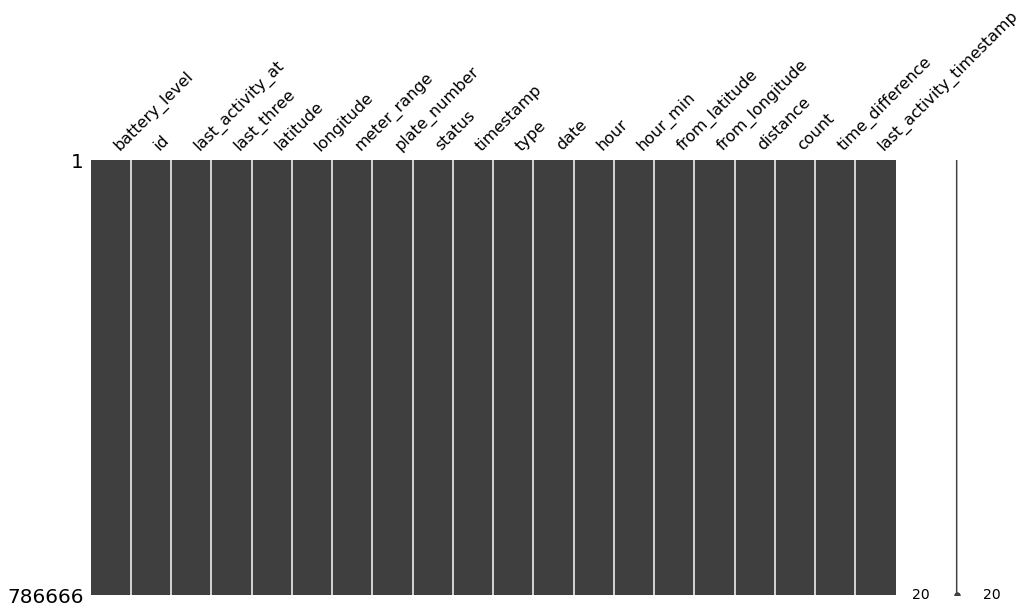

In [6]:
# Missing data 시각적으로 확인방법

msno.matrix(df, figsize=(16,8))

In [7]:
df.isnull().sum()

battery_level              0
id                         0
last_activity_at           0
last_three                 0
latitude                   0
longitude                  0
meter_range                0
plate_number               0
status                     0
timestamp                  0
type                       0
date                       0
hour                       0
hour_min                   0
from_latitude              0
from_longitude             0
distance                   0
count                      0
time_difference            0
last_activity_timestamp    0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786666 entries, 0 to 786665
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   battery_level            786666 non-null  object 
 1   id                       786666 non-null  object 
 2   last_activity_at         786666 non-null  object 
 3   last_three               786666 non-null  object 
 4   latitude                 786666 non-null  float64
 5   longitude                786666 non-null  float64
 6   meter_range              786666 non-null  int64  
 7   plate_number             786666 non-null  object 
 8   status                   786666 non-null  object 
 9   timestamp                786666 non-null  object 
 10  type                     786666 non-null  object 
 11  date                     786666 non-null  object 
 12  hour                     786666 non-null  int64  
 13  hour_min                 786666 non-null  object 
 14  from

## 최소 거리가 300 m 이상인 것만 
- 나중에 분석 후 고민

In [9]:
df = df.sort_values(by='timestamp')

In [10]:
df = df[df['distance'] >= 300]

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 314039 entries, 505751 to 369546
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   battery_level            314039 non-null  object 
 1   id                       314039 non-null  object 
 2   last_activity_at         314039 non-null  object 
 3   last_three               314039 non-null  object 
 4   latitude                 314039 non-null  float64
 5   longitude                314039 non-null  float64
 6   meter_range              314039 non-null  int64  
 7   plate_number             314039 non-null  object 
 8   status                   314039 non-null  object 
 9   timestamp                314039 non-null  object 
 10  type                     314039 non-null  object 
 11  date                     314039 non-null  object 
 12  hour                     314039 non-null  int64  
 13  hour_min                 314039 non-null  object 
 14 

## 기술통계 살펴보기

In [12]:
## 중간값, 결측치, 왜도, 첨도 표시
df_stats = df.describe().T

skew_results = []
kurtosis_results = []
null_results = []
median_results = []

for idx, val in enumerate(df_stats.index):

    median_results.append(df[val].median())
    skew_results.append(df[val].skew())
    kurtosis_results.append(df[val].kurtosis())
    null_results.append(df[val].isnull().sum())  

df_stats['median'] = median_results
df_stats['missing'] = null_results
df_stats['skew'] = skew_results
df_stats['kurtosis'] = kurtosis_results
df_stats

count          mean           std         min  \
latitude         314039.0     37.505185      0.005865   37.436472   
longitude        314039.0    127.048970      0.029885  126.915621   
meter_range      314039.0  19193.962355  11489.475380  965.000000   
hour             314039.0     12.957235      7.028734    0.000000   
from_latitude    314039.0     37.505185      0.005865   37.436472   
from_longitude   314039.0    127.048970      0.029885  126.915621   
distance         314039.0   1748.063174   1852.853587  300.000226   
count            314039.0      1.000000      0.000000    1.000000   
time_difference  314039.0    282.633949    403.696669    9.016667   

                         25%           50%           75%           max  \
latitude           37.500362     37.504727     37.509955     37.522410   
longitude         127.028328    127.043374    127.062462    127.113689   
meter_range      9154.000000  18271.000000  30159.000000  40233.000000   
hour                7.000000     14.000000     19.000000     23.000000   
from_latitude      37.500362     37.504727     37.509955     37.522410   
from_longitude    127.028328    127.043374    127.062462    127.113689   
distance          493.189956    915.495431   2336.414167  17267.447225   
count               1.000000      1.000000      1.000000      1.000000   
time_difference    10.033333     30.000000    460.000000   1439.983333   

                       median  missing      skew  kurtosis  
latitude            37.504727        0  0.100670 -0.605332  
longitude          127.043374        0  0.540027 -0.591308  
meter_range      18271.000000        0  0.205419 -1.150271  
hour                14.000000        0 -0.341787 -1.103408  
from_latitude       37.504727        0  0.100670 -0.605332  
from_longitude     127.043374        0  0.540027 -0.591308  
distance           915.495431        0  1.781143  2.676370  
count                1.000000        0  0.000000  0.000000  
time_difference     30.000000        0  1.400998  0.671684

<AxesSubplot:>

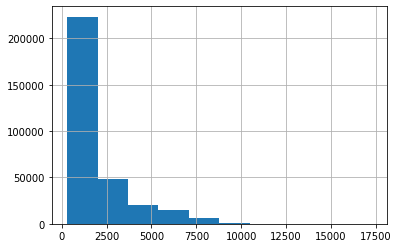

In [13]:
df.distance.hist()

<AxesSubplot:>

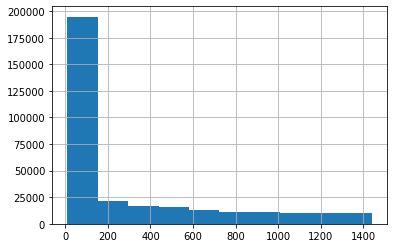

In [14]:
df.time_difference.hist()

## 아웃라이어 제거

- time_difference가 너무 큰 값인 경우
- 제한 최고속도는 시속 15마일(약 22km/h)이다.
- 거리 = 속력 * 시간
- 10분으로 최대한 멀리 갈 수 있는 거리는 -> 22 * (10/60) = 3.6666666666666665 / 즉 3.6km 이다.

In [15]:
# len(df)
df.shape

(314039, 20)

In [16]:
df[(df.distance >= 3600) & (df.time_difference < 11)]

battery_level                                          id  \
464536          high  ET-F6AHUR7SWS6TNTUBQHOLZTPPX6OJ3SLENOAYFTA   
440758          high  ET-GXVGGKLTQ4UI6QSU3T6RGYYF36SNOATGX6NV5OQ   
464537          high  ET-RGC6UFVOZ7BTLVRWGFYNSTEJFZ7PXIWPJHUZGXY   
440759           low  ET-TOGEQFF57IF7YRYMXVY7S6JXLZCUFOEGFZ25QDY   
440760          high  ET-SUNHK6752AFBO7L42HQLN67E7R5W4FZ65WMOBGI   
...              ...                                         ...   
384463          high  ET-PJBQ2S5P3YYNRGLX4P4BJPXQVSYGYPDVJHJOMVI   
384464          high  ET-YN4P5ZIORUSI7442YB7VTS72HPNAT3RRB6TKLPI   
384465          high  ET-IIMLC7FBRBYNVKKTACB5WHT32SGNQMA2IJGM5BA   
384466          high  ET-4GLTYJFBGJCZ2G76QBGQJQJ6W5CIPU6NWS6XYZI   
369546          high  ET-MM3JJ5CQETOSQCKE2O7M3YLC26IDIUTWLVDIEJI   

                last_activity_at last_three   latitude   longitude  \
464536  2019-12-31T14:56:52.000Z        LJN  37.516306  127.099517   
440758  2019-12-31T14:51:35.000Z        CHW  37.503680  127.045328   
464537  2019-12-31T15:09:25.000Z        LJN  37.497074  127.036665   
440759  2019-12-31T15:08:44.000Z        CHW  37.509888  127.103269   
440760  2019-12-31T15:11:35.000Z        CHW  37.503680  127.045328   
...                          ...        ...        ...         ...   
384463  2020-11-30T09:56:38.000Z        GYJ  37.508364  127.062627   
384464  2020-11-30T10:21:56.000Z        GYJ  37.504237  127.006184   
384465  2020-11-30T10:47:38.000Z        GYJ  37.508394  127.062013   
384466  2020-11-30T10:48:55.000Z        GYJ  37.504141  127.006175   
369546  2020-11-30T14:25:22.000Z        BVA  37.509484  127.065775   

        meter_range plate_number  status            timestamp   type  \
464536        39830      XXX-LJN  locked  2020-01-01 00:10:15  bikes   
440758        40233      XXX-CHW  locked  2020-01-01 00:10:15  bikes   
464537        29772      XXX-LJN  locked  2020-01-01 00:20:15  bikes   
440759        10058      XXX-CHW  locked  2020-01-01 00:20:15  bikes   
440760        40233      XXX-CHW  locked  2020-01-01 00:30:16  bikes   
...             ...          ...     ...                  ...    ...   
384463        32180      XXX-GYJ  locked  2020-11-30 19:30:08  bikes   
384464        29171      XXX-GYJ  locked  2020-11-30 19:40:09  bikes   
384465        32180      XXX-GYJ  locked  2020-11-30 19:50:16  bikes   
384466        29171      XXX-GYJ  locked  2020-11-30 20:00:18  bikes   
369546        24140      XXX-BVA  locked  2020-11-30 23:50:14  bikes   

              date  hour  hour_min  from_latitude  from_longitude  \
464536  2020-01-01     0  00:10:15      37.516306      127.099517   
440758  2020-01-01     0  00:10:15      37.503680      127.045328   
464537  2020-01-01     0  00:20:15      37.497074      127.036665   
440759  2020-01-01     0  00:20:15      37.509888      127.103269   
440760  2020-01-01     0  00:30:16      37.503680      127.045328   
...            ...   ...       ...            ...             ...   
384463  2020-11-30    19  19:30:08      37.508364      127.062627   
384464  2020-11-30    19  19:40:09      37.504237      127.006184   
384465  2020-11-30    19  19:50:16      37.508394      127.062013   
384466  2020-11-30    20  20:00:18      37.504141      127.006175   
369546  2020-11-30    23  23:50:14      37.509484      127.065775   

           distance  count  time_difference    last_activity_timestamp  
464536  5954.846808    1.0         9.983333  2019-12-31 23:56:52+00:00  
440758  5096.291927    1.0         9.983333  2019-12-31 23:51:35+00:00  
464537  5953.050124    1.0        10.000000  2020-01-01 00:09:25+00:00  
440759  5169.120852    1.0        10.000000  2020-01-01 00:08:44+00:00  
440760  5169.120852    1.0        10.016667  2020-01-01 00:11:35+00:00  
...             ...    ...              ...                        ...  
384463  5026.404357    1.0         9.950000  2020-11-30 18:56:38+00:00  
384464  5011.553839    1.0        10.016667  2020-11-30 19:21:56+00:00 

In [17]:
idx_rm = df[(df.distance >= 3600) & (df.time_difference < 11)].index
df = df.drop(idx_rm)
df.shape

(290991, 20)

# 분포도

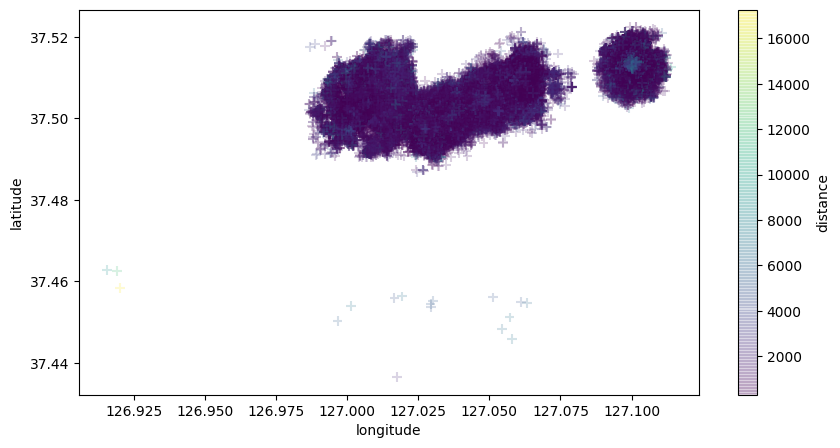

In [18]:
# 산점도 분석 
import matplotlib.pyplot as plt

plt.style.use('default')

df.plot(x='longitude', y='latitude', marker='+', kind='scatter',
        figsize=(10,5), c='distance', colormap='viridis', s=50, alpha=0.2)

plt.show()

In [19]:
# df[:1000].plot(x='longitude', y='latitude', marker='+', kind='scatter',
#         figsize=(10,5), c='distance', colormap='viridis', s=50, alpha=0.2)

# plt.show()

In [20]:
# # folium 임포트
# import folium

# mapping = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()],
#                     zoom_start=11)

# for n in df[:].index:
#   # if df['Address'][n] != 'Multiple':
# #     folium.Marker([df['latitude'][n], df['longitude'][n]],
# #                  popup=df['last_three'][n]).add_to(mapping)
#     folium.Circle([df['latitude'][n], df['longitude'][n]],
#                  radius = 200).add_to(mapping)

# mapping.save('example.html')

# 년,월,일,시간 으로 count 계산하기

In [21]:
df_summary = {'year': [],
           'month': [],
           'day': [],
           'hour': [],
           'count': [],
         }
df_summary = pd.DataFrame([df_summary])
df_summary.head()

year month day hour count
0   []    []  []   []    []

In [22]:
df = df[['last_three','date','hour','count','distance','battery_level']]
df.head()

last_three        date  hour  count     distance battery_level
505751        ZPC  2020-01-01     0    1.0  1167.965574           low
505752        ZPC  2020-01-01     0    1.0  1180.154391          high
505753        ZPC  2020-01-01     0    1.0  1180.154391           low
487534        TUZ  2020-01-01     0    1.0  1229.257417          high
484696        SVQ  2020-01-01     0    1.0   702.643026           low

In [23]:
df.sort_values(by=['date','hour'], inplace=True)
df.head()

last_three        date  hour  count     distance battery_level
505751        ZPC  2020-01-01     0    1.0  1167.965574           low
505752        ZPC  2020-01-01     0    1.0  1180.154391          high
505753        ZPC  2020-01-01     0    1.0  1180.154391           low
487534        TUZ  2020-01-01     0    1.0  1229.257417          high
484696        SVQ  2020-01-01     0    1.0   702.643026           low

In [24]:
df['date'] = df['date'].astype('str')

In [25]:
df['hour'] = df['hour'].astype('str')

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290991 entries, 505751 to 362721
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   last_three     290991 non-null  object 
 1   date           290991 non-null  object 
 2   hour           290991 non-null  object 
 3   count          290991 non-null  float64
 4   distance       290991 non-null  float64
 5   battery_level  290991 non-null  object 
dtypes: float64(2), object(4)
memory usage: 15.5+ MB


In [27]:
df.head()

last_three        date hour  count     distance battery_level
505751        ZPC  2020-01-01    0    1.0  1167.965574           low
505752        ZPC  2020-01-01    0    1.0  1180.154391          high
505753        ZPC  2020-01-01    0    1.0  1180.154391           low
487534        TUZ  2020-01-01    0    1.0  1229.257417          high
484696        SVQ  2020-01-01    0    1.0   702.643026           low

In [28]:
df['date_hour'] = df.apply(lambda x: x['date'] + ' ' + x['hour'] + ':00:00', axis=1)

In [29]:
df.head()

last_three        date hour  count     distance battery_level  \
505751        ZPC  2020-01-01    0    1.0  1167.965574           low   
505752        ZPC  2020-01-01    0    1.0  1180.154391          high   
505753        ZPC  2020-01-01    0    1.0  1180.154391           low   
487534        TUZ  2020-01-01    0    1.0  1229.257417          high   
484696        SVQ  2020-01-01    0    1.0   702.643026           low   

                 date_hour  
505751  2020-01-01 0:00:00  
505752  2020-01-01 0:00:00  
505753  2020-01-01 0:00:00  
487534  2020-01-01 0:00:00  
484696  2020-01-01 0:00:00

In [30]:
df['date_hour'] = df['date_hour'].astype('datetime64')
df.head()

last_three        date hour  count     distance battery_level  \
505751        ZPC  2020-01-01    0    1.0  1167.965574           low   
505752        ZPC  2020-01-01    0    1.0  1180.154391          high   
505753        ZPC  2020-01-01    0    1.0  1180.154391           low   
487534        TUZ  2020-01-01    0    1.0  1229.257417          high   
484696        SVQ  2020-01-01    0    1.0   702.643026           low   

        date_hour  
505751 2020-01-01  
505752 2020-01-01  
505753 2020-01-01  
487534 2020-01-01  
484696 2020-01-01

In [31]:
df.date_hour.value_counts()

2020-06-19 19:00:00    157
2020-06-18 18:00:00    149
2020-06-19 18:00:00    146
2020-06-17 19:00:00    141
2020-06-18 22:00:00    140
                      ... 
2020-03-01 09:00:00      2
2020-01-20 03:00:00      2
2020-08-03 03:00:00      1
2020-03-02 05:00:00      1
2020-03-01 05:00:00      1
Name: date_hour, Length: 8035, dtype: int64

In [32]:
df_cnt = pd.DataFrame(columns=['date_hour','count'])
df_cnt.head()

Empty DataFrame
Columns: [date_hour, count]
Index: []

In [33]:
df_cnt['date_hour'] = df.date_hour.value_counts().index
df_cnt['count'] = df.date_hour.value_counts().values
df_cnt.head()

date_hour  count
0 2020-06-19 19:00:00    157
1 2020-06-18 18:00:00    149
2 2020-06-19 18:00:00    146
3 2020-06-17 19:00:00    141
4 2020-06-18 22:00:00    140

In [34]:
df_cnt.sort_values(by=['date_hour','count'], inplace=True)
df_cnt.head(12)

date_hour  count
6200 2020-01-01 00:00:00     20
3714 2020-01-01 01:00:00     34
6769 2020-01-01 02:00:00     17
6137 2020-01-01 03:00:00     21
7482 2020-01-01 04:00:00     12
7017 2020-01-01 05:00:00     16
7823 2020-01-01 06:00:00      9
7664 2020-01-01 07:00:00     11
7912 2020-01-01 08:00:00      7
7995 2020-01-01 09:00:00      4
7891 2020-01-01 10:00:00      7
7861 2020-01-01 11:00:00      8

In [35]:
df_cnt = df_cnt.reset_index()
df_cnt.head()

index           date_hour  count
0   6200 2020-01-01 00:00:00     20
1   3714 2020-01-01 01:00:00     34
2   6769 2020-01-01 02:00:00     17
3   6137 2020-01-01 03:00:00     21
4   7482 2020-01-01 04:00:00     12

In [36]:
df_summary = df_cnt[['date_hour','count']]
df_summary.head()

date_hour  count
0 2020-01-01 00:00:00     20
1 2020-01-01 01:00:00     34
2 2020-01-01 02:00:00     17
3 2020-01-01 03:00:00     21
4 2020-01-01 04:00:00     12

In [37]:
df_summary['hour'] = df_summary['date_hour'].dt.hour
df_summary['month'] = df_summary['date_hour'].dt.month
df_summary['weekday'] = df_summary['date_hour'].dt.weekday
df_summary['day'] = df_summary['date_hour'].dt.day

In [38]:
df_summary.head()

date_hour  count  hour  month  weekday  day
0 2020-01-01 00:00:00     20     0      1        2    1
1 2020-01-01 01:00:00     34     1      1        2    1
2 2020-01-01 02:00:00     17     2      1        2    1
3 2020-01-01 03:00:00     21     3      1        2    1
4 2020-01-01 04:00:00     12     4      1        2    1

# Training, Test data 나누기

In [39]:
# df_summary.loc[df_summary['date_hour'] >= '2020-07-01']

In [40]:
# # Train data
# df_train = df_summary.loc[df_summary['date_hour'] < '2020-07-01']

# # Test data
# df_test = df_summary.loc[df_summary['date_hour'] >= '2020-07-01']

In [41]:
# 요약은 1월 부터 10월까지 
# df_summary = df_summary.loc[df_summary['date_hour'] < '2020-11-01']

In [42]:
# df_summary.iplot?

In [43]:
# df_summary.iplot(kind='scatter',xTitle='Datetimes',yTitle='Count',title='Lime scooter 2019-12-05 ~ 12-31')

In [44]:
# figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3)
# figure.set_size_inches(18,8)

# sns.barplot(data=df_summary, x="year", y="count", ax=ax1)
# sns.barplot(data=df_summary, x="month", y="count", ax=ax2)
# sns.barplot(data=df_summary, x="day", y="count", ax=ax3)
# sns.barplot(data=df_summary, x="hour", y="count", ax=ax4)
# sns.barplot(data=df_summary, x="minute", y="count", ax=ax5)
# sns.barplot(data=df_summary, x="second", y="count", ax=ax6)

# ax1.set(ylabel='Count', title = "연도별 대여량")
# ax2.set(ylabel='Count', title = "월별 대여량")
# ax3.set(ylabel='Count', title = "일별 대여량")
# ax4.set(ylabel='Count', title = "시간별 대여량")

In [45]:
# df_summary.loc[df_summary['date_hour'] < '2020-07-30']

In [46]:
df['month'] = df['date_hour'].dt.month
df

last_three        date hour  count     distance battery_level  \
505751        ZPC  2020-01-01    0    1.0  1167.965574           low   
505752        ZPC  2020-01-01    0    1.0  1180.154391          high   
505753        ZPC  2020-01-01    0    1.0  1180.154391           low   
487534        TUZ  2020-01-01    0    1.0  1229.257417          high   
484696        SVQ  2020-01-01    0    1.0   702.643026           low   
...           ...         ...  ...    ...          ...           ...   
392540        KXT  2020-11-30   23    1.0   378.310229          high   
411982        SMB  2020-11-30   23    1.0   482.175755        medium   
421040        VQD  2020-11-30   23    1.0   481.769489          high   
423450        WGF  2020-11-30   23    1.0  2471.016586          high   
362721        622  2020-11-30   23    1.0   551.061651        medium   

                 date_hour  month  
505751 2020-01-01 00:00:00      1  
505752 2020-01-01 00:00:00      1  
505753 2020-01-01 00:00:00      1  
487534 2020-01-01 00:00:00      1  
484696 2020-01-01 00:00:00      1  
...                    ...    ...  
392540 2020-11-30 23:00:00     11  
411982 2020-11-30 23:00:00     11  
421040 2020-11-30 23:00:00     11  
423450 2020-11-30 23:00:00     11  
362721 2020-11-30 23:00:00     11  

[290991 rows x 8 columns]

# 라임 킥보드 운용 대수

In [47]:
df.groupby('month')['last_three'].nunique().iplot()

In [48]:
df.groupby('month')['last_three'].unique()

month
1     [ZPC, TUZ, SVQ, MZX, JZG, ZKH, CCX, BEV, LMF, ...
2     [MKR, VWU, LPQ, FZB, JSM, BTG, VMS, MRC, HDJ, ...
3     [QYD, SJA, FXN, SCF, KBA, EGQ, JRY, VFG, PRH, ...
4     [FWP, LEY, GRP, EWX, JUC, JTX, RGT, WRS, ZHV, ...
5     [CTC, APG, MLS, QCL, UKL, LJN, WPT, AGK, AAE, ...
6     [MDX, HDA, FPL, JSM, PFM, CAK, APL, LSF, BQM, ...
7     [FAJ, KAW, FCG, TTC, ESU, PPM, MUU, WFA, XZD, ...
8     [NYK, LSG, KRF, DWD, WNY, SSH, YVK, NMD, CQL, ...
9     [WVT, BGM, ANH, BGF, PSQ, MMK, NGX, LNQ, QGK, ...
10    [AGE, YLS, TST, ZBX, DVX, VXR, BYY, CBX, UWK, ...
11    [GWX, HDA, XDG, FVF, AXH, 829, 820, WVX, ZLS, ...
Name: last_three, dtype: object

In [53]:
df_sum_daily = df.groupby(['date'])[['count']].sum()
df_sum_daily['count']

date
2020-01-01    381.0
2020-01-02    555.0
2020-01-03    584.0
2020-01-04    661.0
2020-01-05    615.0
              ...  
2020-11-26    510.0
2020-11-27    521.0
2020-11-28    410.0
2020-11-29    326.0
2020-11-30    373.0
Name: count, Length: 335, dtype: float64

In [50]:
df

last_three        date hour  count     distance battery_level  \
505751        ZPC  2020-01-01    0    1.0  1167.965574           low   
505752        ZPC  2020-01-01    0    1.0  1180.154391          high   
505753        ZPC  2020-01-01    0    1.0  1180.154391           low   
487534        TUZ  2020-01-01    0    1.0  1229.257417          high   
484696        SVQ  2020-01-01    0    1.0   702.643026           low   
...           ...         ...  ...    ...          ...           ...   
392540        KXT  2020-11-30   23    1.0   378.310229          high   
411982        SMB  2020-11-30   23    1.0   482.175755        medium   
421040        VQD  2020-11-30   23    1.0   481.769489          high   
423450        WGF  2020-11-30   23    1.0  2471.016586          high   
362721        622  2020-11-30   23    1.0   551.061651        medium   

                 date_hour  month  
505751 2020-01-01 00:00:00      1  
505752 2020-01-01 00:00:00      1  
505753 2020-01-01 00:00:00      1  
487534 2020-01-01 00:00:00      1  
484696 2020-01-01 00:00:00      1  
...                    ...    ...  
392540 2020-11-30 23:00:00     11  
411982 2020-11-30 23:00:00     11  
421040 2020-11-30 23:00:00     11  
423450 2020-11-30 23:00:00     11  
362721 2020-11-30 23:00:00     11  

[290991 rows x 8 columns]

# 요일별 사용 횟수

In [49]:
# 요일 별 
df.groupby(['date'])[['count']].sum().iplot()

# 시간별 사용 횟수

In [111]:
df_summary.groupby(['date_hour'])[['count']].sum().iplot()

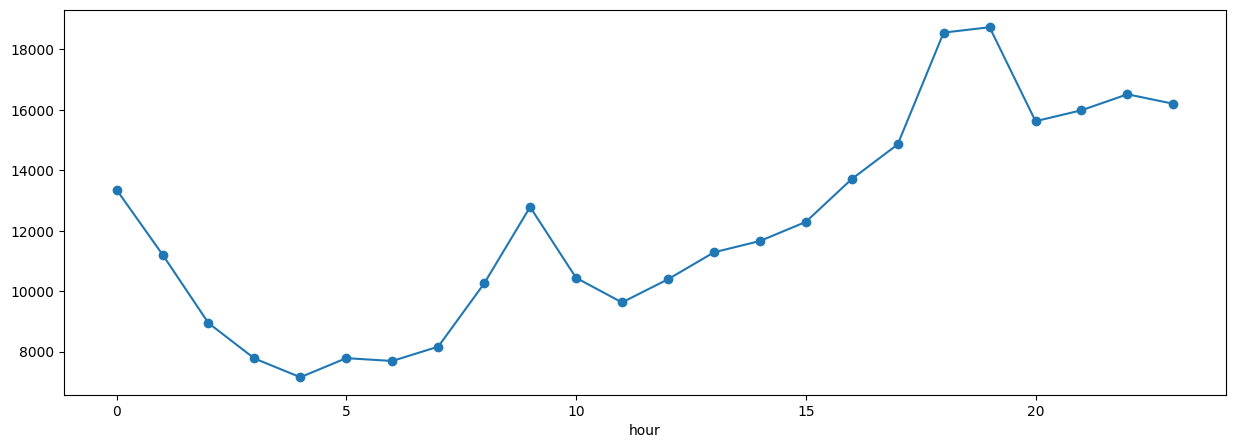

In [112]:
df_summary.groupby('hour')['count'].sum().plot(x='date_hour', y='count', kind='line', style="-o", figsize=(15,5));

# 전체 추세

In [95]:
df_sum_daily = df.groupby(['date_hour'])[['count']].sum()
df_sum_daily['count']

date_hour
2020-01-01 00:00:00    20.0
2020-01-01 01:00:00    34.0
2020-01-01 02:00:00    17.0
2020-01-01 03:00:00    21.0
2020-01-01 04:00:00    12.0
                       ... 
2020-11-30 19:00:00    16.0
2020-11-30 20:00:00     9.0
2020-11-30 21:00:00    26.0
2020-11-30 22:00:00    24.0
2020-11-30 23:00:00    17.0
Name: count, Length: 8035, dtype: float64

In [96]:
# df_sum_daily
df_sum_daily.index

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 01:00:00',
               '2020-01-01 02:00:00', '2020-01-01 03:00:00',
               '2020-01-01 04:00:00', '2020-01-01 05:00:00',
               '2020-01-01 06:00:00', '2020-01-01 07:00:00',
               '2020-01-01 08:00:00', '2020-01-01 09:00:00',
               ...
               '2020-11-30 14:00:00', '2020-11-30 15:00:00',
               '2020-11-30 16:00:00', '2020-11-30 17:00:00',
               '2020-11-30 18:00:00', '2020-11-30 19:00:00',
               '2020-11-30 20:00:00', '2020-11-30 21:00:00',
               '2020-11-30 22:00:00', '2020-11-30 23:00:00'],
              dtype='datetime64[ns]', name='date_hour', length=8035, freq=None)

In [105]:
df_sum_daily.asfreq('H')[df_sum_daily.asfreq('H').isnull().sum(axis=1) > 0]

count
date_hour                 
2020-02-21 10:00:00    NaN
2020-06-10 07:00:00    NaN
2020-06-10 08:00:00    NaN
2020-07-14 06:00:00    NaN
2020-10-29 22:00:00    NaN

In [106]:
df_sum_daily = df_sum_daily.asfreq('H', method='ffill')
df_sum_daily.isnull().sum()

count    0
dtype: int64

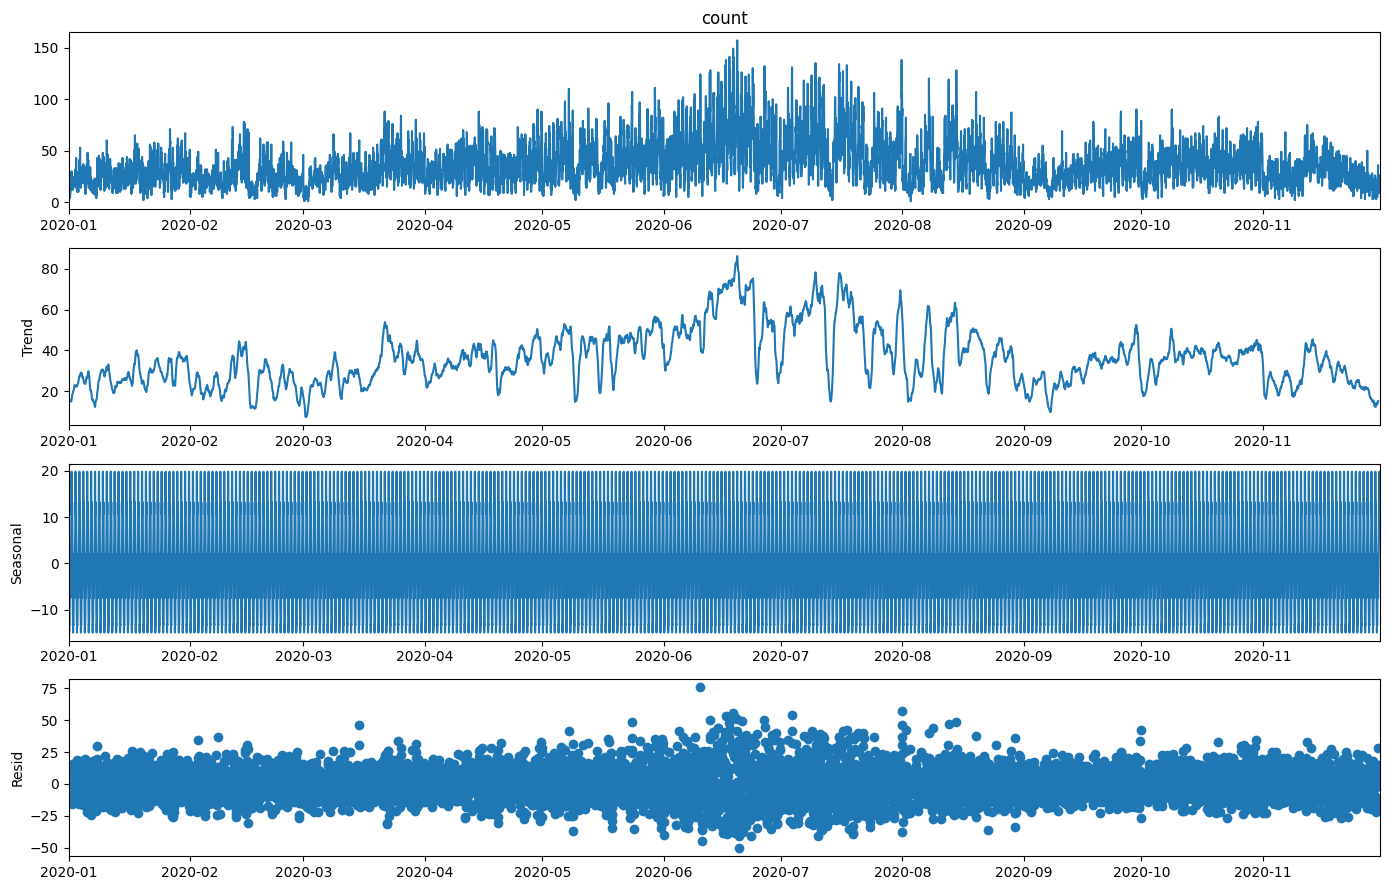

In [109]:
# split data as trend + seasonal + residual
plt.rcParams['figure.figsize'] = (14, 9)
sm.tsa.seasonal_decompose(df_sum_daily['count'], model='additive').plot()
plt.show()

## 분석
- 피크시간: 9시 ~ 10시(출근 시간)
- 가장 덜 분비는 시간: 13시(점심 시간)

In [114]:
df_summary.groupby(['hour', 'weekday'])['count'].mean().unstack()

weekday          0          1          2          3          4          5  \
hour                                                                        
0        32.625000  36.255319  40.458333  41.125000  44.270833  46.541667   
1        27.291667  30.361702  34.791667  33.208333  37.854167  40.666667   
2        24.083333  22.297872  25.437500  26.479167  26.833333  33.541667   
3        23.020833  19.255319  21.437500  24.666667  21.979167  27.791667   
4        20.395833  18.382979  20.750000  20.375000  22.708333  23.458333   
5        21.020833  20.978723  25.729167  23.687500  23.083333  25.166667   
6        21.416667  22.260870  23.937500  23.770833  23.020833  24.291667   
7        24.729167  23.617021  25.808511  28.291667  27.687500  21.333333   
8        34.000000  34.404255  35.297872  37.062500  36.916667  21.020833   
9        43.208333  43.595745  42.250000  47.354167  45.229167  26.250000   
10       34.250000  33.574468  31.666667  35.354167  35.744681  27.645833   
11       29.833333  28.723404  29.937500  30.229167  30.604167  29.041667   
12       29.458333  30.638298  29.166667  32.500000  32.479167  34.104167   
13       31.833333  31.744681  32.687500  33.041667  34.145833  36.750000   
14       30.437500  32.808511  33.187500  35.208333  37.125000  38.812500   
15       33.333333  36.148936  34.687500  35.000000  37.375000  40.541667   
16       35.979167  38.851064  36.333333  41.229167  42.166667  47.083333   
17       39.104167  43.510638  40.083333  43.895833  49.666667  50.708333   
18       50.395833  55.744681  54.791667  60.062500  68.854167  53.333333   
19       51.604167  58.297872  57.208333  61.625000  69.833333  48.166667   
20       43.416667  47.659574  41.958333  50.458333  51.750000  48.145833   
21       44.750000  49.000000  45.145833  47.104167  50.687500  50.125000   
22       44.562500  51.340426  48.333333  51.851064  52.812500  50.750000   
23       40.520833  47.468085  49.041667  51.645833  53.208333  52.166667   

weekday          6  
hour                
0        37.729167  
1        30.041667  
2        28.187500  
3        24.250000  
4        23.395833  
5        23.000000  
6        22.500000  
7        19.687500  
8        16.395833  
9        19.375000  
10       20.770833  
11       22.833333  
12       28.833333  
13       35.562500  
14       36.000000  
15       39.729167  
16       44.770833  
17       43.395833  
18       44.458333  
19       44.666667  
20       43.062500  
21       47.187500  
22       46.479167  
23       44.395833

In [115]:
df_summary.groupby(['hour', 'weekday'])['count'].mean().unstack().iplot()

## 요일별 사용량 수
- 0: 월 / 1: 화 .... / 6: 일

In [116]:
df_summary[['count', 'hour', 'weekday']].pivot_table('count', index='hour', columns='weekday', aggfunc='mean').iplot(kind='scatter')

In [117]:
df_summary.groupby('weekday')[['count']].mean().iplot(kind='bar')

## 평일/주말별 사용량 수

In [118]:
df_summary['is_weekend'] = (df_summary['date_hour'].dt.dayofweek // 5 == 1).astype(int)

In [119]:
df_summary.head()

date_hour  count  hour  month  weekday  day  is_weekend
0 2020-01-01 00:00:00     20     0      1        2    1           0
1 2020-01-01 01:00:00     34     1      1        2    1           0
2 2020-01-01 02:00:00     17     2      1        2    1           0
3 2020-01-01 03:00:00     21     3      1        2    1           0
4 2020-01-01 04:00:00     12     4      1        2    1           0

In [120]:
# 0: 평일 / 1: 주말(토,일)
df_summary.groupby(['hour', 'is_weekend'])['count'].mean().unstack().iplot()

## 요일별 시간대별 heatmap

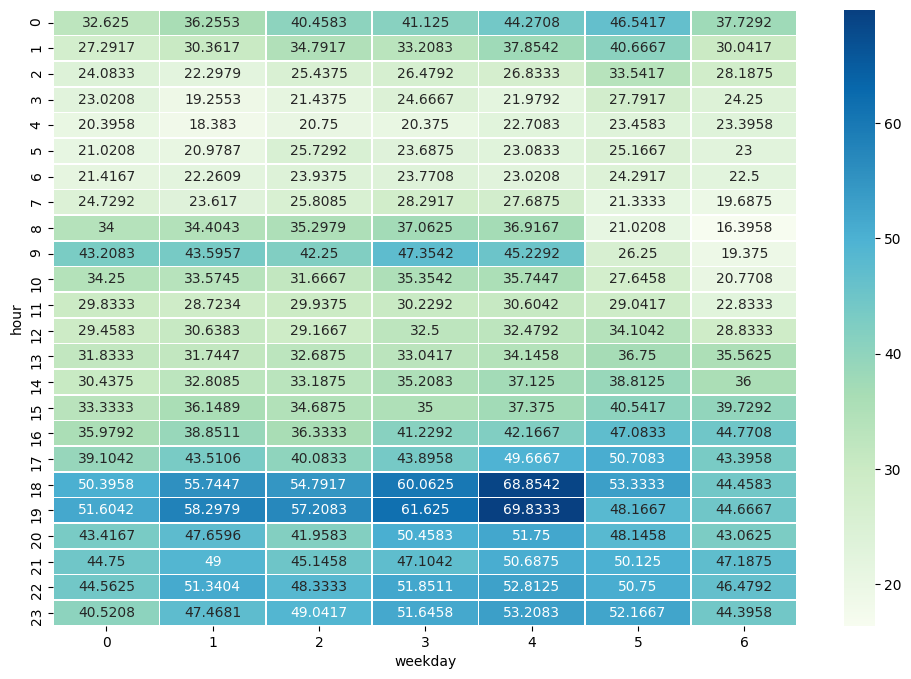

In [121]:
plt.figure(figsize=(12,8))
sns.heatmap(df_summary.groupby(['hour', 'weekday'])['count'].mean().unstack(),
           lw=.5, annot=True, cmap='GnBu', fmt='g', annot_kws={'size':10});

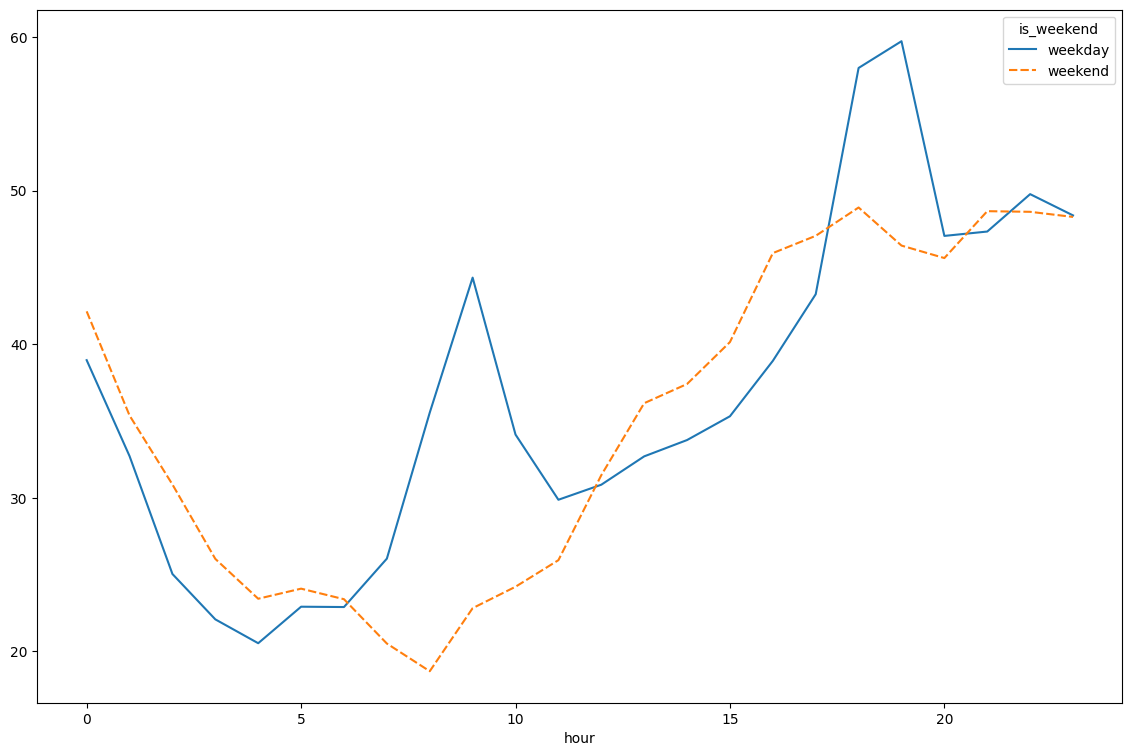

In [122]:
average_df = df_summary.groupby(['is_weekend', 'hour']).mean()['count'].unstack(level=0).rename(columns={0:"weekday", 1:"weekend"})
sns.lineplot(data=average_df);

In [123]:
data = df_summary.groupby(['weekday', 'hour']).mean()['count'].unstack(level=0).reset_index()
data = data.melt(id_vars="hour", value_vars=[0,1,2,3,4,5,6], value_name='count')

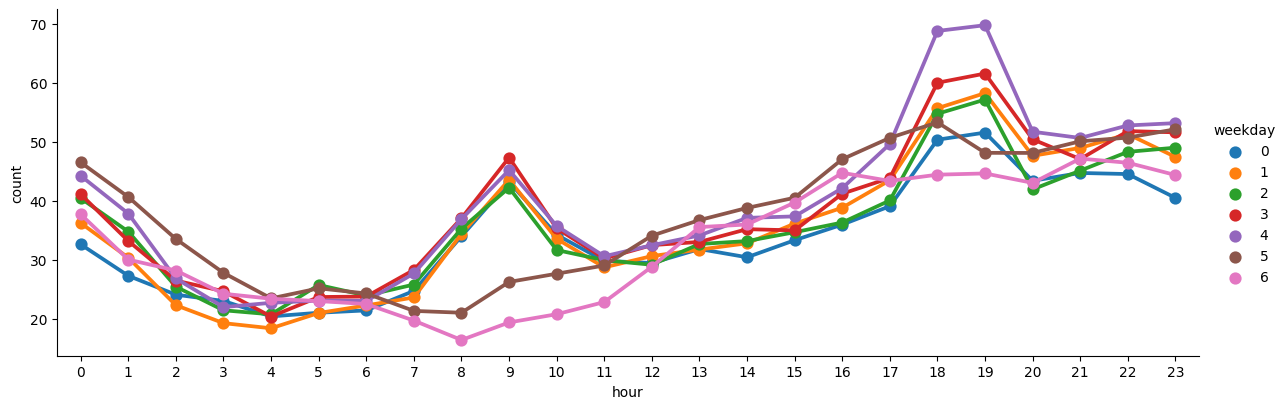

In [127]:
sns.factorplot(x="hour", y='count', hue="weekday", data=data, height=4, aspect=3);

## Boxplot

In [60]:
df_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8035 entries, 0 to 8034
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date_hour   8035 non-null   datetime64[ns]
 1   count       8035 non-null   int64         
 2   hour        8035 non-null   int64         
 3   month       8035 non-null   int64         
 4   weekday     8035 non-null   int64         
 5   day         8035 non-null   int64         
 6   is_weekend  8035 non-null   int64         
dtypes: datetime64[ns](1), int64(6)
memory usage: 439.5 KB


In [62]:
df_summary.tail()

date_hour  count  hour  month  weekday  day  is_weekend
8030 2020-11-30 19:00:00     16    19     11        0   30           0
8031 2020-11-30 20:00:00      9    20     11        0   30           0
8032 2020-11-30 21:00:00     26    21     11        0   30           0
8033 2020-11-30 22:00:00     24    22     11        0   30           0
8034 2020-11-30 23:00:00     17    23     11        0   30           0

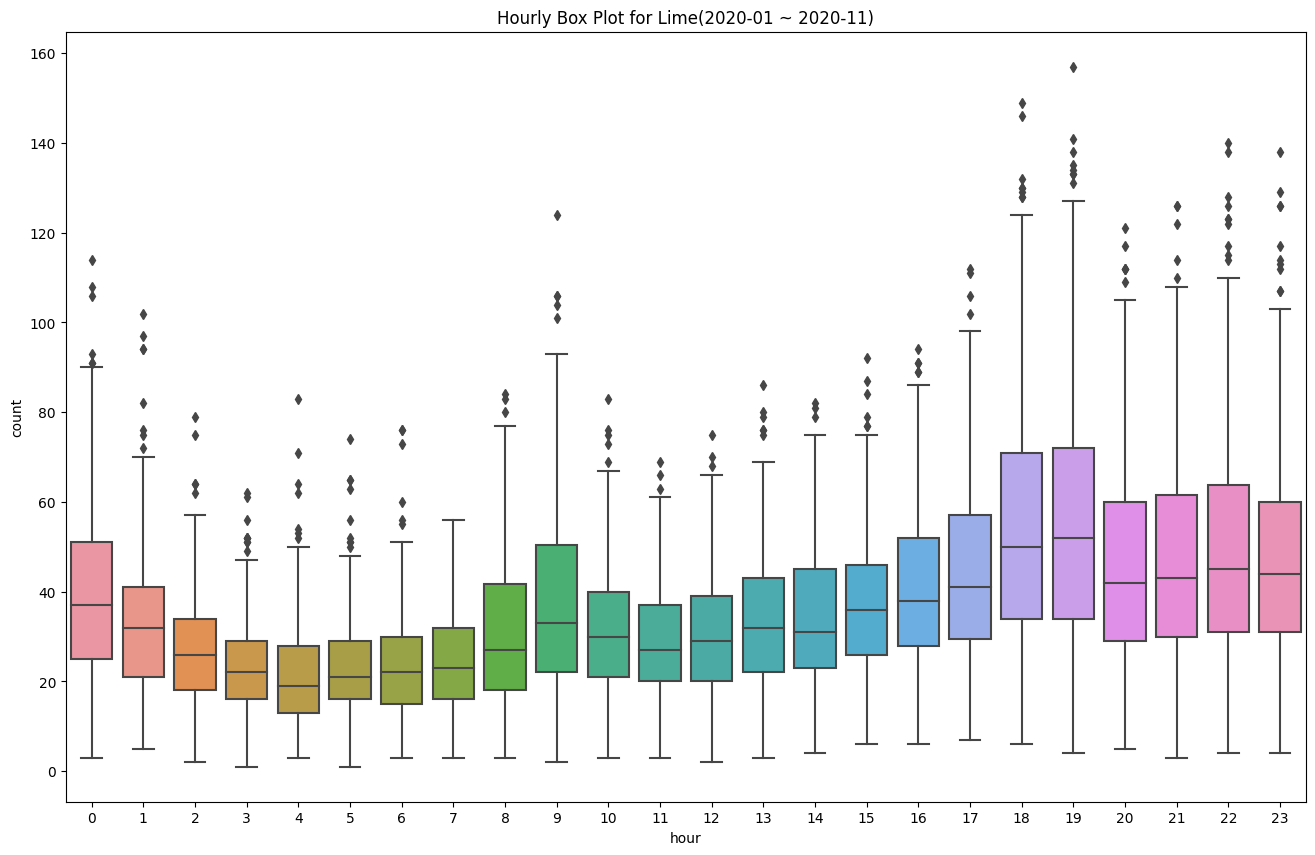

In [63]:
plt.figure(figsize=(16, 10));
sns.boxplot(x='hour', y='count', data=df_summary);
plt.title("Hourly Box Plot for Lime(2020-01 ~ 2020-11)");

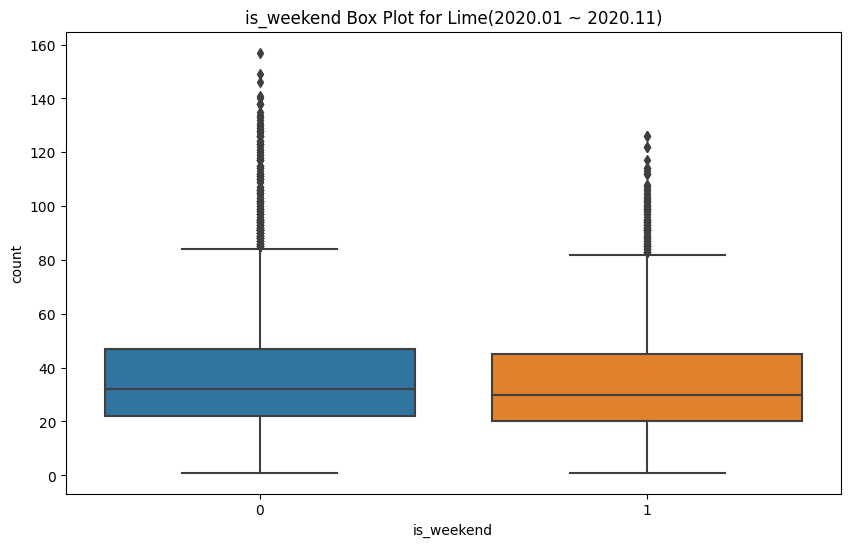

In [64]:
# 0 - weekday
# 1 - weekend
plt.figure(figsize=(10, 6));
sns.boxplot(x='is_weekend', y='count', data=df_summary);
plt.title("is_weekend Box Plot for Lime(2020.01 ~ 2020.11)");

In [65]:
df_summary.head()

date_hour  count  hour  month  weekday  day  is_weekend
0 2020-01-01 00:00:00     20     0      1        2    1           0
1 2020-01-01 01:00:00     34     1      1        2    1           0
2 2020-01-01 02:00:00     17     2      1        2    1           0
3 2020-01-01 03:00:00     21     3      1        2    1           0
4 2020-01-01 04:00:00     12     4      1        2    1           0

## 분기별 사용량 확인할 것
- df['Birth_quarter']       = df['Birth'].dt.quarter       # 분기(숫자) 이방식 사용
- 참고 사이트

In [66]:
def visualize_hourly_boxplot_by_month_num(df, y, month):
    plt.figure(figsize=(16, 6));
    sns.boxplot(x='hour', y=y, data=df[df['month']==month]);
    plt.title(f"Hourly Box Plot(2020-{month:02} Data)");

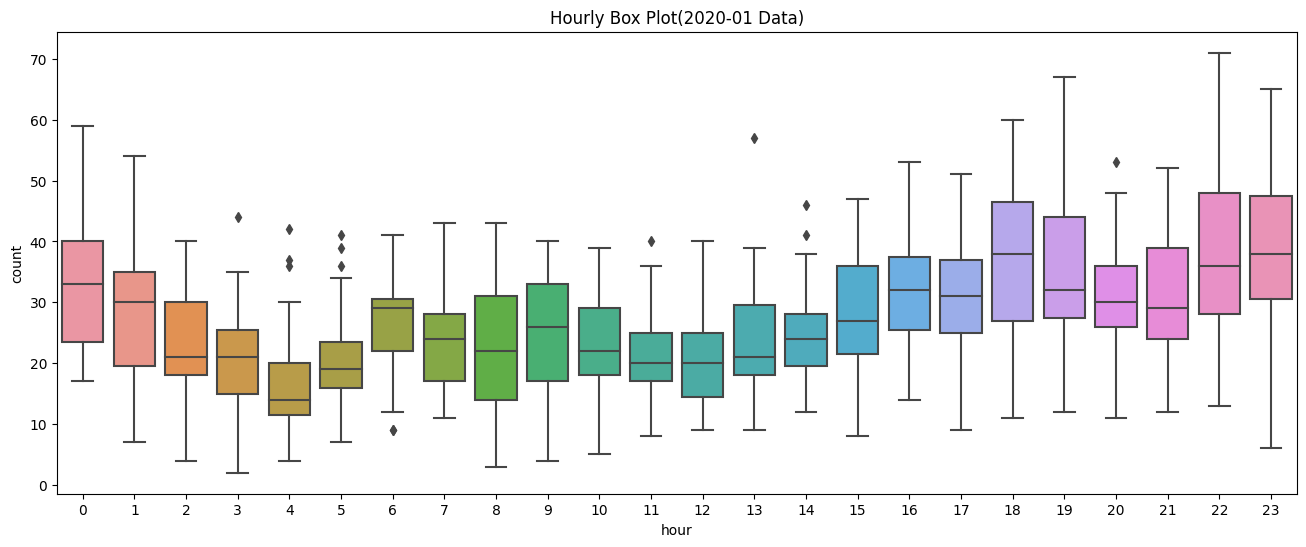

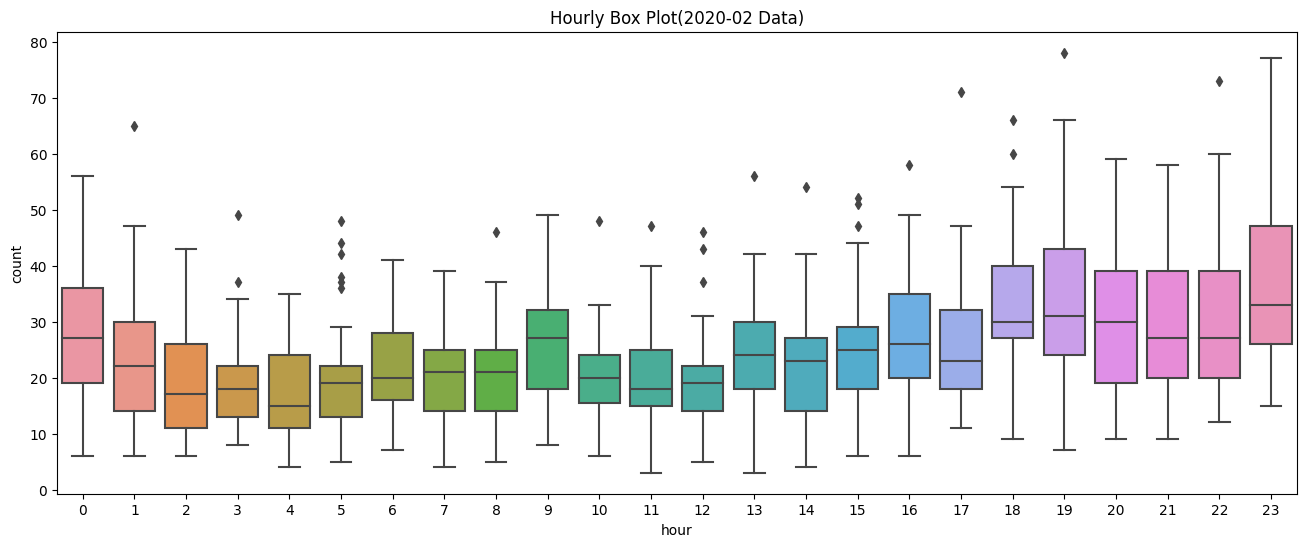

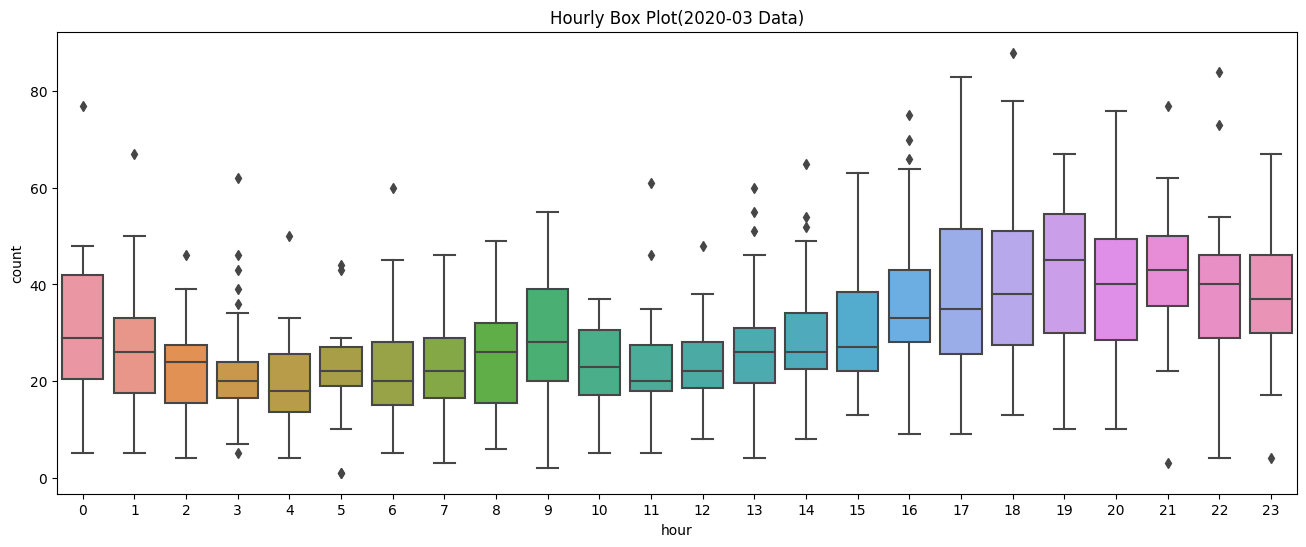

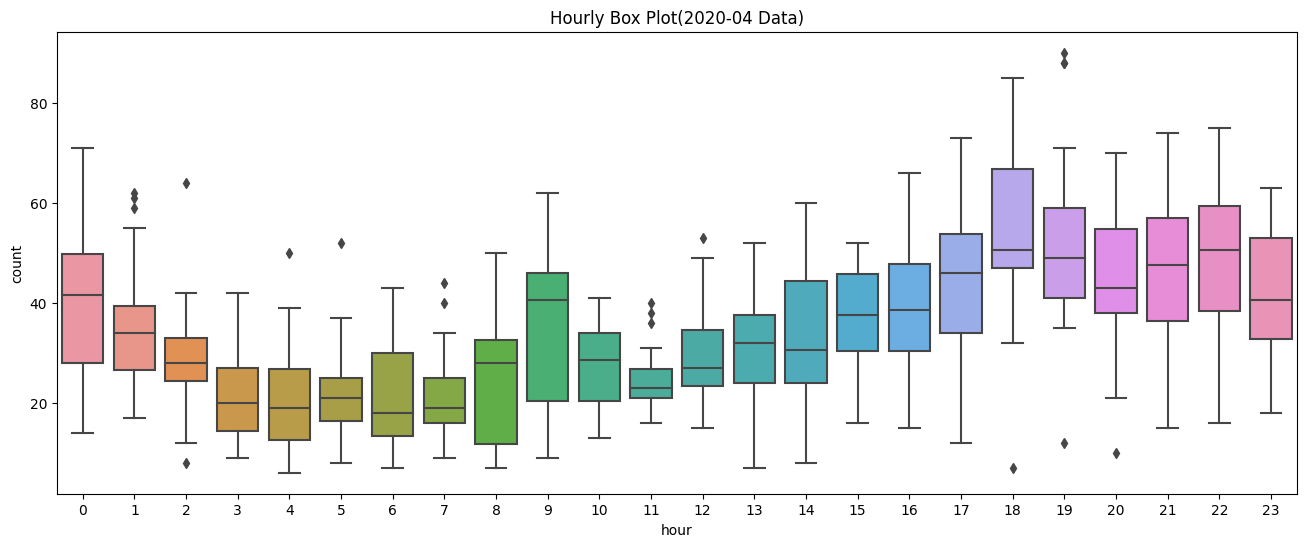

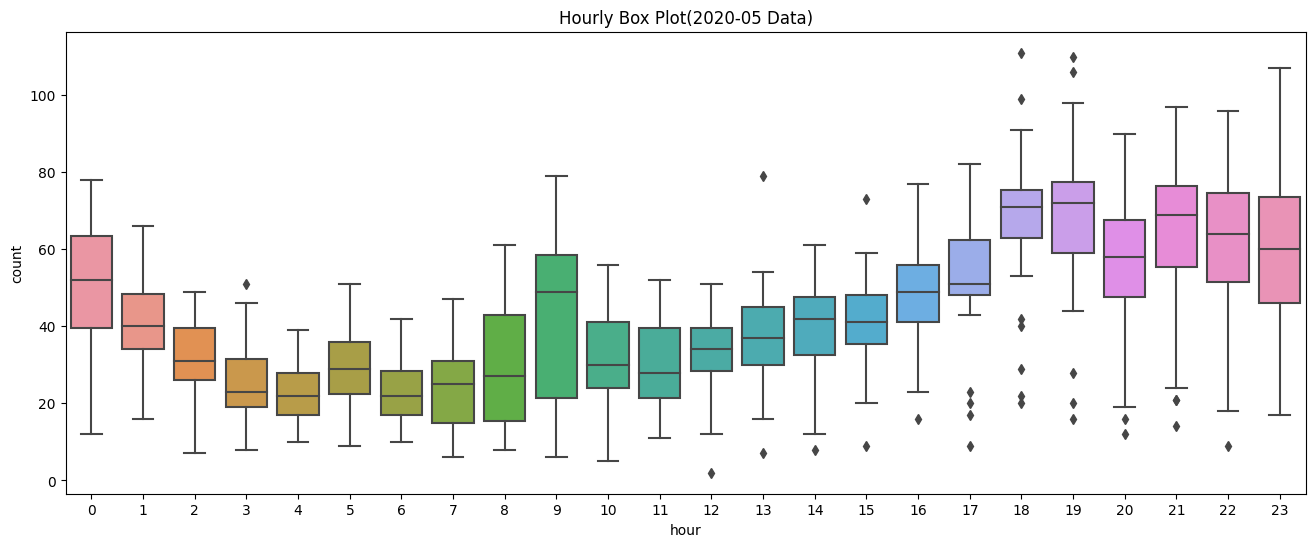

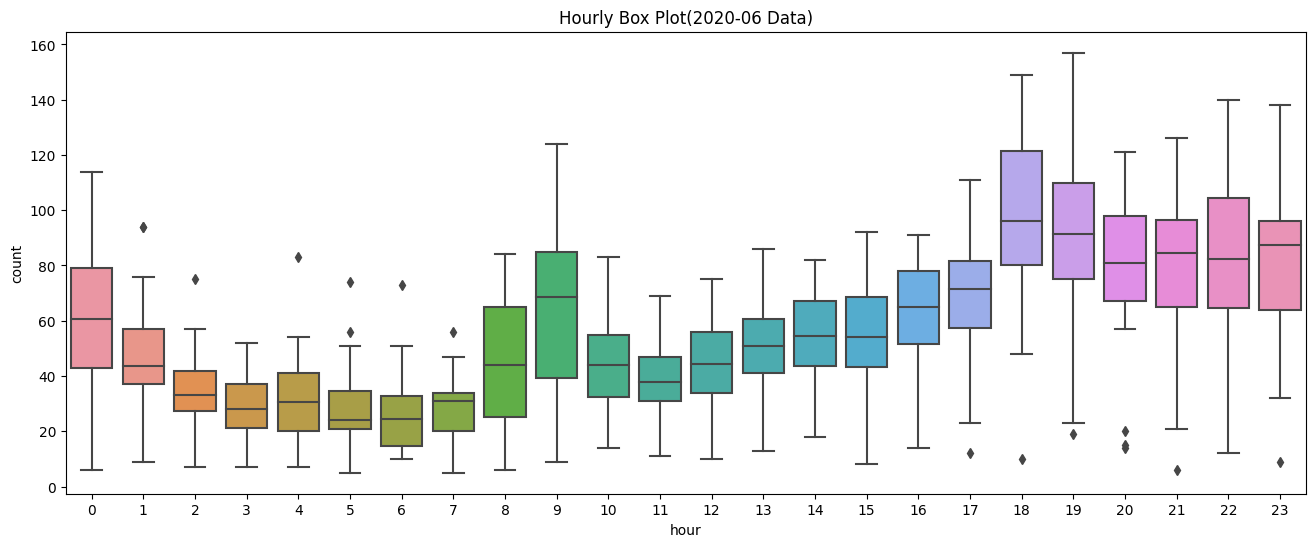

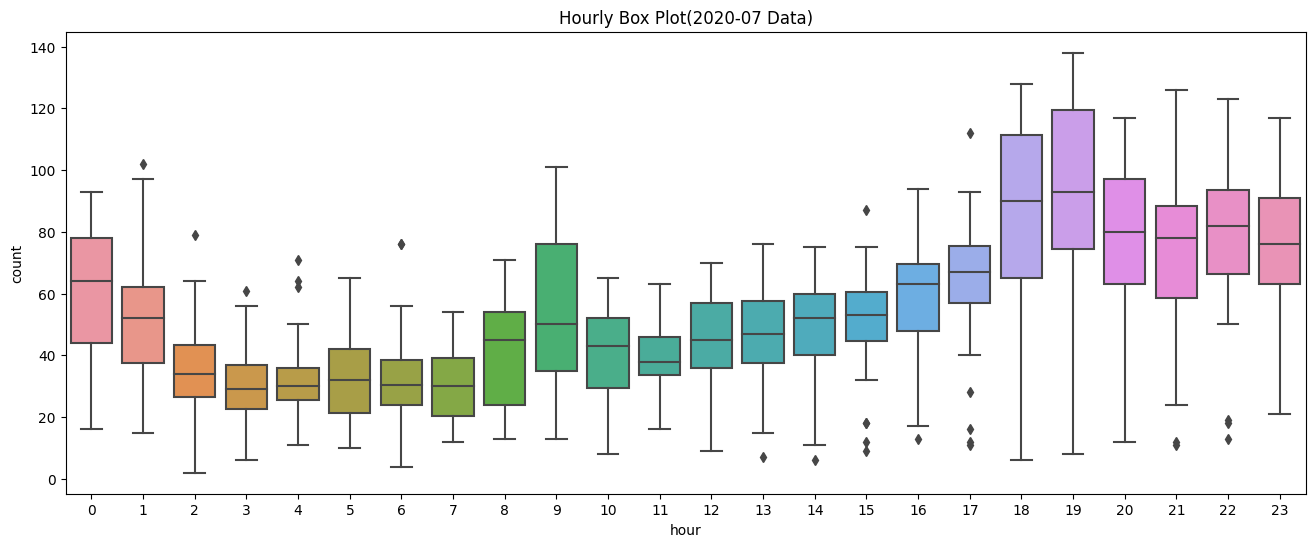

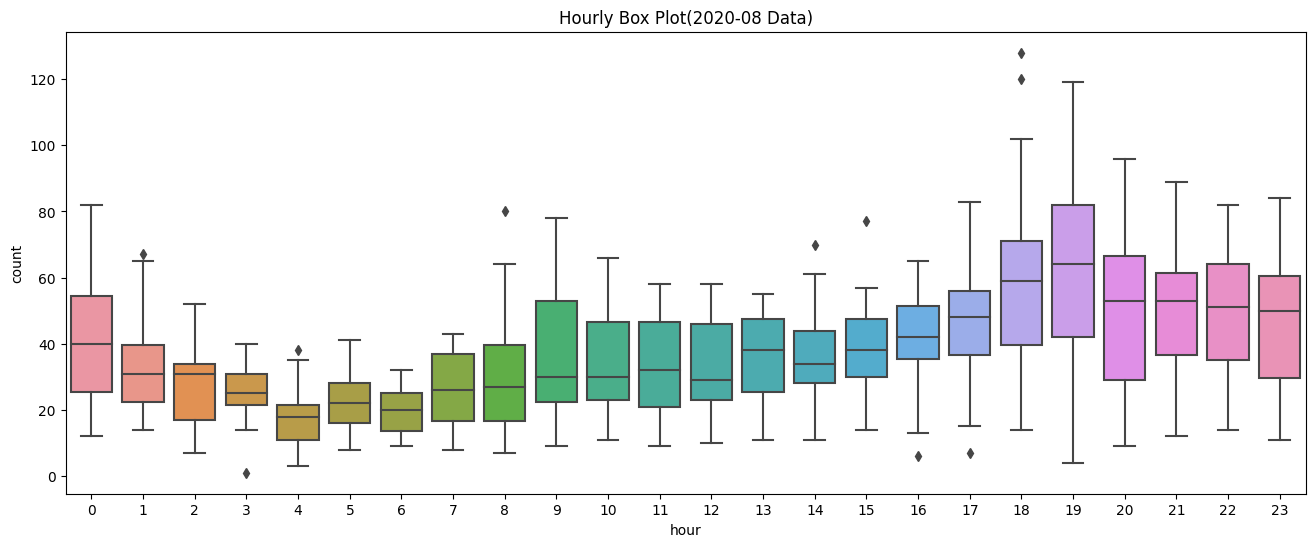

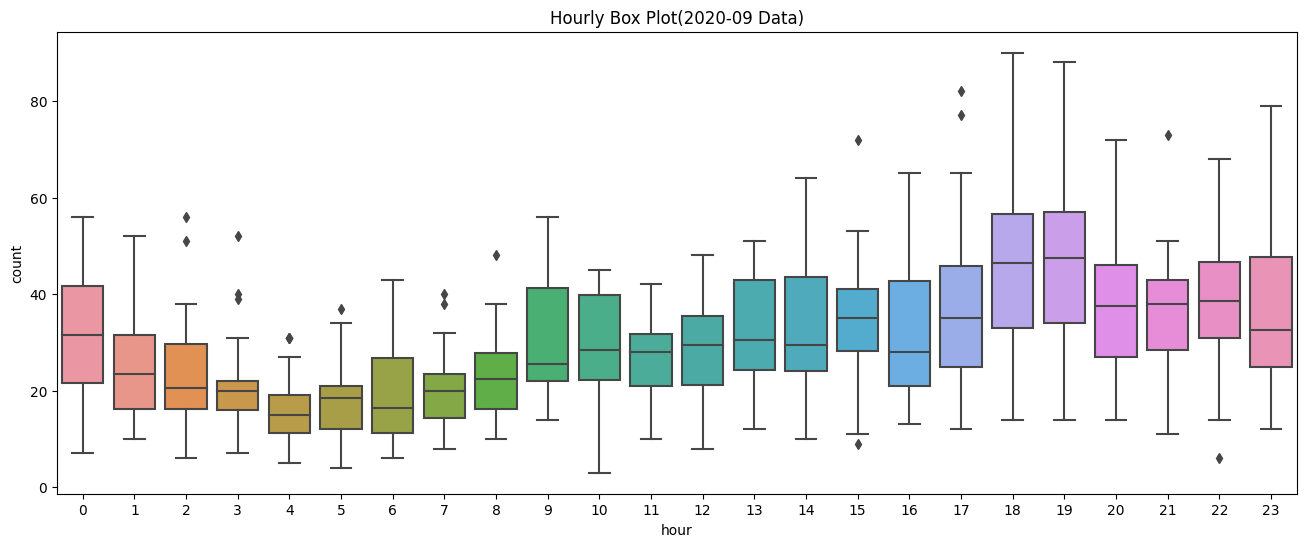

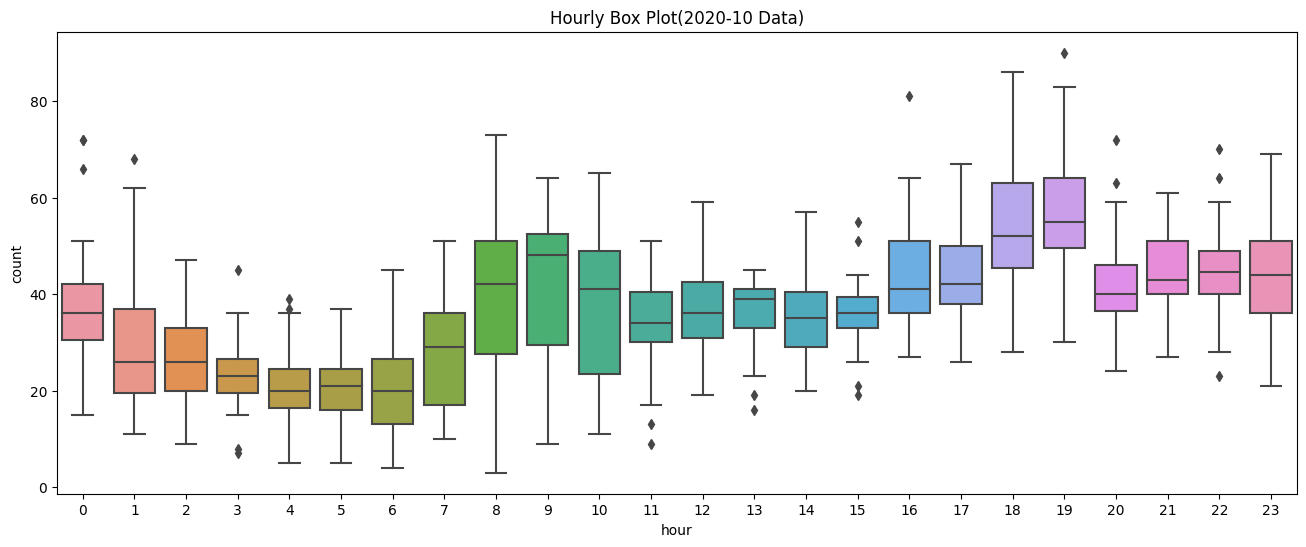

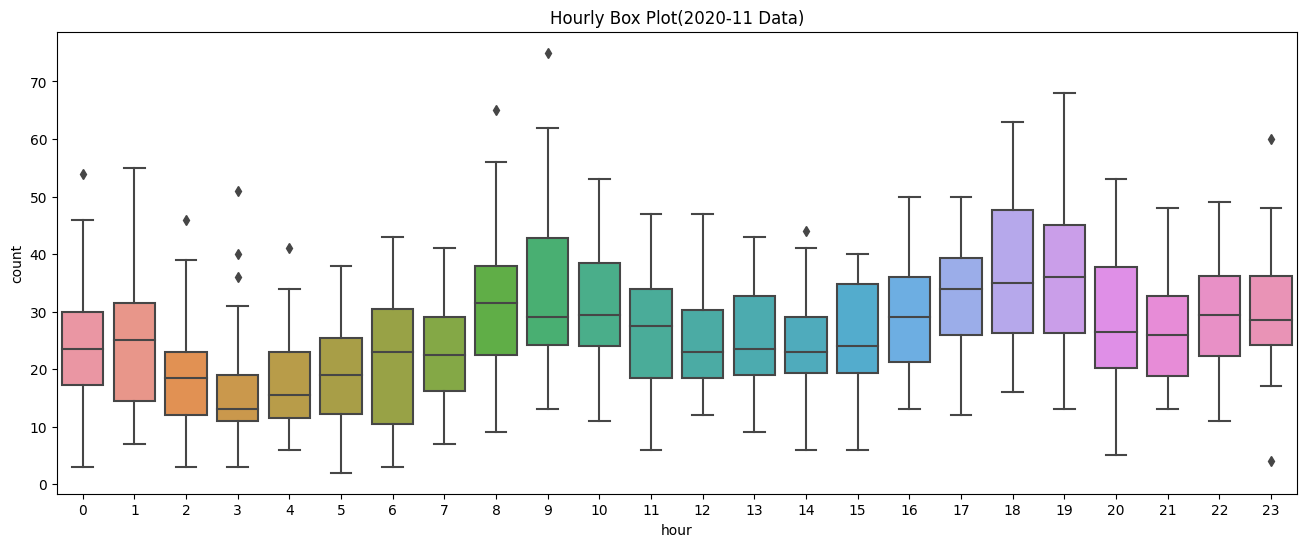

In [67]:
for month in range(1, 12):
    visualize_hourly_boxplot_by_month_num(df_summary, 'count', month)

## 바이올릿 플롯


In [68]:
# weekday_dict = {
#     0:"Monday",
#     1:"Tuesday",
#     2:"Wednesday",
#     3:"Thursday",
#     4:"Friday",
#     5:"Saturday",
#     6:"Sunday"
# }

# def visualize_violinplot_by_weekday(df, y, weekday):
#     plt.figure(figsize=(16, 6));
#     sns.violinplot(x="hour", y=y, hue="weekday", 
#                    data=df[df['weekday'] == weekday][['hour', 'weekday', y]],
#                    inner="quart");    
#     plt.title(f"{weekday_dict[weekday]}'s hourly violinplot {y}(2019-12 Data)")

In [69]:
# for weekday in range(0, 7):
#     visualize_violinplot_by_weekday(df_summary, 'count', weekday)

## 사용 거리 확인

In [70]:
# df_sorted['distance'].hist()

In [71]:
# li = []
# all_files = glob.glob("../data/*.csv")
# # all_files

# for filename in all_files:
#     df = pd.read_csv(filename, index_col=None, header=0)
#     li.append(df)

# df_distance = pd.concat(li, axis=0, ignore_index=True)

In [72]:
# df_distance = pd.read_csv("analyzed_lime_data_201912.csv")
# df_distance.head()

In [73]:
# df_sorted

- 출처: https://m.post.naver.com/viewer/postView.nhn?volumeNo=26022939&memberNo=12121295&searchKeyword=%EB%9D%BC%EC%9E%84&searchRank=7
- 제한 최고속도는 시속 15마일(약 22km/h)이다.
- 거리 = 속력 * 시간
- 10분으로 최대한 멀리 갈 수 있는 거리는 -> 22 * (10/60) = 3.6666666666666665 / 즉 3.6km 이다. 

In [74]:
df['distance'].describe()

count    290991.000000
mean       1437.152862
std        1488.597062
min         300.000226
25%         473.970083
50%         827.567183
75%        1864.041833
max       17267.447225
Name: distance, dtype: float64

In [75]:
# 300 ~ 915 (min ~ 50%)
# 915 ~ 1.6km (50% ~ 라스트 1마일)
# 1.6km ~  (즉, 1마일 이상)

cols = {'distance': ['300~800','800~1600','1600~'],
           'count': [0,0,0],
         }
df_sorted_distance = pd.DataFrame(cols)
df_sorted_distance.head()

distance  count
0   300~800      0
1  800~1600      0
2     1600~      0

In [76]:
df.head()

last_three        date hour  count     distance battery_level  \
505751        ZPC  2020-01-01    0    1.0  1167.965574           low   
505752        ZPC  2020-01-01    0    1.0  1180.154391          high   
505753        ZPC  2020-01-01    0    1.0  1180.154391           low   
487534        TUZ  2020-01-01    0    1.0  1229.257417          high   
484696        SVQ  2020-01-01    0    1.0   702.643026           low   

        date_hour  month  
505751 2020-01-01      1  
505752 2020-01-01      1  
505753 2020-01-01      1  
487534 2020-01-01      1  
484696 2020-01-01      1

In [77]:
df_sorted_distance.iloc[0:1, 1:2] = 0
df_sorted_distance.iloc[1:2, 1:2] = 0
df_sorted_distance.iloc[2:3, 1:2] = 0
# df_sorted_distance.iloc[3:4, 1:2] = 0

df_sorted_distance.head()

distance  count
0   300~800      0
1  800~1600      0
2     1600~      0

In [78]:

# distance	314039.0	1748.063174	1852.853587	300.000226	493.189956	915.495431	2336.414167	17267.447225	915.495431	
# 300 ~ 915
# 915 ~ 1.6km
# 1.6km ~  (즉, 1마일 이상)

for idx, val in enumerate(df['distance']):

    if val >= 300 and val <= 800:
        df_sorted_distance.iloc[0:1, 1:2] = df_sorted_distance.iloc[0:1, 1:2] + 1
    

    elif val > 800 and val <= 1600:
        df_sorted_distance.iloc[1:2, 1:2] = df_sorted_distance.iloc[1:2, 1:2] + 1       
    

    elif val > 1600:
        df_sorted_distance.iloc[2:3, 1:2] = df_sorted_distance.iloc[2:3, 1:2] + 1       

#     else:
#         df_sorted_distance.iloc[3:4, 1:2] = df_sorted_distance.iloc[3:4, 1:2] + 1
        

In [79]:
df_sorted_distance.head()

distance   count
0   300~800  141645
1  800~1600   66307
2     1600~   83039

<AxesSubplot:xlabel='distance', ylabel='count'>

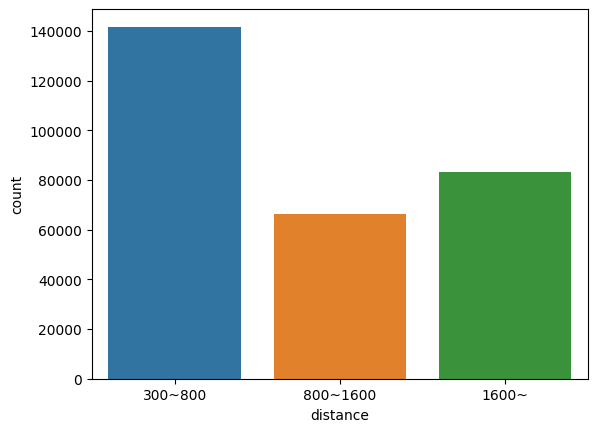

In [80]:
sns.barplot(x=df_sorted_distance['distance'], y=df_sorted_distance['count'])

In [81]:
df_sorted_distance.set_index('distance').iplot(kind='bar')

## 시간대별 단거리/중거리/장거리 사용 패턴
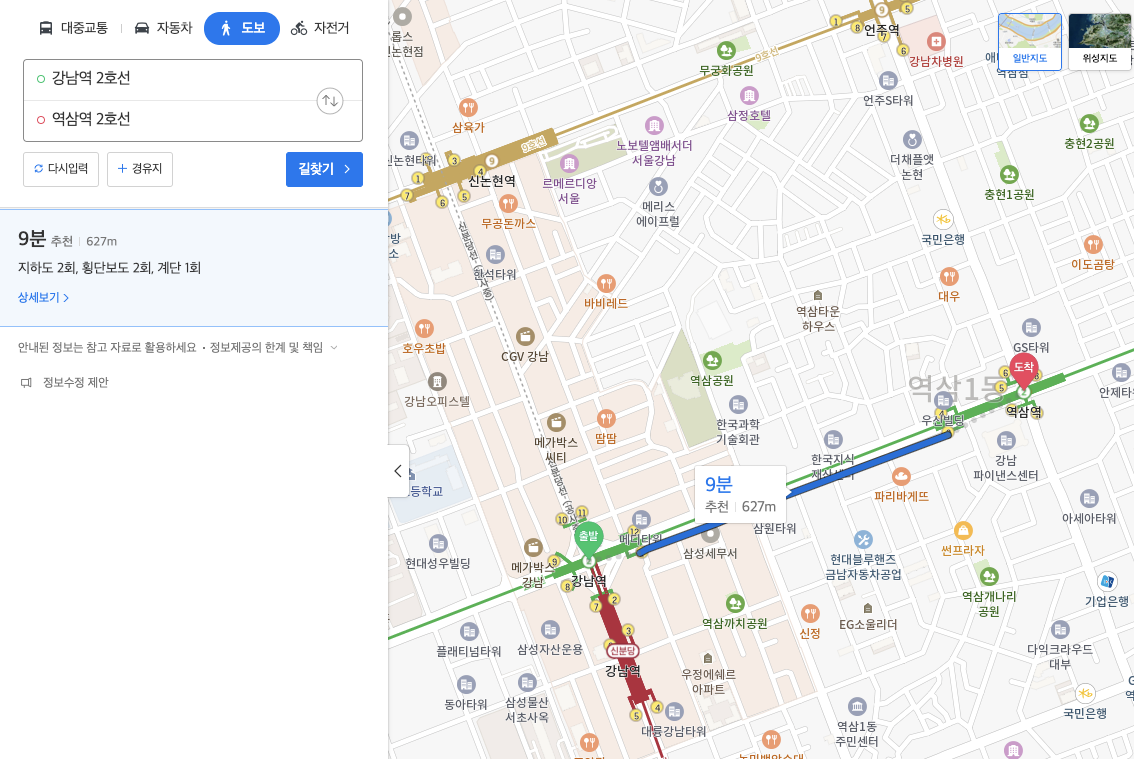

- 강남역 2호선 1번 출구 -> 역삼역 3번 출구 (약 627m)를 기준으로 해서
- 역 하나의 거리를 장거리라고 임의로 가정하고 분석했습니다.
- 단거리: 100M ~ 299M
- 중거리: 300M ~ 599M
- 장거리: 600M ~ 

In [82]:
cols = {'hour': list(range(24)),
        'short_distance': 0,
        'middle_distance':0,
        'long_distance': 0,
         }
df_time_distance = pd.DataFrame(cols)
df_time_distance.head()

hour  short_distance  middle_distance  long_distance
0     0               0                0              0
1     1               0                0              0
2     2               0                0              0
3     3               0                0              0
4     4               0                0              0

In [83]:
df_time_distance.head(24)

hour  short_distance  middle_distance  long_distance
0      0               0                0              0
1      1               0                0              0
2      2               0                0              0
3      3               0                0              0
4      4               0                0              0
5      5               0                0              0
6      6               0                0              0
7      7               0                0              0
8      8               0                0              0
9      9               0                0              0
10    10               0                0              0
11    11               0                0              0
12    12               0                0              0
13    13               0                0              0
14    14               0                0              0
15    15               0                0              0
16    16               0                0              0
17    17               0                0              0
18    18               0                0              0
19    19               0                0              0
20    20               0                0              0
21    21               0                0              0
22    22               0                0              0
23    23               0                0              0

In [84]:
# df_time_distance.loc[df_time_distance['hour'] == 22, 'short_distance'] = df_time_distance.loc[df_time_distance['hour'] == 22, 'short_distance'] + 1
# df_time_distance.head(24)

In [85]:
df.head()

last_three        date hour  count     distance battery_level  \
505751        ZPC  2020-01-01    0    1.0  1167.965574           low   
505752        ZPC  2020-01-01    0    1.0  1180.154391          high   
505753        ZPC  2020-01-01    0    1.0  1180.154391           low   
487534        TUZ  2020-01-01    0    1.0  1229.257417          high   
484696        SVQ  2020-01-01    0    1.0   702.643026           low   

        date_hour  month  
505751 2020-01-01      1  
505752 2020-01-01      1  
505753 2020-01-01      1  
487534 2020-01-01      1  
484696 2020-01-01      1

In [86]:
# 300 ~ 800
# 800 ~ 1.6km
# 1.6km ~  (즉, 1마일 이상)

for idx, val in enumerate(df[['hour','distance']].values):
#     if idx == 10:
#         break
    
    # 단거리 (short_distance)
    if val[1] > 300 and val[1] <= 800:
        df_time_distance.loc[df_time_distance['hour'] == int(val[0]), 'short_distance'] = df_time_distance.loc[df_time_distance['hour'] == int(val[0]), 'short_distance'] + 1
    
    # 중거리 (middle_distance)
    elif val[1] > 800 and val[1] <= 1600:
        df_time_distance.loc[df_time_distance['hour'] == int(val[0]), 'middle_distance'] = df_time_distance.loc[df_time_distance['hour'] == int(val[0]), 'middle_distance'] + 1
        
    
    # 장거리 (long_distance)
    else:
        df_time_distance.loc[df_time_distance['hour'] == int(val[0]), 'long_distance'] = df_time_distance.loc[df_time_distance['hour'] == int(val[0]), 'long_distance'] + 1

        
        

In [87]:
df_time_distance.head(24)

hour  short_distance  middle_distance  long_distance
0      0            6110             3326           3920
1      1            4999             2709           3504
2      2            4084             2156           2707
3      3            3371             1738           2667
4      4            3089             1586           2481
5      5            3345             1492           2950
6      6            3373             1540           2780
7      7            3845             1624           2697
8      8            5339             2181           2735
9      9            6753             2766           3266
10    10            5500             2305           2638
11    11            4940             2141           2548
12    12            5272             2390           2732
13    13            5657             2569           3059
14    14            5828             2682           3149
15    15            6000             2807           3484
16    16            6490             2999           4220
17    17            7282             3387           4185
18    18            9054             4608           4889
19    19            9305             4531           4893
20    20            7988             3543           4091
21    21            8319             3617           4047
22    22            8317             3912           4282
23    23            7385             3698           5115

In [88]:
def plt_clock(ax, radii, title, color):
    N = 24
    bottom = 2

    # 24시간을 위한 theta 생성
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

    # plot의 각각의 bin width 지정
    width = 2*np.pi / N
    
    bars = ax.bar(theta, radii, width=width, bottom=bottom, color=color, edgecolor="#999999")

    # label을 시계 방향으로 설정하고 위에서 시작
    ax.set_theta_zero_location("N")
    # 시계 방향 설정
    ax.set_theta_direction(-1)

    # label 설정
    ax.set_xticks(theta)
    ticks = ["{}:00".format(x) for x in range(24)]
    ax.set_xticklabels(ticks)
    ax.set_title(title)

In [89]:
def diff_short_long_trip_on_time(trip_df_pickup):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(18,18))

    # 2, 2의 첫번째에 그림
    ax = plt.subplot(2,2,1, polar=True)
    # 24시간의 각각의 bin에 히스토그램 그림
    radii = np.array(trip_df_pickup['short_distance'].tolist(), dtype="int64")
    title = "Pickup Time for Short Trips(300M ~ 800M)"
    plt_clock(ax, radii, title, "#dc143c")

    # 2, 2의 두번째에 그림
    ax = plt.subplot(2,2,2, polar=True)
    # 24시간의 각각의 bin에 히스토그램 그림
    radii = np.array(trip_df_pickup['middle_distance'].tolist(), dtype="int64")
    title = "Pickup Time for Middle Trips(800M ~ 1.6KM)"
    plt_clock(ax, radii, title, "#56B4E9")
    
    # 2, 3의 두번째에 그림
    ax = plt.subplot(2,2,3, polar=True)
    # 24시간의 각각의 bin에 히스토그램 그림
    radii = np.array(trip_df_pickup['long_distance'].tolist(), dtype="int64")
    title = "Pickup Time for Long Trips(1.6KM ~ )"
    plt_clock(ax, radii, title, "#dc143c")

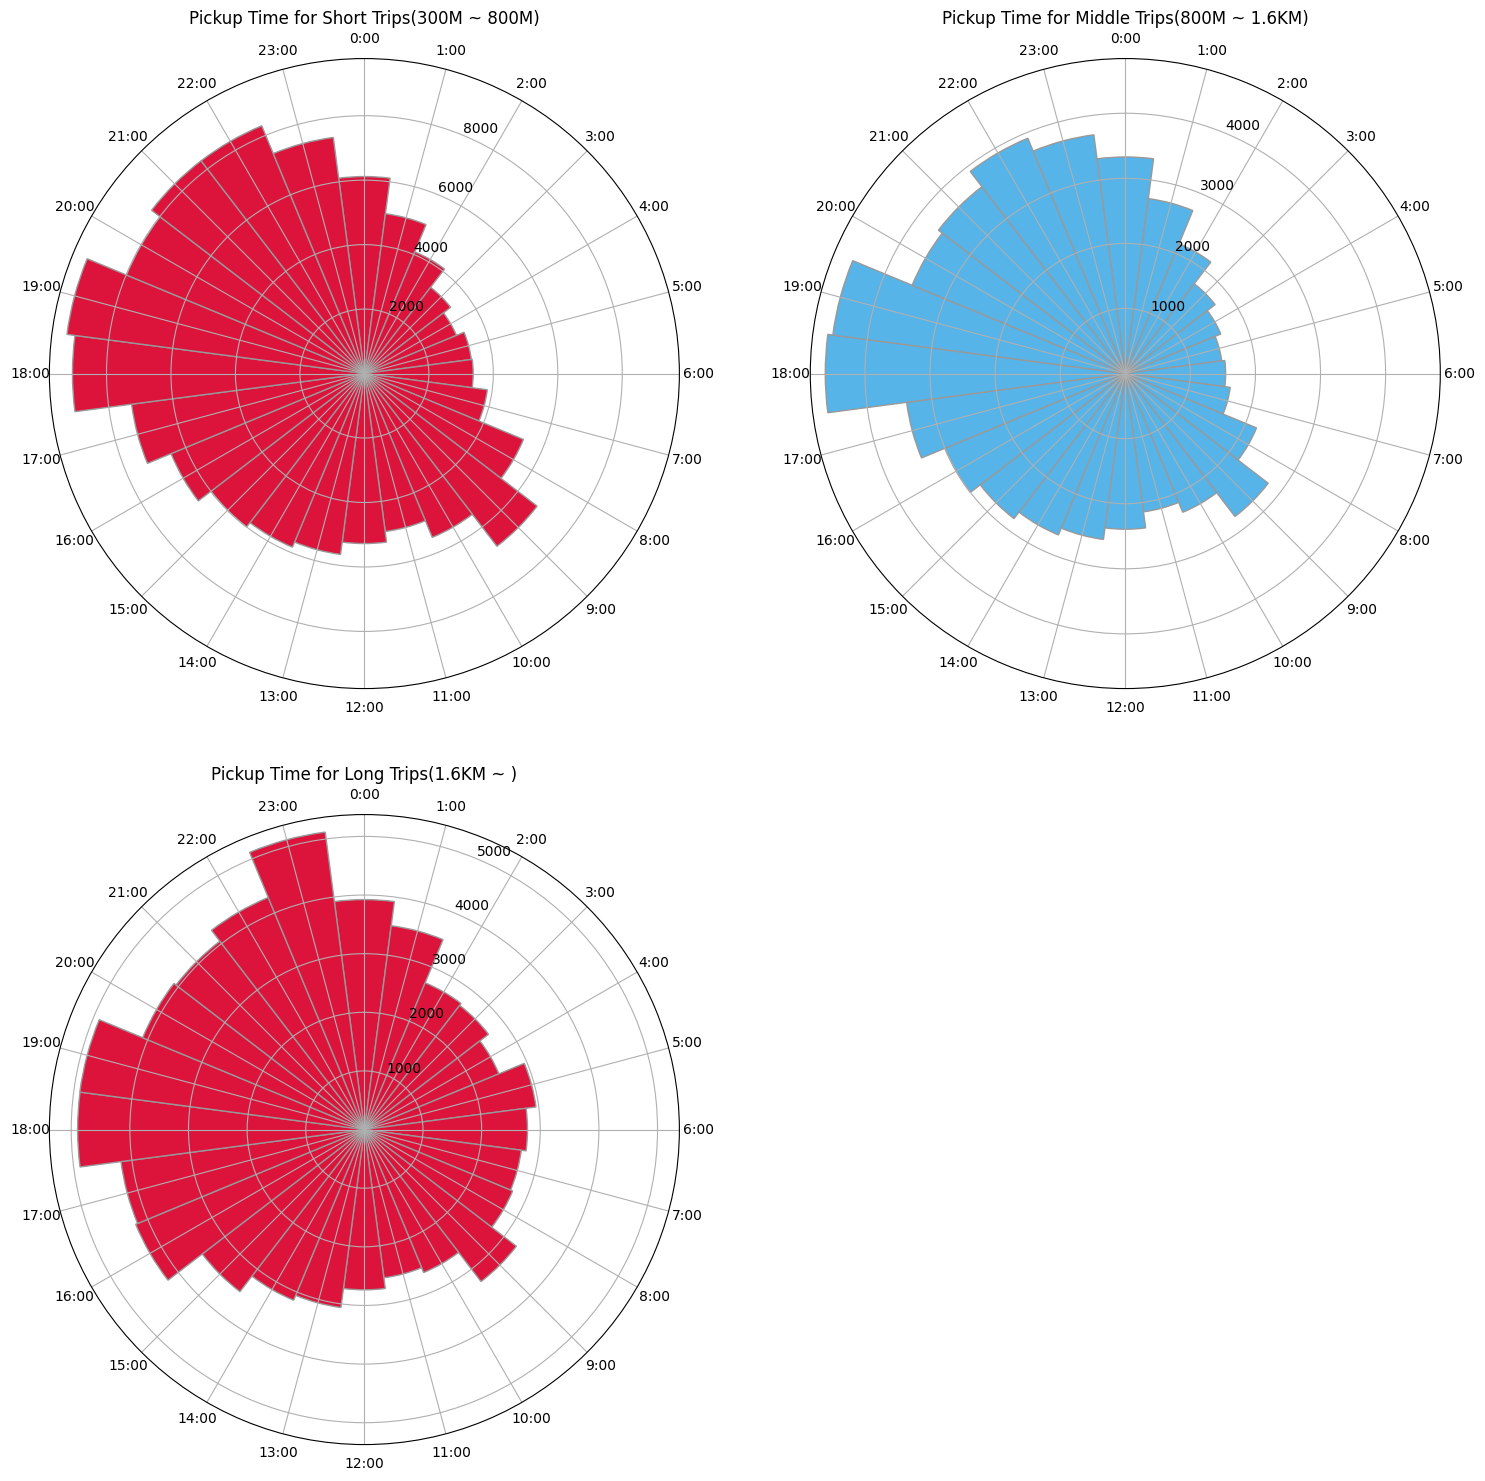

In [90]:
diff_short_long_trip_on_time(df_time_distance)

- 피크 타임
    - Short trip: 4:30 ~ 5:30 이긴 하지만 고루 사용중
    - Middle trip: 8:30 ~ 9:30 / 17:30 ~ 19:30 (출 근시, 퇴근시)
    - Long trip: 17:30 ~ 18:30 / 22:30 ~ 23:30 (퇴근길/지하철 끊길 시간 떄즘)

# 라임 데이터를 COVID-19 day 기준으로 count 처리

## 날짜는 2020.01.01 ~ 2020.11.30 까지

In [91]:
df.loc[df['date'] < '2020-12-01']

last_three        date hour  count     distance battery_level  \
505751        ZPC  2020-01-01    0    1.0  1167.965574           low   
505752        ZPC  2020-01-01    0    1.0  1180.154391          high   
505753        ZPC  2020-01-01    0    1.0  1180.154391           low   
487534        TUZ  2020-01-01    0    1.0  1229.257417          high   
484696        SVQ  2020-01-01    0    1.0   702.643026           low   
...           ...         ...  ...    ...          ...           ...   
392540        KXT  2020-11-30   23    1.0   378.310229          high   
411982        SMB  2020-11-30   23    1.0   482.175755        medium   
421040        VQD  2020-11-30   23    1.0   481.769489          high   
423450        WGF  2020-11-30   23    1.0  2471.016586          high   
362721        622  2020-11-30   23    1.0   551.061651        medium   

                 date_hour  month  
505751 2020-01-01 00:00:00      1  
505752 2020-01-01 00:00:00      1  
505753 2020-01-01 00:00:00      1  
487534 2020-01-01 00:00:00      1  
484696 2020-01-01 00:00:00      1  
...                    ...    ...  
392540 2020-11-30 23:00:00     11  
411982 2020-11-30 23:00:00     11  
421040 2020-11-30 23:00:00     11  
423450 2020-11-30 23:00:00     11  
362721 2020-11-30 23:00:00     11  

[290991 rows x 8 columns]

In [92]:
df_lime_cnt = pd.DataFrame(columns=['date','lime_count'])

df_temp = df.loc[df['date_hour'] < '2020-12-01']
# df_temp
df_lime_cnt['date'] = df_temp.date.value_counts().index
df_lime_cnt['lime_count'] = df_temp.date.value_counts().values
df_lime_cnt = df_lime_cnt.sort_values(by='date')
df_lime_cnt

date  lime_count
323  2020-01-01         381
275  2020-01-02         555
271  2020-01-03         584
236  2020-01-04         661
259  2020-01-05         615
..          ...         ...
302  2020-11-26         510
295  2020-11-27         521
318  2020-11-28         410
330  2020-11-29         326
326  2020-11-30         373

[335 rows x 2 columns]

In [93]:
# 요일 별 
# df_lime_cnt.groupby(['date'])[['count']].sum().iplot()

In [94]:
# !ls

# COVID-19 서울

In [95]:
df_covid = pd.read_csv("./data/COVID19-Seoul_2020-11-30.csv")
df_covid.head()

연번     확진일  환자번호  국적  환자정보    지역  여행력         접촉력  조치사항   상태  \
0  8966  11.30.   NaN NaN   NaN   강북구  NaN    감염경로 조사중   NaN  NaN   
1  8965  11.30.   NaN NaN   NaN   타시도  NaN   기타 확진자 접촉   NaN  NaN   
2  8964  11.30.   NaN NaN   NaN   타시도  NaN    감염경로 조사중   NaN  NaN   
3  8963  11.30.   NaN NaN   NaN  영등포구  NaN  서초구 사우나 관련   NaN   퇴원   
4  8962  11.30.   NaN NaN   NaN  영등포구  NaN    감염경로 조사중   NaN  NaN   

           이동경로                  등록일                  수정일 노출여부  month  day  \
0  이동경로 공개기간 경과  2020-12-19 10:32:41  2020-12-20 09:00:01    Y     11   30   
1  이동경로 공개기간 경과  2020-12-19 10:32:41  2020-12-20 09:00:01    Y     11   30   
2  이동경로 공개기간 경과  2020-12-19 10:32:41  2020-12-20 09:00:01    Y     11   30   
3  이동경로 공개기간 경과  2020-12-19 10:32:41  2020-12-20 09:00:01    Y     11   30   
4  이동경로 공개기간 경과  2020-12-19 10:32:41  2020-12-20 09:00:01    Y     11   30   

   year    datetime  count  
0  2020  2020-11-30      1  
1  2020  2020-11-30      1  
2  2020  2020-11-30      1  
3  2020  2020-11-30      1  
4  2020  2020-11-30      1

In [96]:
df_covid_cnt = pd.DataFrame(columns=['date','covid_count'])
df_covid_cnt['date'] = df_covid.datetime.value_counts().index
# df_covid_cnt['date'] = df_temp.date.value_counts().index

df_covid_cnt['covid_count'] = df_covid.datetime.value_counts().values
df_covid_cnt = df_covid_cnt.sort_values(by='date')
df_covid_cnt

date  covid_count
270  2020-01-24            1
248  2020-01-30            3
251  2020-01-31            3
272  2020-02-02            1
263  2020-02-05            2
..          ...          ...
1    2020-11-26          204
2    2020-11-27          178
6    2020-11-28          158
5    2020-11-29          159
9    2020-11-30          155

[283 rows x 2 columns]

In [97]:
df_temp = df_covid_cnt.loc[df_covid_cnt['date'] < '2020-12-01']
df_covid_cnt = df_temp


In [98]:
df_covid_cnt

date  covid_count
270  2020-01-24            1
248  2020-01-30            3
251  2020-01-31            3
272  2020-02-02            1
263  2020-02-05            2
..          ...          ...
1    2020-11-26          204
2    2020-11-27          178
6    2020-11-28          158
5    2020-11-29          159
9    2020-11-30          155

[283 rows x 2 columns]

In [99]:
df_all_count = pd.merge(df_lime_cnt, df_covid_cnt,
             how='outer',
             on='date')
df_all_count.head()

date  lime_count  covid_count
0  2020-01-01         381          NaN
1  2020-01-02         555          NaN
2  2020-01-03         584          NaN
3  2020-01-04         661          NaN
4  2020-01-05         615          NaN

In [100]:
df_all_count.query("covid_count > 0")


date  lime_count  covid_count
23   2020-01-24         722          1.0
29   2020-01-30         840          3.0
30   2020-01-31         807          3.0
32   2020-02-02         586          1.0
35   2020-02-05         538          2.0
..          ...         ...          ...
330  2020-11-26         510        204.0
331  2020-11-27         521        178.0
332  2020-11-28         410        158.0
333  2020-11-29         326        159.0
334  2020-11-30         373        155.0

[283 rows x 3 columns]

In [101]:
# 요일 별 COVID-19 서울시 환자수
df_all_count.groupby(['date'])[['covid_count']].sum().iplot()

# 라임 & COVID 19 비교

In [102]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_all_count[['lime_count', 'covid_count']])

In [103]:
df_all_count['covid_count_scaled'] = X_scaled[:,1:2]
df_all_count

date  lime_count  covid_count  covid_count_scaled
0    2020-01-01         381          NaN                 NaN
1    2020-01-02         555          NaN                 NaN
2    2020-01-03         584          NaN                 NaN
3    2020-01-04         661          NaN                 NaN
4    2020-01-05         615          NaN                 NaN
..          ...         ...          ...                 ...
330  2020-11-26         510        204.0            4.122164
331  2020-11-27         521        178.0            3.500196
332  2020-11-28         410        158.0            3.021759
333  2020-11-29         326        159.0            3.045681
334  2020-11-30         373        155.0            2.949994

[335 rows x 4 columns]

In [104]:
df_all_count['lime_count_scaled'] = X_scaled[:,0:1]
df_all_count

date  lime_count  covid_count  covid_count_scaled  \
0    2020-01-01         381          NaN                 NaN   
1    2020-01-02         555          NaN                 NaN   
2    2020-01-03         584          NaN                 NaN   
3    2020-01-04         661          NaN                 NaN   
4    2020-01-05         615          NaN                 NaN   
..          ...         ...          ...                 ...   
330  2020-11-26         510        204.0            4.122164   
331  2020-11-27         521        178.0            3.500196   
332  2020-11-28         410        158.0            3.021759   
333  2020-11-29         326        159.0            3.045681   
334  2020-11-30         373        155.0            2.949994   

     lime_count_scaled  
0            -1.487432  
1            -0.956674  
2            -0.868215  
3            -0.633340  
4            -0.773655  
..                 ...  
330          -1.093939  
331          -1.060386  
332          -1.398972  
333          -1.655200  
334          -1.511835  

[335 rows x 5 columns]

In [105]:
df_all_count

date  lime_count  covid_count  covid_count_scaled  \
0    2020-01-01         381          NaN                 NaN   
1    2020-01-02         555          NaN                 NaN   
2    2020-01-03         584          NaN                 NaN   
3    2020-01-04         661          NaN                 NaN   
4    2020-01-05         615          NaN                 NaN   
..          ...         ...          ...                 ...   
330  2020-11-26         510        204.0            4.122164   
331  2020-11-27         521        178.0            3.500196   
332  2020-11-28         410        158.0            3.021759   
333  2020-11-29         326        159.0            3.045681   
334  2020-11-30         373        155.0            2.949994   

     lime_count_scaled  
0            -1.487432  
1            -0.956674  
2            -0.868215  
3            -0.633340  
4            -0.773655  
..                 ...  
330          -1.093939  
331          -1.060386  
332          -1.398972  
333          -1.655200  
334          -1.511835  

[335 rows x 5 columns]

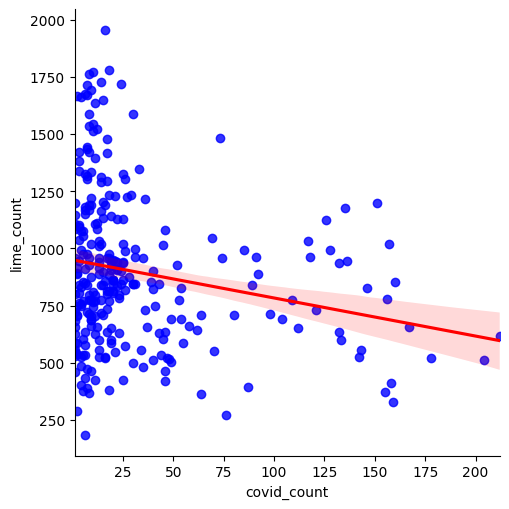

In [106]:
# 음영 부분: 선형회귀 직선의 95% 신뢰구간

sns.lmplot( x='covid_count', y='lime_count', data=df_all_count,
          scatter_kws = {"color": "blue"},
          line_kws = {"color": "red"})

In [107]:
df_all_count

date  lime_count  covid_count  covid_count_scaled  \
0    2020-01-01         381          NaN                 NaN   
1    2020-01-02         555          NaN                 NaN   
2    2020-01-03         584          NaN                 NaN   
3    2020-01-04         661          NaN                 NaN   
4    2020-01-05         615          NaN                 NaN   
..          ...         ...          ...                 ...   
330  2020-11-26         510        204.0            4.122164   
331  2020-11-27         521        178.0            3.500196   
332  2020-11-28         410        158.0            3.021759   
333  2020-11-29         326        159.0            3.045681   
334  2020-11-30         373        155.0            2.949994   

     lime_count_scaled  
0            -1.487432  
1            -0.956674  
2            -0.868215  
3            -0.633340  
4            -0.773655  
..                 ...  
330          -1.093939  
331          -1.060386  
332          -1.398972  
333          -1.655200  
334          -1.511835  

[335 rows x 5 columns]

In [108]:
df_all_count['covid_count'].fillna(0, inplace=True)
df_all_count

date  lime_count  covid_count  covid_count_scaled  \
0    2020-01-01         381          0.0                 NaN   
1    2020-01-02         555          0.0                 NaN   
2    2020-01-03         584          0.0                 NaN   
3    2020-01-04         661          0.0                 NaN   
4    2020-01-05         615          0.0                 NaN   
..          ...         ...          ...                 ...   
330  2020-11-26         510        204.0            4.122164   
331  2020-11-27         521        178.0            3.500196   
332  2020-11-28         410        158.0            3.021759   
333  2020-11-29         326        159.0            3.045681   
334  2020-11-30         373        155.0            2.949994   

     lime_count_scaled  
0            -1.487432  
1            -0.956674  
2            -0.868215  
3            -0.633340  
4            -0.773655  
..                 ...  
330          -1.093939  
331          -1.060386  
332          -1.398972  
333          -1.655200  
334          -1.511835  

[335 rows x 5 columns]

## 단순 선형 회귀분석

In [109]:
# fine_dust 뺴고 다시
df_reg = df_all_count[['lime_count', 'covid_count']]

df_kc_reg = sm.add_constant(df_reg, has_constant='add')
feature_columns = list(df_kc_reg.columns.difference(['lime_count']))

X = df_kc_reg[feature_columns]
y = df_kc_reg.lime_count

# 회귀 모델
multi_linear_model = sm.OLS(y, X)
result_model = multi_linear_model.fit()
result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lime_count   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     5.667
Date:                Mon, 21 Dec 2020   Prob (F-statistic):             0.0179
Time:                        11:51:27   Log-Likelihood:                -2413.0
No. Observations:                 335   AIC:                             4830.
Df Residuals:                     333   BIC:                             4838.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         896.9349     21.418     41.878      0.000     854.803     939.067
covid_count    -1.0576      0.444     -2.380      0.018      -1.931      -0.184
==============================================================================
Omnibus:                       27.006   Durbin-Watson:                   0.501
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.171
Skew:                           0.728   Prob(JB):                     1.70e-07
Kurtosis:                       3.337   Cond. No.                         58.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [110]:
# from sklearn.linear_model import LinearRegression
# model = LinearRegression()  # 생성자 -> 객체 생성 
# model.fit(X, y)  # x=2~4번째 칼럼, y=1번째 칼럼 

# model.coef_        # 기울기 = [ 0.73784755,  0.79386389, -0.74633658] 
# model.intercept_  # 절편 = 1.4952262783130337 

<AxesSubplot:>

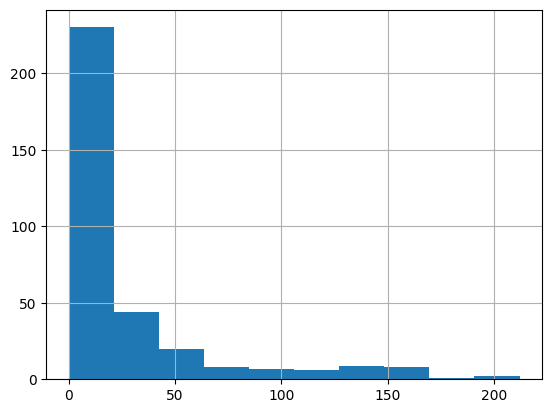

In [111]:
df_all_count['covid_count'].hist()

- R-squred 값으로는 

# 따릉이

In [112]:
df_bike = pd.read_csv("./data/Edited_Bike-Seoul_Gangnam3_2018_202001_06.csv")
df_bike.head()

자전거번호                 대여일시  대여 대여소번호                   대여 대여소명  대여거치대  \
0  SPB-03796  2018-01-01 00:00:42      2219   고속터미널역 8-1번, 8-2번 출구 사이     15   
1  SPB-09976  2018-01-01 00:02:15      2248              서초리슈빌S 글로벌 앞      1   
2  SPB-10413  2018-01-01 00:02:26      2306              압구정역 2번 출구 옆      1   
3  SPB-09931  2018-01-01 00:05:08      1224             아시아지하보도 2번 출구     11   
4  SPB-12972  2018-01-01 00:05:33      1245                  문정 법조단지9      4   

                  반납일시  반납대여소번호           반납대여소명  반납거치대  이용시간    이용거리  대여소번호  \
0  2018-01-01 00:25:41     3511         응봉역 1번출구      9  24.0  7670.0   2219   
1  2018-01-01 00:05:48     2250        서초유치원 맞은편     10   3.0   950.0   2248   
2  2018-01-01 00:28:05      509      이마트 버스정류소 옆     16  25.0  3900.0   2306   
3  2018-01-01 00:36:50     2341   일원역 4~5번 출구 사이      1  30.0  5140.0   1224   
4  2018-01-01 00:29:08     1271            송파도서관     11  22.0  3140.0   1245   

   month  day  hour  weekday  year                 date  count  
0      1    1     0        0  2018  2018-01-01 00:00:00      1  
1      1    1     0        0  2018  2018-01-01 00:00:00      1  
2      1    1     0        0  2018  2018-01-01 00:00:00      1  
3      1    1     0        0  2018  2018-01-01 00:00:00      1  
4      1    1     0        0  2018  2018-01-01 00:00:00      1

In [113]:
df_bike_cnt = pd.DataFrame(columns=['date','bike_cnt'])
df_bike_cnt['date'] = df_bike.date.value_counts().index
df_bike_cnt['bike_cnt'] = df_bike.date.value_counts().values
df_bike_cnt = df_bike_cnt.sort_values(by='date')
df_bike_cnt

date  bike_cnt
849  2018-01-01 00:00:00       693
824  2018-01-02 00:00:00       916
826  2018-01-03 00:00:00       886
831  2018-01-04 00:00:00       865
825  2018-01-05 00:00:00       907
..                   ...       ...
604  2020-06-26 00:00:00      3557
593  2020-06-27 00:00:00      3655
627  2020-06-28 00:00:00      3329
759  2020-06-29 00:00:00      1869
694  2020-06-30 00:00:00      2616

[890 rows x 2 columns]

In [114]:
df_bike_cnt = df_bike_cnt.loc[(df_bike_cnt['date'] >= '2020-01-01') & (df_bike_cnt['date'] < '2020-07-02')]

In [115]:
# list(df_bike_cnt['lime_count'].values)

In [116]:
df_bike_cnt

date  bike_cnt
735  2020-01-01 00:00:00      2197
547  2020-01-02 00:00:00      4106
519  2020-01-03 00:00:00      4333
594  2020-01-04 00:00:00      3649
624  2020-01-05 00:00:00      3347
..                   ...       ...
604  2020-06-26 00:00:00      3557
593  2020-06-27 00:00:00      3655
627  2020-06-28 00:00:00      3329
759  2020-06-29 00:00:00      1869
694  2020-06-30 00:00:00      2616

[182 rows x 2 columns]

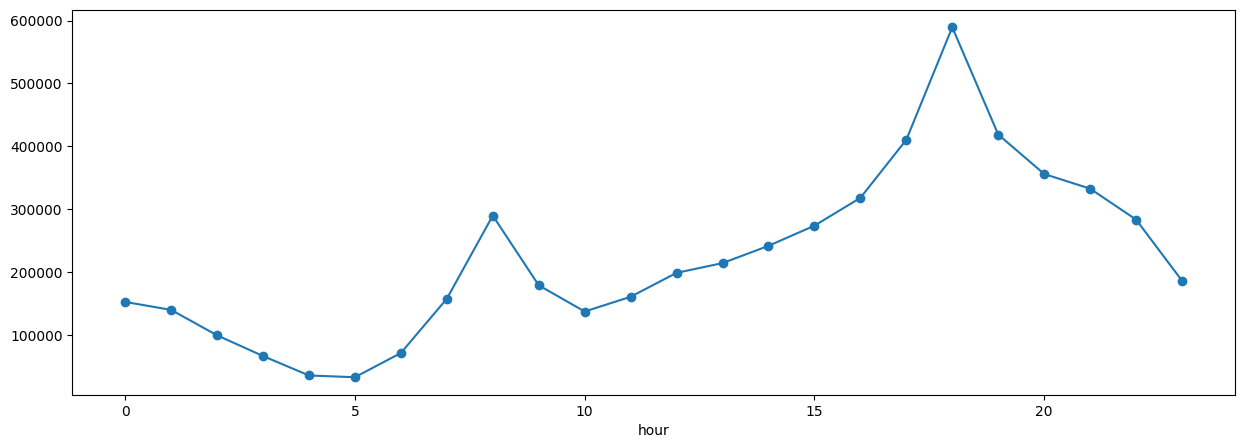

In [117]:
df_bike.groupby('hour')['count'].sum().plot(x='date_hour', y='count', kind='line', style="-o", figsize=(15,5));

In [118]:
df_bike

자전거번호                 대여일시  대여 대여소번호                   대여 대여소명  \
0        SPB-03796  2018-01-01 00:00:42      2219   고속터미널역 8-1번, 8-2번 출구 사이   
1        SPB-09976  2018-01-01 00:02:15      2248              서초리슈빌S 글로벌 앞   
2        SPB-10413  2018-01-01 00:02:26      2306              압구정역 2번 출구 옆   
3        SPB-09931  2018-01-01 00:05:08      1224             아시아지하보도 2번 출구   
4        SPB-12972  2018-01-01 00:05:33      1245                  문정 법조단지9   
...            ...                  ...       ...                       ...   
5341948  SPB-09653  2020-06-30 23:57:22      1209           잠실나루역 (2번 출구 쪽)   
5341949  SPB-33726  2020-06-30 23:58:28      2387               래미안강남힐즈 사거리   
5341950  SPB-32555  2020-06-30 23:58:39      2431                  대치역 7번출구   
5341951  SPB-19867  2020-06-30 23:58:41      1222             잠실새내역 5번 출구 뒤   
5341952  SPB-33361  2020-06-30 23:59:46      2279                 교대역 5번출구뒤   

         대여거치대                 반납일시  반납대여소번호              반납대여소명  반납거치대  이용시간  \
0           15  2018-01-01 00:25:41     3511            응봉역 1번출구      9  24.0   
1            1  2018-01-01 00:05:48     2250           서초유치원 맞은편     10   3.0   
2            1  2018-01-01 00:28:05      509         이마트 버스정류소 옆     16  25.0   
3           11  2018-01-01 00:36:50     2341      일원역 4~5번 출구 사이      1  30.0   
4            4  2018-01-01 00:29:08     1271               송파도서관     11  22.0   
...        ...                  ...      ...                 ...    ...   ...   
5341948     19  2020-07-01 00:12:55     1211               방이삼거리      5  14.0   
5341949      0  2020-07-01 00:05:40     2426        강남한신휴플러스 6단지      0   7.0   
5341950      0  2020-07-01 00:17:26     2340  삼호물산버스정류장(23370) 옆      0  19.0   
5341951     14  2020-07-01 00:19:52     1259            방이역 1번출구     10  20.0   
5341952      0  2020-07-01 00:06:20     2233        서초신동아1차아파트 옆      0   7.0   

            이용거리  대여소번호  month  day  hour  weekday  year                 date  \
0        7670.00   2219      1    1     0        0  2018  2018-01-01 00:00:00   
1         950.00   2248      1    1     0        0  2018  2018-01-01 00:00:00   
2        3900.00   2306      1    1     0        0  2018  2018-01-01 00:00:00   
3        5140.00   1224      1    1     0        0  2018  2018-01-01 00:00:00   
4        3140.00   1245      1    1     0        0  2018  2018-01-01 00:00:00   
...          ...    ...    ...  ...   ...      ...   ...                  ...   
5341948  1100.00   1209      6   30    23        1  2020  2020-06-30 00:00:00   
5341949  1137.96   2387      6   30    23        1  2020  2020-06-30 00:00:00   
5341950  3051.20   2431      6   30    23        1  2020  2020-06-30 00:00:00   
5341951  4410.00   1222      6   30    23        1  2020  2020-06-30 00:00:00   
5341952   974.14   2279      6   30    23        1  2020  2020-06-30 00:00:00   

         count  
0            1  
1            1  
2            1  
3            1  
4            1  
...        ...  
5341948      1  
5341949      1  
5341950      1  
5341951      1  
5341952      1  

[5341953 rows x 19 columns]

In [119]:
# 요일 별 
df_bike.groupby(['date'])[['count']].sum().iplot()

# 라임과 따릉이 같이 비교

In [120]:
df_lime_cnt

date  lime_count
323  2020-01-01         381
275  2020-01-02         555
271  2020-01-03         584
236  2020-01-04         661
259  2020-01-05         615
..          ...         ...
302  2020-11-26         510
295  2020-11-27         521
318  2020-11-28         410
330  2020-11-29         326
326  2020-11-30         373

[335 rows x 2 columns]

In [121]:
df_lime_cnt_tmp = df_lime_cnt.loc[df_lime_cnt['date'] < '2020-07-01']

In [122]:
df_lime_cnt_tmp['bike_cnt'] = list(df_bike_cnt['bike_cnt'].values)

In [123]:
df_lime_cnt_tmp

date  lime_count  bike_cnt
323  2020-01-01         381      2197
275  2020-01-02         555      4106
271  2020-01-03         584      4333
236  2020-01-04         661      3649
259  2020-01-05         615      3347
..          ...         ...       ...
26   2020-06-26        1418      3557
35   2020-06-27        1314      3655
34   2020-06-28        1318      3329
107  2020-06-29         959      1869
230  2020-06-30         687      2616

[182 rows x 3 columns]

In [124]:
# df_bike_cnt.loc[(df_bike_cnt['date'] >= '2020-01-01') & (df_bike_cnt['date'] < '2020-07-02')]

In [125]:
# # 범위 조정
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()

In [126]:
df_lime_cnt_tmp

date  lime_count  bike_cnt
323  2020-01-01         381      2197
275  2020-01-02         555      4106
271  2020-01-03         584      4333
236  2020-01-04         661      3649
259  2020-01-05         615      3347
..          ...         ...       ...
26   2020-06-26        1418      3557
35   2020-06-27        1314      3655
34   2020-06-28        1318      3329
107  2020-06-29         959      1869
230  2020-06-30         687      2616

[182 rows x 3 columns]

In [127]:
X_scaled = scaler.fit_transform(df_lime_cnt_tmp[['lime_count','bike_cnt']])

In [128]:
df_lime_cnt_tmp['mobile_count_scaled'] = X_scaled[:,0:1]
df_lime_cnt_tmp['bike_count_scaled'] = X_scaled[:,1:2]
df_lime_cnt_tmp

date  lime_count  bike_cnt  mobile_count_scaled  bike_count_scaled
323  2020-01-01         381      2197            -1.439190          -1.197608
275  2020-01-02         555      4106            -0.913178          -0.374716
271  2020-01-03         584      4333            -0.825510          -0.276866
236  2020-01-04         661      3649            -0.592735          -0.571710
259  2020-01-05         615      3347            -0.731795          -0.701890
..          ...         ...       ...                  ...                ...
26   2020-06-26        1418      3557             1.695718          -0.611368
35   2020-06-27        1314      3655             1.381320          -0.569124
34   2020-06-28        1318      3329             1.393412          -0.709649
107  2020-06-29         959      1869             0.308136          -1.338996
230  2020-06-30         687      2616            -0.514135          -1.016994

[182 rows x 5 columns]

In [129]:
# 요일 별 라임 사용량과 따릉이 사용량 비교
df_lime_cnt_tmp.groupby(['date'])[['lime_count', 'bike_cnt']].sum().iplot()

In [130]:
# 요일 별 라임 사용량과 따릉이 사용량 비교
df_lime_cnt_tmp.groupby(['date'])[['mobile_count_scaled', 'bike_count_scaled']].sum().iplot()

# 라임, 따릉이, COVID 3개 전부 비교

In [131]:
df_all_count 

date  lime_count  covid_count  covid_count_scaled  \
0    2020-01-01         381          0.0                 NaN   
1    2020-01-02         555          0.0                 NaN   
2    2020-01-03         584          0.0                 NaN   
3    2020-01-04         661          0.0                 NaN   
4    2020-01-05         615          0.0                 NaN   
..          ...         ...          ...                 ...   
330  2020-11-26         510        204.0            4.122164   
331  2020-11-27         521        178.0            3.500196   
332  2020-11-28         410        158.0            3.021759   
333  2020-11-29         326        159.0            3.045681   
334  2020-11-30         373        155.0            2.949994   

     lime_count_scaled  
0            -1.487432  
1            -0.956674  
2            -0.868215  
3            -0.633340  
4            -0.773655  
..                 ...  
330          -1.093939  
331          -1.060386  
332          -1.398972  
333          -1.655200  
334          -1.511835  

[335 rows x 5 columns]

In [132]:
df_all_count_tmp = df_all_count.loc[df_all_count['date'] < '2020-07-01']

In [133]:
df_all_count_tmp['bike_cnt'] = list(df_bike_cnt['bike_cnt'].values)

In [134]:
df_all_count_tmp

date  lime_count  covid_count  covid_count_scaled  \
0    2020-01-01         381          0.0                 NaN   
1    2020-01-02         555          0.0                 NaN   
2    2020-01-03         584          0.0                 NaN   
3    2020-01-04         661          0.0                 NaN   
4    2020-01-05         615          0.0                 NaN   
..          ...         ...          ...                 ...   
177  2020-06-26        1418         17.0           -0.351220   
178  2020-06-27        1314         14.0           -0.422985   
179  2020-06-28        1318          7.0           -0.590438   
180  2020-06-29         959          8.0           -0.566516   
181  2020-06-30         687          9.0           -0.542595   

     lime_count_scaled  bike_cnt  
0            -1.487432      2197  
1            -0.956674      4106  
2            -0.868215      4333  
3            -0.633340      3649  
4            -0.773655      3347  
..                 ...       ...  
177           1.675760      3557  
178           1.358526      3655  
179           1.370727      3329  
180           0.275659      1869  
181          -0.554031      2616  

[182 rows x 6 columns]

In [135]:
X_scaled = scaler.fit_transform(df_all_count_tmp[['lime_count','bike_cnt', 'covid_count']])

In [136]:
df_all_count_tmp

date  lime_count  covid_count  covid_count_scaled  \
0    2020-01-01         381          0.0                 NaN   
1    2020-01-02         555          0.0                 NaN   
2    2020-01-03         584          0.0                 NaN   
3    2020-01-04         661          0.0                 NaN   
4    2020-01-05         615          0.0                 NaN   
..          ...         ...          ...                 ...   
177  2020-06-26        1418         17.0           -0.351220   
178  2020-06-27        1314         14.0           -0.422985   
179  2020-06-28        1318          7.0           -0.590438   
180  2020-06-29         959          8.0           -0.566516   
181  2020-06-30         687          9.0           -0.542595   

     lime_count_scaled  bike_cnt  
0            -1.487432      2197  
1            -0.956674      4106  
2            -0.868215      4333  
3            -0.633340      3649  
4            -0.773655      3347  
..                 ...       ...  
177           1.675760      3557  
178           1.358526      3655  
179           1.370727      3329  
180           0.275659      1869  
181          -0.554031      2616  

[182 rows x 6 columns]

In [137]:
X_scaled

array([[-1.43918987, -1.19760819, -0.89742215],
       [-0.91317839, -0.37471604, -0.89742215],
       [-0.82550981, -0.27686558, -0.89742215],
       [-0.59273461, -0.57171013, -0.89742215],
       [-0.73179512, -0.70189003, -0.89742215],
       [-0.96154726, -1.19760819, -0.89742215],
       [-1.52685845, -2.03386318, -0.89742215],
       [-1.03410056, -0.82129345, -0.89742215],
       [-0.36902858, -0.33462752, -0.89742215],
       [-0.42344356, -0.33678282, -0.89742215],
       [-0.50808909, -0.68680295, -0.89742215],
       [-1.21850689, -0.92431661, -0.89742215],
       [-0.7862101 , -0.47817026, -0.89742215],
       [-0.82853286, -0.30272914, -0.89742215],
       [-0.65924181, -0.35876684, -0.89742215],
       [-0.57459628, -0.27126181, -0.89742215],
       [-0.65017265, -0.1846189 , -0.89742215],
       [ 0.26883592, -0.58248661, -0.89742215],
       [-0.64412654, -1.08725702, -0.89742215],
       [-1.04921584, -0.41911514, -0.89742215],
       [-0.50204298, -0.19841279, -0.897

In [138]:
# X_scaled[:,2:3]

In [139]:
df_all_count_tmp['lime_count_scaled'] = X_scaled[:,0:1]
df_all_count_tmp['bike_count_scaled'] = X_scaled[:,1:2]
df_all_count_tmp['covid_count_scaled'] = X_scaled[:,2:3]
df_all_count_tmp

date  lime_count  covid_count  covid_count_scaled  \
0    2020-01-01         381          0.0           -0.897422   
1    2020-01-02         555          0.0           -0.897422   
2    2020-01-03         584          0.0           -0.897422   
3    2020-01-04         661          0.0           -0.897422   
4    2020-01-05         615          0.0           -0.897422   
..          ...         ...          ...                 ...   
177  2020-06-26        1418         17.0            1.202899   
178  2020-06-27        1314         14.0            0.832254   
179  2020-06-28        1318          7.0           -0.032584   
180  2020-06-29         959          8.0            0.090964   
181  2020-06-30         687          9.0            0.214512   

     lime_count_scaled  bike_cnt  bike_count_scaled  
0            -1.439190      2197          -1.197608  
1            -0.913178      4106          -0.374716  
2            -0.825510      4333          -0.276866  
3            -0.592735      3649          -0.571710  
4            -0.731795      3347          -0.701890  
..                 ...       ...                ...  
177           1.695718      3557          -0.611368  
178           1.381320      3655          -0.569124  
179           1.393412      3329          -0.709649  
180           0.308136      1869          -1.338996  
181          -0.514135      2616          -1.016994  

[182 rows x 7 columns]

In [140]:
# df_all_count_tmp['bike_count_scaled'] = X_scaled[:,2:3]
# df_all_count_tmp

In [141]:
# 요일 별 라임 사용량과 따릉이 사용량 비교
df_all_count_tmp.groupby(['date'])[['lime_count', 'bike_cnt','covid_count']].sum().iplot()

In [142]:
# 요일 별 라임 사용량과 따릉이 사용량 비교
df_all_count_tmp.groupby(['date'])[['lime_count_scaled', 'bike_count_scaled', 'covid_count_scaled']].sum().iplot()

# 다중 선형 회귀

## 독립변수 및 종속변수
- y: 라임 킥보드 사용 횟수
- X
    - 따릉이 사용량
    - 코로나 count
    - 서울시 일별 평균온도
    - 강수량
    - 비/비안온날
    - 미세먼지

## 서울시 일별 평균 온도
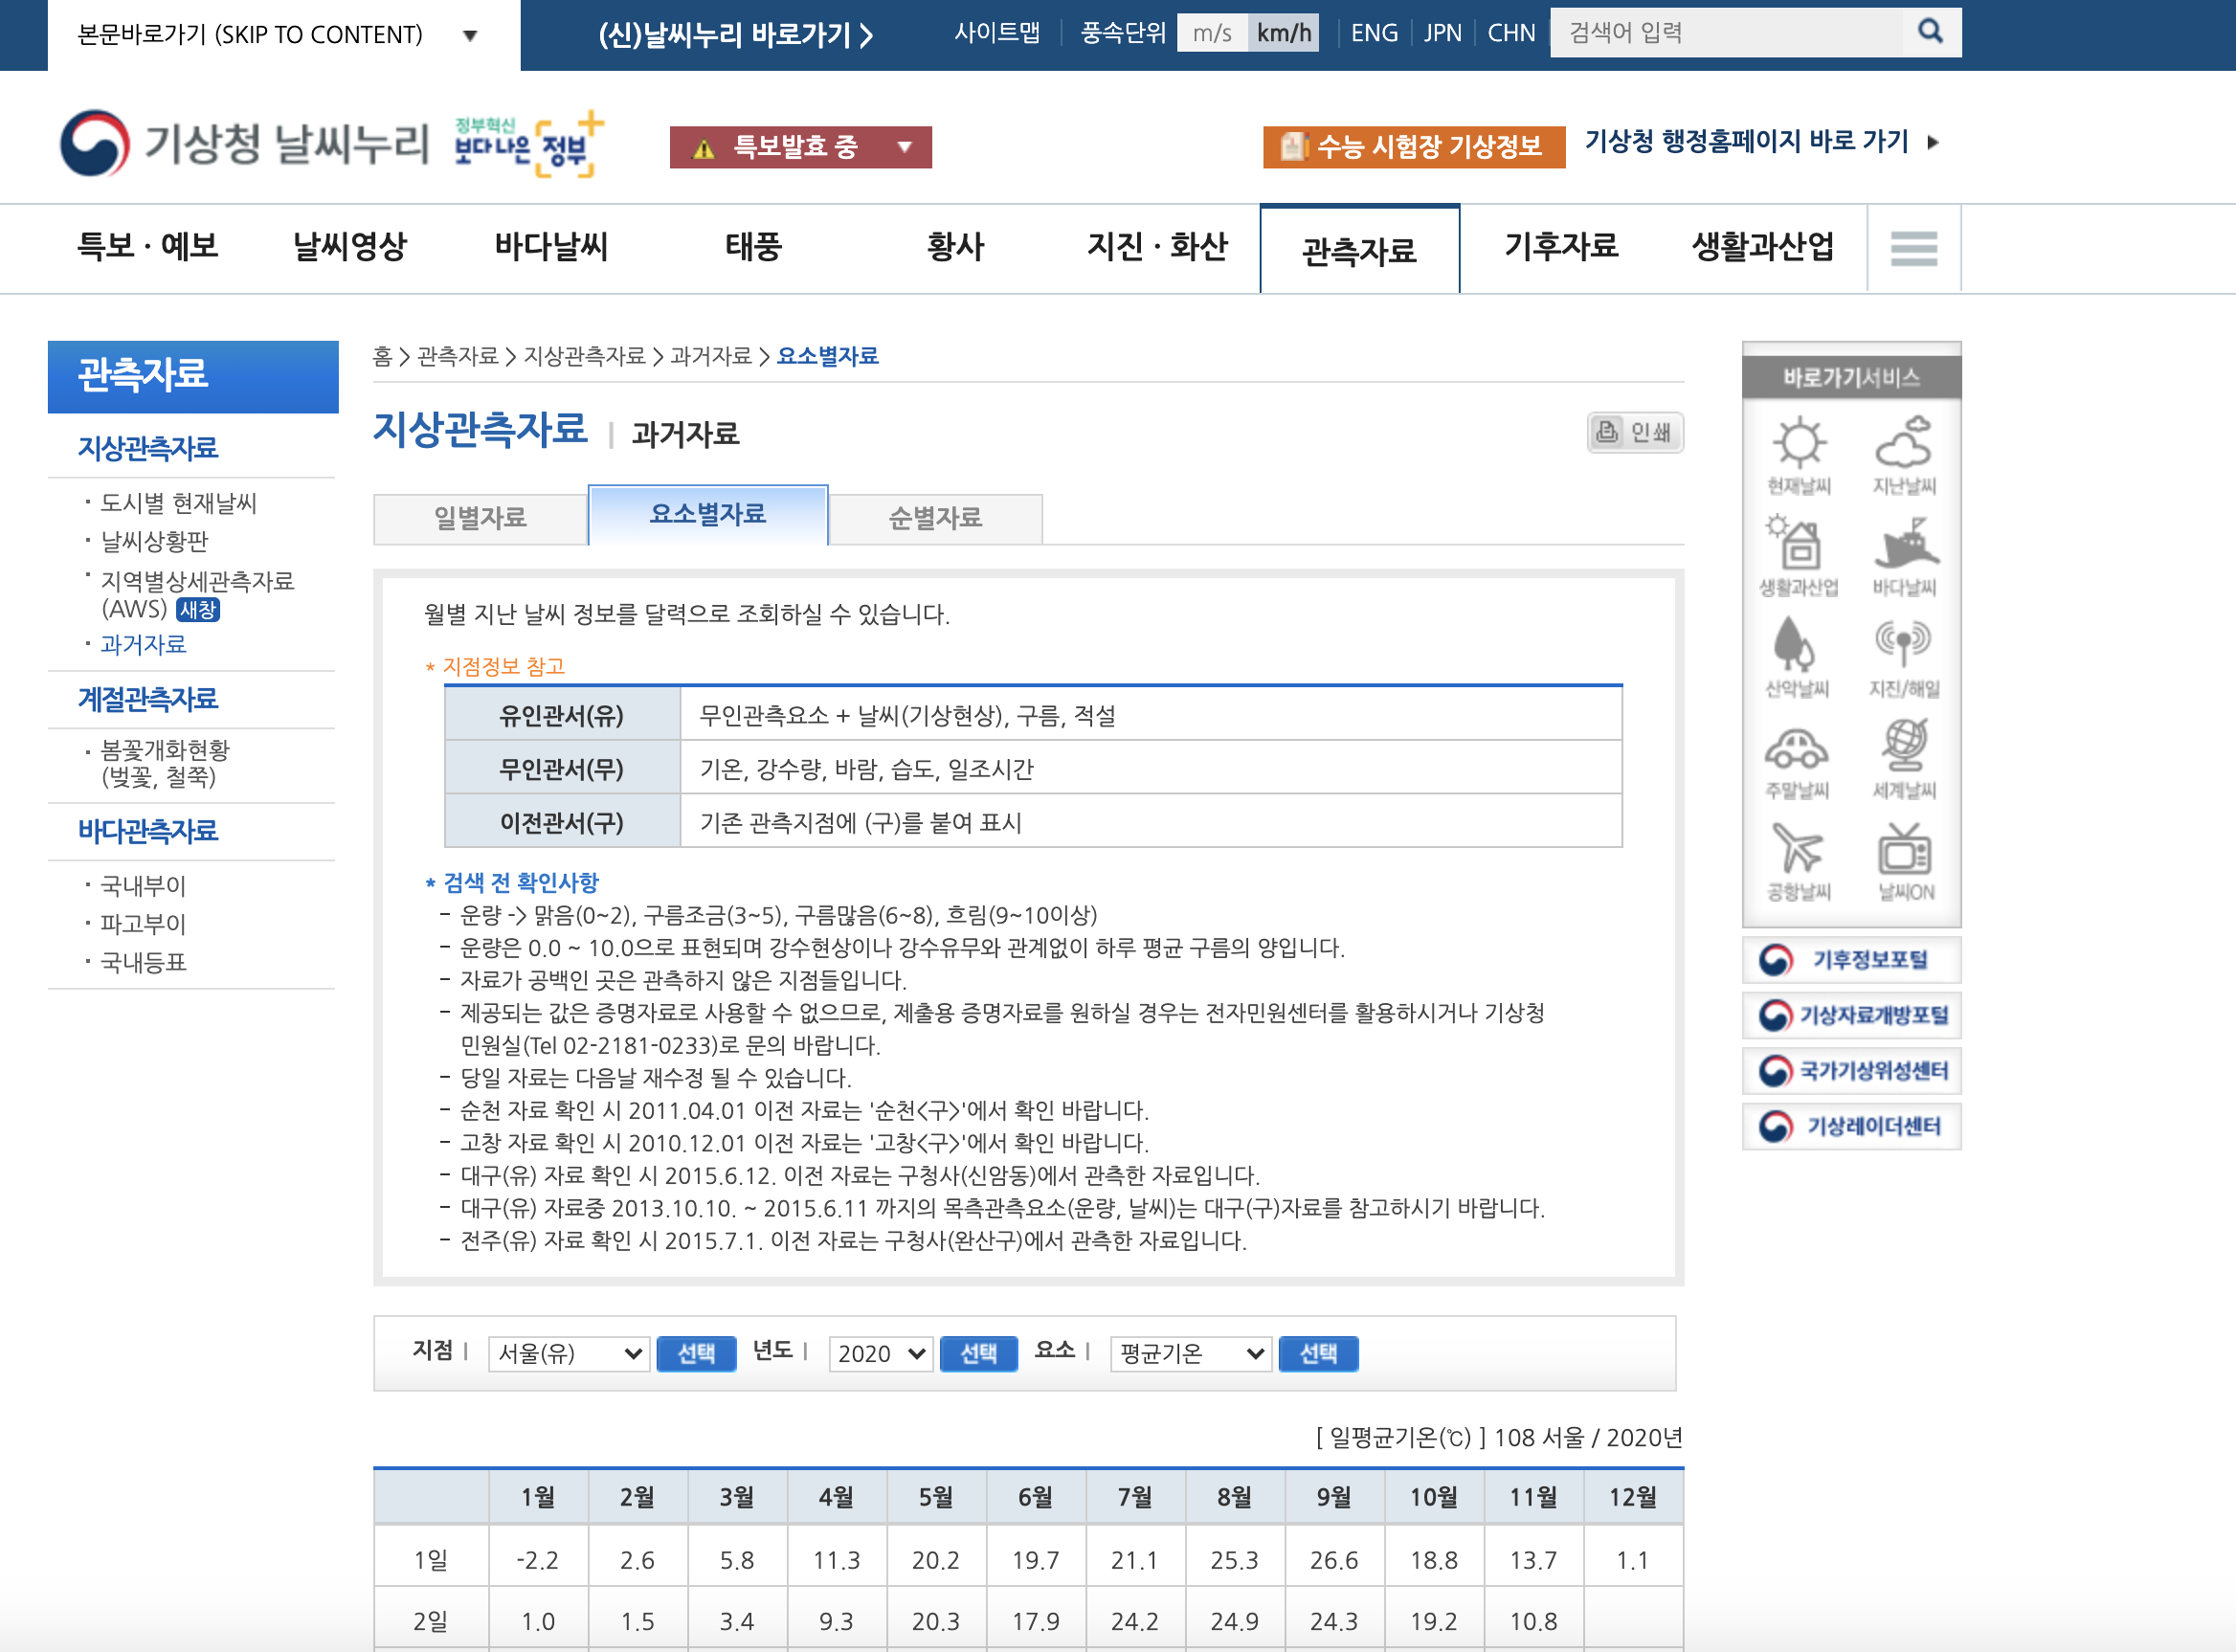
- 출처: https://www.weather.go.kr/weather/climate/past_table.jsp?stn=108&yy=2020&obs=07&x=21&y=4


In [154]:
df_temperature = pd.read_excel("./data/2020_서울평균기온.xlsx", engine='openpyxl')
df_temperature.head()

날짜  서울평균기온  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  \
0 2020-01-01    -2.2         NaN         NaN         NaN         NaN   
1 2020-01-02     1.0         NaN         NaN         NaN         NaN   
2 2020-01-03    -0.1         NaN         NaN         NaN         NaN   
3 2020-01-04     1.2         NaN         NaN         NaN         NaN   
4 2020-01-05     1.3         NaN         NaN         NaN         NaN   

   Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  Unnamed: 10  Unnamed: 11  \
0         NaN         NaN         NaN         NaN          NaN          NaN   
1         NaN         NaN         NaN         NaN          NaN          NaN   
2         NaN         NaN         NaN         NaN          NaN          NaN   
3         NaN         NaN         NaN         NaN          NaN          NaN   
4         NaN         NaN         NaN         NaN          NaN          NaN   

   Unnamed: 12  Unnamed: 13  Unnamed: 14  
0          NaN          NaN          NaN  
1          NaN          NaN          NaN  
2          NaN          NaN          NaN  
3          NaN          NaN          NaN  
4          NaN          NaN          NaN

In [155]:
df_temperature.loc[df_temperature['날짜'] < '2020-07-01']['서울평균기온']

0      -2.2
1       1.0
2      -0.1
3       1.2
4       1.3
       ... 
177    21.8
178    24.1
179    25.2
180    23.8
181    20.1
Name: 서울평균기온, Length: 182, dtype: float64

In [156]:
df_all_count_tmp['temperature'] = df_temperature.loc[df_temperature['날짜'] < '2020-07-01']['서울평균기온']
df_all_count_tmp

date  lime_count  covid_count  covid_count_scaled  \
0    2020-01-01         381          0.0           -0.897422   
1    2020-01-02         555          0.0           -0.897422   
2    2020-01-03         584          0.0           -0.897422   
3    2020-01-04         661          0.0           -0.897422   
4    2020-01-05         615          0.0           -0.897422   
..          ...         ...          ...                 ...   
177  2020-06-26        1418         17.0            1.202899   
178  2020-06-27        1314         14.0            0.832254   
179  2020-06-28        1318          7.0           -0.032584   
180  2020-06-29         959          8.0            0.090964   
181  2020-06-30         687          9.0            0.214512   

     lime_count_scaled  bike_cnt  bike_count_scaled  temperature  
0            -1.439190      2197          -1.197608         -2.2  
1            -0.913178      4106          -0.374716          1.0  
2            -0.825510      4333          -0.276866         -0.1  
3            -0.592735      3649          -0.571710          1.2  
4            -0.731795      3347          -0.701890          1.3  
..                 ...       ...                ...          ...  
177           1.695718      3557          -0.611368         21.8  
178           1.381320      3655          -0.569124         24.1  
179           1.393412      3329          -0.709649         25.2  
180           0.308136      1869          -1.338996         23.8  
181          -0.514135      2616          -1.016994         20.1  

[182 rows x 8 columns]

## 서울시 미세먼지

In [157]:
df_dust = pd.read_csv("./data/서울시 일별 평균 대기오염도 정보.csv", engine='python', encoding='cp949')
df_dust

측정일시  측정소명  이산화질소농도(ppm)  오존농도(ppm)  일산화탄소농도(ppm)  아황산가스(ppm)  \
0      20201202   강남구         0.027      0.013           0.5       0.004   
1      20201202  강남대로         0.033      0.006           0.6       0.004   
2      20201202   강동구         0.034      0.008           0.4       0.003   
3      20201202  강변북로         0.019      0.018           0.4       0.005   
4      20201202   강북구         0.026      0.008           0.5       0.004   
...         ...   ...           ...        ...           ...         ...   
18177  20191202  청계천로         0.020      0.023           0.5       0.004   
18178  20191202  한강대로         0.022      0.020           0.4       0.004   
18179  20191202    행주         0.011      0.027           0.7       0.003   
18180  20191202   홍릉로           NaN        NaN           NaN         NaN   
18181  20191202   화랑로         0.021      0.021           0.2       0.004   

       미세먼지(㎍/㎥)  초미세먼지(㎍/㎥)  
0           27.0        17.0  
1           34.0        18.0  
2           40.0        25.0  
3           28.0        18.0  
4           39.0        20.0  
...          ...         ...  
18177       23.0        15.0  
18178       22.0        11.0  
18179       24.0        12.0  
18180        NaN         NaN  
18181       25.0        11.0  

[18182 rows x 8 columns]

In [158]:
# df_dust.측정소명.value_counts()

In [159]:
where_list = ['강남대로','도산대로','강남구','서초구','송파구']

In [160]:
df_dust_gangnam = df_dust.query("측정소명 in @where_list")

In [161]:
df_dust_mean = df_dust_gangnam.groupby(['측정일시'])[['미세먼지(㎍/㎥)','초미세먼지(㎍/㎥)']].mean()
df_dust_mean

미세먼지(㎍/㎥)  초미세먼지(㎍/㎥)
측정일시                           
20191202       24.6        10.2
20191203       29.6        14.0
20191204       32.6        13.8
20191205       22.8         7.6
20191206       33.4        12.2
...             ...         ...
20201128       22.6        12.4
20201129       24.6        14.2
20201130       26.6        15.4
20201201       33.8        19.0
20201202       32.6        18.2

[365 rows x 2 columns]

## 서울시 강수량
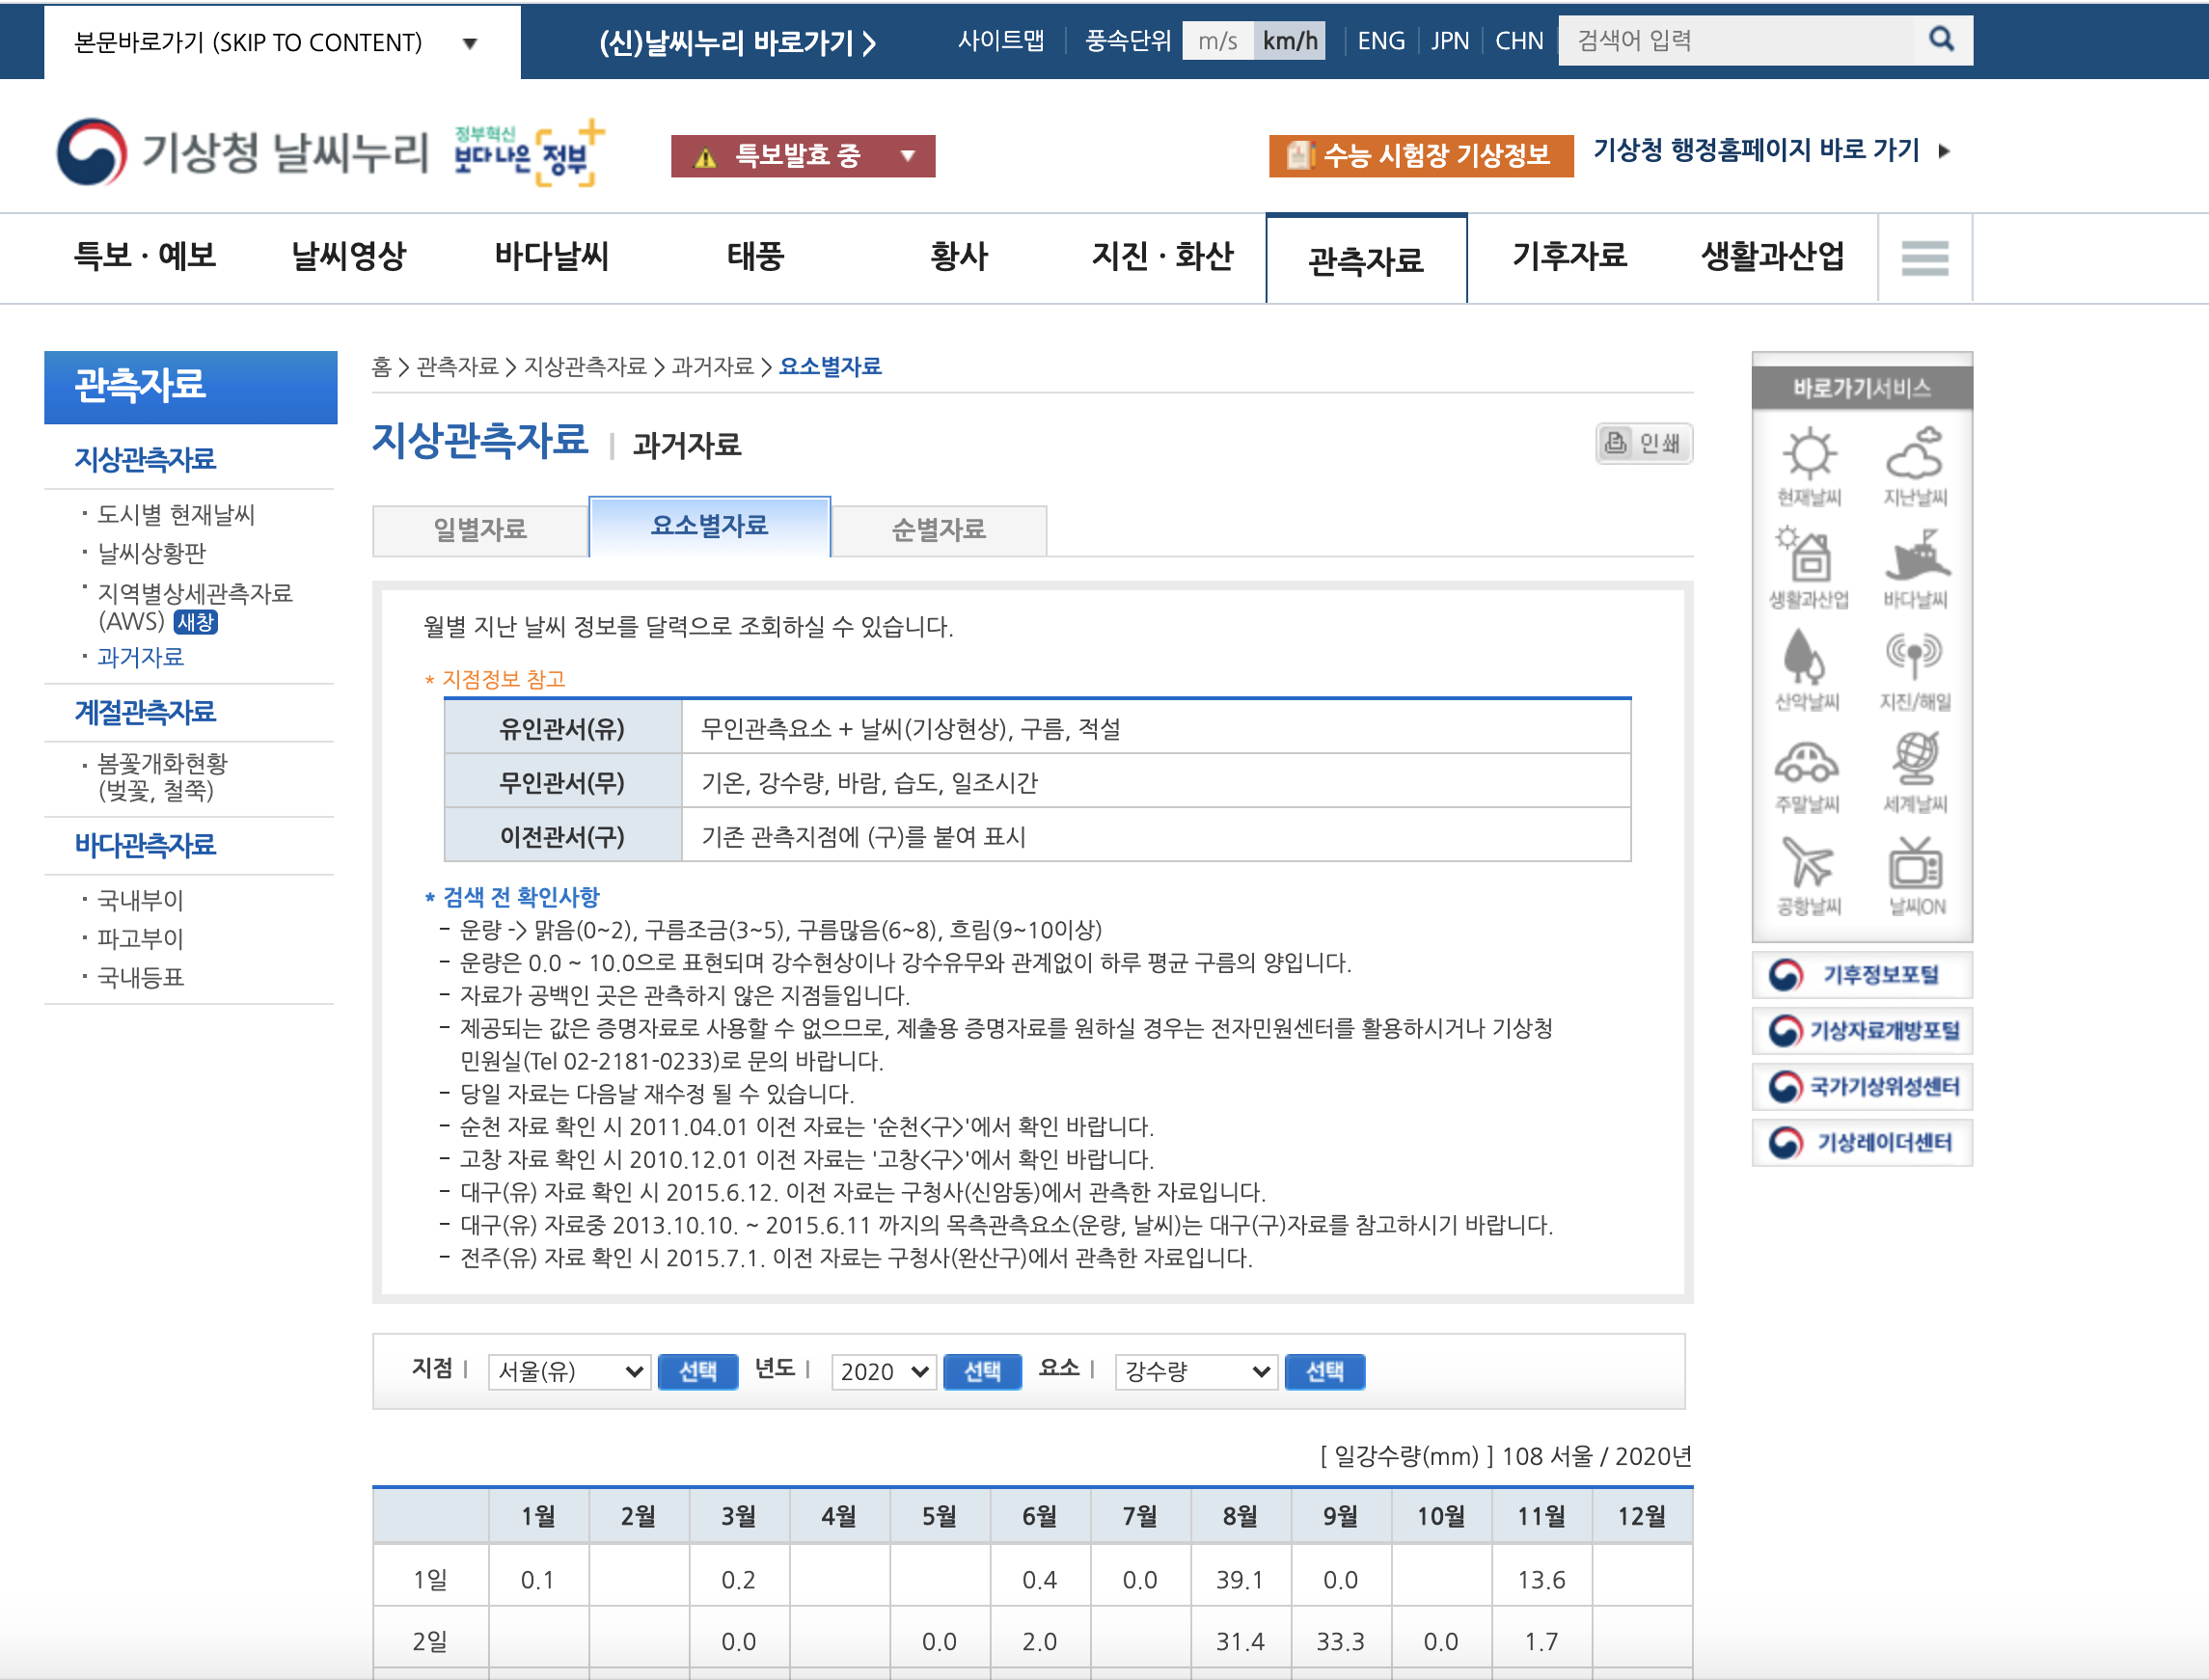
- 출처: https://www.weather.go.kr/weather/climate/past_table.jsp?stn=108&yy=2020&obs=07&x=21&y=4

In [163]:
df_rain = pd.read_excel("./data/2020_서울강수량.xlsx", engine='openpyxl')
df_rain.head()

날짜  서울강수량  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  \
0 2020-01-01    0.1         NaN         NaN         NaN         NaN   
1 2020-01-02    NaN         NaN         NaN         NaN         NaN   
2 2020-01-03    NaN         NaN         NaN         NaN         NaN   
3 2020-01-04    NaN         NaN         NaN         NaN         NaN   
4 2020-01-05    NaN         NaN         NaN         NaN         NaN   

   Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  Unnamed: 10  Unnamed: 11  \
0         NaN         NaN         NaN         NaN          NaN          NaN   
1         NaN         NaN         NaN         NaN          NaN          NaN   
2         NaN         NaN         NaN         NaN          NaN          NaN   
3         NaN         NaN         NaN         NaN          NaN          NaN   
4         NaN         NaN         NaN         NaN          NaN          NaN   

   Unnamed: 12  Unnamed: 13  Unnamed: 14  Unnamed: 15  
0          NaN          NaN          NaN          NaN  
1          NaN          NaN          NaN          NaN  
2          NaN          NaN          NaN          NaN  
3          NaN          NaN          NaN          NaN  
4          NaN          NaN          NaN          NaN

In [164]:
df_rain.loc[df_rain['서울강수량'].isnull()]

날짜  서울강수량  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  \
1   2020-01-02    NaN         NaN         NaN         NaN         NaN   
2   2020-01-03    NaN         NaN         NaN         NaN         NaN   
3   2020-01-04    NaN         NaN         NaN         NaN         NaN   
4   2020-01-05    NaN         NaN         NaN         NaN         NaN   
8   2020-01-09    NaN         NaN         NaN         NaN         NaN   
..         ...    ...         ...         ...         ...         ...   
329 2020-11-25    NaN         NaN         NaN         NaN         NaN   
330 2020-11-26    NaN         NaN         NaN         NaN         NaN   
332 2020-11-28    NaN         NaN         NaN         NaN         NaN   
333 2020-11-29    NaN         NaN         NaN         NaN         NaN   
334 2020-11-30    NaN         NaN         NaN         NaN         NaN   

     Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  Unnamed: 10  Unnamed: 11  \
1           NaN         NaN         NaN         NaN          NaN          NaN   
2           NaN         NaN         NaN         NaN          NaN          NaN   
3           NaN         NaN         NaN         NaN          NaN          NaN   
4           NaN         NaN         NaN         NaN          NaN          NaN   
8           NaN         NaN         NaN         NaN          NaN          NaN   
..          ...         ...         ...         ...          ...          ...   
329         NaN         NaN         NaN         NaN          NaN          NaN   
330         NaN         NaN         NaN         NaN          NaN          NaN   
332         NaN         NaN         NaN         NaN          NaN          NaN   
333         NaN         NaN         NaN         NaN          NaN          NaN   
334         NaN         NaN         NaN         NaN          NaN          NaN   

     Unnamed: 12  Unnamed: 13  Unnamed: 14  Unnamed: 15  
1            NaN          NaN          NaN          NaN  
2            NaN          NaN          NaN          NaN  
3            NaN          NaN          NaN          NaN  
4            NaN          NaN          NaN          NaN  
8            NaN          NaN          NaN          NaN  
..           ...          ...          ...          ...  
329          NaN          NaN          NaN          NaN  
330          NaN          NaN          NaN          NaN  
332          NaN          NaN          NaN          NaN  
333          NaN          NaN          NaN          NaN  
334          NaN          NaN          NaN          NaN  

[193 rows x 16 columns]

In [165]:
df_rain['서울강수량'].fillna(0, inplace=True)

In [166]:
df_rain.loc[df_rain['서울강수량'].isnull()]

Empty DataFrame
Columns: [날짜, 서울강수량, Unnamed: 2, Unnamed: 3, Unnamed: 4, Unnamed: 5, Unnamed: 6, Unnamed: 7, Unnamed: 8, Unnamed: 9, Unnamed: 10, Unnamed: 11, Unnamed: 12, Unnamed: 13, Unnamed: 14, Unnamed: 15]
Index: []

## 서울 비가 왔는지 안 왔는지 여부

In [167]:
df_rain['Sunny_or_Rain'] = 1
df_rain
    
# df_rain['Sunny_or_Rain'] = 1

날짜  서울강수량  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  \
0   2020-01-01    0.1         NaN         NaN         NaN         NaN   
1   2020-01-02    0.0         NaN         NaN         NaN         NaN   
2   2020-01-03    0.0         NaN         NaN         NaN         NaN   
3   2020-01-04    0.0         NaN         NaN         NaN         NaN   
4   2020-01-05    0.0         NaN         NaN         NaN         NaN   
..         ...    ...         ...         ...         ...         ...   
330 2020-11-26    0.0         NaN         NaN         NaN         NaN   
331 2020-11-27    0.0         NaN         NaN         NaN         NaN   
332 2020-11-28    0.0         NaN         NaN         NaN         NaN   
333 2020-11-29    0.0         NaN         NaN         NaN         NaN   
334 2020-11-30    0.0         NaN         NaN         NaN         NaN   

     Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  Unnamed: 10  Unnamed: 11  \
0           NaN         NaN         NaN         NaN          NaN          NaN   
1           NaN         NaN         NaN         NaN          NaN          NaN   
2           NaN         NaN         NaN         NaN          NaN          NaN   
3           NaN         NaN         NaN         NaN          NaN          NaN   
4           NaN         NaN         NaN         NaN          NaN          NaN   
..          ...         ...         ...         ...          ...          ...   
330         NaN         NaN         NaN         NaN          NaN          NaN   
331         NaN         NaN         NaN         NaN          NaN          NaN   
332         NaN         NaN         NaN         NaN          NaN          NaN   
333         NaN         NaN         NaN         NaN          NaN          NaN   
334         NaN         NaN         NaN         NaN          NaN          NaN   

     Unnamed: 12  Unnamed: 13  Unnamed: 14  Unnamed: 15  Sunny_or_Rain  
0            NaN          NaN          NaN          NaN              1  
1            NaN          NaN          NaN          NaN              1  
2            NaN          NaN          NaN          NaN              1  
3            NaN          NaN          NaN          NaN              1  
4            NaN          NaN          NaN          NaN              1  
..           ...          ...          ...          ...            ...  
330          NaN          NaN          NaN          NaN              1  
331          NaN          NaN          NaN          NaN              1  
332          NaN          NaN          NaN          NaN              1  
333          NaN          NaN          NaN          NaN              1  
334          NaN          NaN          NaN          NaN              1  

[335 rows x 17 columns]

In [168]:
df_rain['Sunny_or_Rain'] = df_rain['서울강수량'].apply(lambda x: 0 if x == 0.0 else 1)
df_rain

날짜  서울강수량  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  \
0   2020-01-01    0.1         NaN         NaN         NaN         NaN   
1   2020-01-02    0.0         NaN         NaN         NaN         NaN   
2   2020-01-03    0.0         NaN         NaN         NaN         NaN   
3   2020-01-04    0.0         NaN         NaN         NaN         NaN   
4   2020-01-05    0.0         NaN         NaN         NaN         NaN   
..         ...    ...         ...         ...         ...         ...   
330 2020-11-26    0.0         NaN         NaN         NaN         NaN   
331 2020-11-27    0.0         NaN         NaN         NaN         NaN   
332 2020-11-28    0.0         NaN         NaN         NaN         NaN   
333 2020-11-29    0.0         NaN         NaN         NaN         NaN   
334 2020-11-30    0.0         NaN         NaN         NaN         NaN   

     Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  Unnamed: 10  Unnamed: 11  \
0           NaN         NaN         NaN         NaN          NaN          NaN   
1           NaN         NaN         NaN         NaN          NaN          NaN   
2           NaN         NaN         NaN         NaN          NaN          NaN   
3           NaN         NaN         NaN         NaN          NaN          NaN   
4           NaN         NaN         NaN         NaN          NaN          NaN   
..          ...         ...         ...         ...          ...          ...   
330         NaN         NaN         NaN         NaN          NaN          NaN   
331         NaN         NaN         NaN         NaN          NaN          NaN   
332         NaN         NaN         NaN         NaN          NaN          NaN   
333         NaN         NaN         NaN         NaN          NaN          NaN   
334         NaN         NaN         NaN         NaN          NaN          NaN   

     Unnamed: 12  Unnamed: 13  Unnamed: 14  Unnamed: 15  Sunny_or_Rain  
0            NaN          NaN          NaN          NaN              1  
1            NaN          NaN          NaN          NaN              0  
2            NaN          NaN          NaN          NaN              0  
3            NaN          NaN          NaN          NaN              0  
4            NaN          NaN          NaN          NaN              0  
..           ...          ...          ...          ...            ...  
330          NaN          NaN          NaN          NaN              0  
331          NaN          NaN          NaN          NaN              0  
332          NaN          NaN          NaN          NaN              0  
333          NaN          NaN          NaN          NaN              0  
334          NaN          NaN          NaN          NaN              0  

[335 rows x 17 columns]

In [169]:
df_rain[df_rain['Sunny_or_Rain'] == 1]

날짜  서울강수량  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  \
0   2020-01-01    0.1         NaN         NaN         NaN         NaN   
5   2020-01-06    1.8         NaN         NaN         NaN         NaN   
6   2020-01-07   46.3         NaN         NaN         NaN         NaN   
7   2020-01-08   11.6         NaN         NaN         NaN         NaN   
18  2020-01-19    0.6         NaN         NaN         NaN         NaN   
..         ...    ...         ...         ...         ...         ...   
321 2020-11-17    0.1         NaN         NaN         NaN         NaN   
322 2020-11-18   12.2         NaN         NaN         NaN         NaN   
323 2020-11-19   86.9         NaN         NaN         NaN         NaN   
325 2020-11-21    0.2         NaN         NaN         NaN         NaN   
326 2020-11-22    4.8         NaN         NaN         NaN         NaN   

     Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  Unnamed: 10  Unnamed: 11  \
0           NaN         NaN         NaN         NaN          NaN          NaN   
5           NaN         NaN         NaN         NaN          NaN          NaN   
6           NaN         NaN         NaN         NaN          NaN          NaN   
7           NaN         NaN         NaN         NaN          NaN          NaN   
18          NaN         NaN         NaN         NaN          NaN          NaN   
..          ...         ...         ...         ...          ...          ...   
321         NaN         NaN         NaN         NaN          NaN          NaN   
322         NaN         NaN         NaN         NaN          NaN          NaN   
323         NaN         NaN         NaN         NaN          NaN          NaN   
325         NaN         NaN         NaN         NaN          NaN          NaN   
326         NaN         NaN         NaN         NaN          NaN          NaN   

     Unnamed: 12  Unnamed: 13  Unnamed: 14  Unnamed: 15  Sunny_or_Rain  
0            NaN          NaN          NaN          NaN              1  
5            NaN          NaN          NaN          NaN              1  
6            NaN          NaN          NaN          NaN              1  
7            NaN          NaN          NaN          NaN              1  
18           NaN          NaN          NaN          NaN              1  
..           ...          ...          ...          ...            ...  
321          NaN          NaN          NaN          NaN              1  
322          NaN          NaN          NaN          NaN              1  
323          NaN          NaN          NaN          NaN              1  
325          NaN          NaN          NaN          NaN              1  
326          NaN          NaN          NaN          NaN              1  

[102 rows x 17 columns]

### 범주형 변수 Dummy 처리

In [170]:
ohe_pclass = pd.get_dummies(df_rain['Sunny_or_Rain'], prefix='Sunny_or_Rain')
ohe_pclass

Sunny_or_Rain_0  Sunny_or_Rain_1
0                  0                1
1                  1                0
2                  1                0
3                  1                0
4                  1                0
..               ...              ...
330                1                0
331                1                0
332                1                0
333                1                0
334                1                0

[335 rows x 2 columns]

In [171]:
df_rain = pd.concat([df_rain, ohe_pclass], axis=1)
df_rain.head()

날짜  서울강수량  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  \
0 2020-01-01    0.1         NaN         NaN         NaN         NaN   
1 2020-01-02    0.0         NaN         NaN         NaN         NaN   
2 2020-01-03    0.0         NaN         NaN         NaN         NaN   
3 2020-01-04    0.0         NaN         NaN         NaN         NaN   
4 2020-01-05    0.0         NaN         NaN         NaN         NaN   

   Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  Unnamed: 10  Unnamed: 11  \
0         NaN         NaN         NaN         NaN          NaN          NaN   
1         NaN         NaN         NaN         NaN          NaN          NaN   
2         NaN         NaN         NaN         NaN          NaN          NaN   
3         NaN         NaN         NaN         NaN          NaN          NaN   
4         NaN         NaN         NaN         NaN          NaN          NaN   

   Unnamed: 12  Unnamed: 13  Unnamed: 14  Unnamed: 15  Sunny_or_Rain  \
0          NaN          NaN          NaN          NaN              1   
1          NaN          NaN          NaN          NaN              0   
2          NaN          NaN          NaN          NaN              0   
3          NaN          NaN          NaN          NaN              0   
4          NaN          NaN          NaN          NaN              0   

   Sunny_or_Rain_0  Sunny_or_Rain_1  
0                0                1  
1                1                0  
2                1                0  
3                1                0  
4                1                0

In [172]:
df_rain[df_rain['Sunny_or_Rain'] == 1]

날짜  서울강수량  Unnamed: 2  Unnamed: 3  Unnamed: 4  Unnamed: 5  \
0   2020-01-01    0.1         NaN         NaN         NaN         NaN   
5   2020-01-06    1.8         NaN         NaN         NaN         NaN   
6   2020-01-07   46.3         NaN         NaN         NaN         NaN   
7   2020-01-08   11.6         NaN         NaN         NaN         NaN   
18  2020-01-19    0.6         NaN         NaN         NaN         NaN   
..         ...    ...         ...         ...         ...         ...   
321 2020-11-17    0.1         NaN         NaN         NaN         NaN   
322 2020-11-18   12.2         NaN         NaN         NaN         NaN   
323 2020-11-19   86.9         NaN         NaN         NaN         NaN   
325 2020-11-21    0.2         NaN         NaN         NaN         NaN   
326 2020-11-22    4.8         NaN         NaN         NaN         NaN   

     Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  Unnamed: 10  Unnamed: 11  \
0           NaN         NaN         NaN         NaN          NaN          NaN   
5           NaN         NaN         NaN         NaN          NaN          NaN   
6           NaN         NaN         NaN         NaN          NaN          NaN   
7           NaN         NaN         NaN         NaN          NaN          NaN   
18          NaN         NaN         NaN         NaN          NaN          NaN   
..          ...         ...         ...         ...          ...          ...   
321         NaN         NaN         NaN         NaN          NaN          NaN   
322         NaN         NaN         NaN         NaN          NaN          NaN   
323         NaN         NaN         NaN         NaN          NaN          NaN   
325         NaN         NaN         NaN         NaN          NaN          NaN   
326         NaN         NaN         NaN         NaN          NaN          NaN   

     Unnamed: 12  Unnamed: 13  Unnamed: 14  Unnamed: 15  Sunny_or_Rain  \
0            NaN          NaN          NaN          NaN              1   
5            NaN          NaN          NaN          NaN              1   
6            NaN          NaN          NaN          NaN              1   
7            NaN          NaN          NaN          NaN              1   
18           NaN          NaN          NaN          NaN              1   
..           ...          ...          ...          ...            ...   
321          NaN          NaN          NaN          NaN              1   
322          NaN          NaN          NaN          NaN              1   
323          NaN          NaN          NaN          NaN              1   
325          NaN          NaN          NaN          NaN              1   
326          NaN          NaN          NaN          NaN              1   

     Sunny_or_Rain_0  Sunny_or_Rain_1  
0                  0                1  
5                  0                1  
6                  0                1  
7                  0                1  
18                 0                1  
..               ...              ...  
321                0                1  
322                0                1  
323                0                1  
325                0                1  
326                0                1  

[102 rows x 19 columns]

### 데이터 프레임 하나로 모으기

In [173]:
df_dust_mean = df_dust_mean.reset_index()
df_dust_mean

측정일시  미세먼지(㎍/㎥)  초미세먼지(㎍/㎥)
0    20191202       24.6        10.2
1    20191203       29.6        14.0
2    20191204       32.6        13.8
3    20191205       22.8         7.6
4    20191206       33.4        12.2
..        ...        ...         ...
360  20201128       22.6        12.4
361  20201129       24.6        14.2
362  20201130       26.6        15.4
363  20201201       33.8        19.0
364  20201202       32.6        18.2

[365 rows x 3 columns]

In [174]:
df_dust_mean = df_dust_mean.loc[(df_dust_mean['측정일시'] > 20191231)& (df_dust_mean['측정일시'] < 20200701)][['측정일시','미세먼지(㎍/㎥)','초미세먼지(㎍/㎥)']]

In [175]:
# 20200222, 20200223 두개가 없음
df_dust_mean.측정일시.values

array([20200101, 20200102, 20200103, 20200104, 20200105, 20200106,
       20200107, 20200108, 20200109, 20200110, 20200111, 20200112,
       20200113, 20200114, 20200115, 20200116, 20200117, 20200118,
       20200119, 20200120, 20200121, 20200122, 20200123, 20200124,
       20200125, 20200126, 20200127, 20200128, 20200129, 20200130,
       20200131, 20200201, 20200202, 20200203, 20200204, 20200205,
       20200206, 20200207, 20200208, 20200209, 20200210, 20200211,
       20200212, 20200213, 20200214, 20200215, 20200216, 20200217,
       20200218, 20200219, 20200220, 20200221, 20200224, 20200225,
       20200226, 20200227, 20200228, 20200229, 20200301, 20200302,
       20200303, 20200304, 20200305, 20200306, 20200307, 20200308,
       20200309, 20200310, 20200311, 20200312, 20200313, 20200314,
       20200315, 20200316, 20200317, 20200318, 20200319, 20200320,
       20200321, 20200322, 20200323, 20200324, 20200325, 20200326,
       20200327, 20200328, 20200329, 20200330, 20200331, 20200

In [176]:
df_dust_added = df_dust_mean

In [177]:
df_dust_added.loc[210] = [20200222, 0, 0]
df_dust_added

측정일시  미세먼지(㎍/㎥)  초미세먼지(㎍/㎥)
30   20200101  32.666667   22.000000
31   20200102  60.333333   41.000000
32   20200103  67.666667   46.000000
33   20200104  57.000000   39.333333
34   20200105  50.666667   34.666667
..        ...        ...         ...
206  20200627  27.400000   16.200000
207  20200628  29.400000   17.800000
208  20200629  35.000000   22.800000
209  20200630   9.400000    4.600000
210  20200222   0.000000    0.000000

[181 rows x 3 columns]

In [178]:
df_dust_added.loc[211] = [20200223, 0, 0]
df_dust_added

측정일시  미세먼지(㎍/㎥)  초미세먼지(㎍/㎥)
30   20200101  32.666667   22.000000
31   20200102  60.333333   41.000000
32   20200103  67.666667   46.000000
33   20200104  57.000000   39.333333
34   20200105  50.666667   34.666667
..        ...        ...         ...
207  20200628  29.400000   17.800000
208  20200629  35.000000   22.800000
209  20200630   9.400000    4.600000
210  20200222   0.000000    0.000000
211  20200223   0.000000    0.000000

[182 rows x 3 columns]

In [179]:
df_dust_added = df_dust_added.sort_values(by='측정일시')

In [180]:
df_dust_added

측정일시  미세먼지(㎍/㎥)  초미세먼지(㎍/㎥)
30   20200101  32.666667   22.000000
31   20200102  60.333333   41.000000
32   20200103  67.666667   46.000000
33   20200104  57.000000   39.333333
34   20200105  50.666667   34.666667
..        ...        ...         ...
205  20200626  21.800000   13.000000
206  20200627  27.400000   16.200000
207  20200628  29.400000   17.800000
208  20200629  35.000000   22.800000
209  20200630   9.400000    4.600000

[182 rows x 3 columns]

In [181]:
# df_dust_mean.loc[df_dust_mean['측정일시'] < 20200701]['미세먼지(㎍/㎥)']

In [182]:
df_all_count_tmp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 182 entries, 0 to 181
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                182 non-null    object 
 1   lime_count          182 non-null    int64  
 2   covid_count         182 non-null    float64
 3   covid_count_scaled  182 non-null    float64
 4   lime_count_scaled   182 non-null    float64
 5   bike_cnt            182 non-null    int64  
 6   bike_count_scaled   182 non-null    float64
 7   temperature         182 non-null    float64
dtypes: float64(5), int64(2), object(1)
memory usage: 12.8+ KB


In [183]:
df_dust_added = df_dust_added.reset_index()
df_dust_added

index      측정일시  미세먼지(㎍/㎥)  초미세먼지(㎍/㎥)
0       30  20200101  32.666667   22.000000
1       31  20200102  60.333333   41.000000
2       32  20200103  67.666667   46.000000
3       33  20200104  57.000000   39.333333
4       34  20200105  50.666667   34.666667
..     ...       ...        ...         ...
177    205  20200626  21.800000   13.000000
178    206  20200627  27.400000   16.200000
179    207  20200628  29.400000   17.800000
180    208  20200629  35.000000   22.800000
181    209  20200630   9.400000    4.600000

[182 rows x 4 columns]

In [184]:
    
df_all_count_tmp['rain'] = df_rain.loc[df_rain['날짜'] < '2020-07-01']['서울강수량']
df_all_count_tmp['Sunny_or_Rain_0'] = df_rain.loc[df_rain['날짜'] < '2020-07-01']['Sunny_or_Rain_0']
df_all_count_tmp['Sunny_or_Rain_1'] = df_rain.loc[df_rain['날짜'] < '2020-07-01']['Sunny_or_Rain_1']
df_all_count_tmp['fine_dust'] = df_dust_added['미세먼지(㎍/㎥)']
df_all_count_tmp['ultrafine_dust'] = df_dust_added['초미세먼지(㎍/㎥)']

df_all_count_tmp

date  lime_count  covid_count  covid_count_scaled  \
0    2020-01-01         381          0.0           -0.897422   
1    2020-01-02         555          0.0           -0.897422   
2    2020-01-03         584          0.0           -0.897422   
3    2020-01-04         661          0.0           -0.897422   
4    2020-01-05         615          0.0           -0.897422   
..          ...         ...          ...                 ...   
177  2020-06-26        1418         17.0            1.202899   
178  2020-06-27        1314         14.0            0.832254   
179  2020-06-28        1318          7.0           -0.032584   
180  2020-06-29         959          8.0            0.090964   
181  2020-06-30         687          9.0            0.214512   

     lime_count_scaled  bike_cnt  bike_count_scaled  temperature  rain  \
0            -1.439190      2197          -1.197608         -2.2   0.1   
1            -0.913178      4106          -0.374716          1.0   0.0   
2            -0.825510      4333          -0.276866         -0.1   0.0   
3            -0.592735      3649          -0.571710          1.2   0.0   
4            -0.731795      3347          -0.701890          1.3   0.0   
..                 ...       ...                ...          ...   ...   
177           1.695718      3557          -0.611368         21.8   2.1   
178           1.381320      3655          -0.569124         24.1   0.0   
179           1.393412      3329          -0.709649         25.2   0.0   
180           0.308136      1869          -1.338996         23.8  11.9   
181          -0.514135      2616          -1.016994         20.1  64.7   

     Sunny_or_Rain_0  Sunny_or_Rain_1  fine_dust  ultrafine_dust  
0                  0                1  32.666667       22.000000  
1                  1                0  60.333333       41.000000  
2                  1                0  67.666667       46.000000  
3                  1                0  57.000000       39.333333  
4                  1                0  50.666667       34.666667  
..               ...              ...        ...             ...  
177                0                1  21.800000       13.000000  
178                1                0  27.400000       16.200000  
179                1                0  29.400000       17.800000  
180                0                1  35.000000       22.800000  
181                0                1   9.400000        4.600000  

[182 rows x 13 columns]

# 비가 옴에 따라 얼마나 사용량이 달라질까?

In [185]:
df_all_count_tmp.loc[df_all_count_tmp['Sunny_or_Rain_1'] == 1]

date  lime_count  covid_count  covid_count_scaled  \
0    2020-01-01         381          0.0           -0.897422   
5    2020-01-06         539          0.0           -0.897422   
6    2020-01-07         352          0.0           -0.897422   
7    2020-01-08         515          0.0           -0.897422   
18   2020-01-19         644          0.0           -0.897422   
26   2020-01-27         675          0.0           -0.897422   
34   2020-02-04         405          0.0           -0.897422   
42   2020-02-12         660          0.0           -0.897422   
45   2020-02-15         956          0.0           -0.897422   
46   2020-02-16         288          2.0           -0.650326   
47   2020-02-17         279          0.0           -0.897422   
51   2020-02-21         585          2.0           -0.650326   
52   2020-02-22         404          4.0           -0.403229   
55   2020-02-25         525         16.0            1.079350   
58   2020-02-28         366          8.0            0.090964   
59   2020-02-29         532          5.0           -0.279681   
60   2020-03-01         182          6.0           -0.156132   
69   2020-03-10         420         46.0            4.785799   
72   2020-03-13         688          9.0            0.214512   
85   2020-03-26         774         14.0            0.832254   
86   2020-03-27         899         15.0            0.955802   
107  2020-04-17         703          2.0           -0.650326   
109  2020-04-19         527          1.0           -0.773874   
110  2020-04-20         627          1.0           -0.773874   
128  2020-05-08        1034         13.0            0.708706   
129  2020-05-09         381         18.0            1.326447   
130  2020-05-10         812         20.0            1.573544   
131  2020-05-11        1113         12.0            0.585157   
132  2020-05-12         929          8.0            0.090964   
135  2020-05-15         533          6.0           -0.156132   
136  2020-05-16         991          4.0           -0.403229   
138  2020-05-18         841          7.0           -0.032584   
139  2020-05-19         662          9.0            0.214512   
144  2020-05-24         976          7.0           -0.032584   
146  2020-05-26         940         19.0            1.449995   
151  2020-05-31        1198          1.0           -0.773874   
152  2020-06-01         719         14.0            0.832254   
153  2020-06-02         842         20.0            1.573544   
155  2020-06-04        1203         15.0            0.955802   
161  2020-06-10         923         19.0            1.449995   
165  2020-06-14        1437          7.0           -0.032584   
170  2020-06-19        1958         16.0            1.079350   
175  2020-06-24         775          9.0            0.214512   
176  2020-06-25         959         17.0            1.202899   
177  2020-06-26        1418         17.0            1.202899   
180  2020-06-29         959          8.0            0.090964   
181  2020-06-30         687          9.0            0.214512   

     lime_count_scaled  bike_cnt  bike_count_scaled  temperature  rain  \
0            -1.439190      2197          -1.197608         -2.2   0.1   
5            -0.961547      2197          -1.197608          3.1   1.8   
6            -1.526858       257          -2.033863          6.3  46.3   
7            -1.034101      3070          -0.821293          2.4  11.6   
18           -0.644127      2453          -1.087257          1.9   0.6   
26           -0.550412      2388          -1.115276          5.9   0.1   
34           -1.366637      3516          -0.629041         -1.6   1.7   
42           -0.595758      1453          -1.518316          7.4   6.7   
45            0.299066      4398          -0.248847          9.8   2.0   
46           -1.720334       733          -1.828679         -1.4  13.4   
47           -1.747541      1519          -1.489866         -5.9   1.0   
51           -0.822487      4314          -0.28505

In [186]:
# 요일 별 라임 사용량과 따릉이 사용량 비교
df_all_count_tmp.loc[df_all_count_tmp['rain'] > 8.5].groupby(['date'])[['lime_count_scaled', 'bike_count_scaled','covid_count_scaled']].sum().iplot()

In [187]:
# 요일 별 라임 사용량과 따릉이 사용량 비교
df_all_count_tmp.loc[df_all_count_tmp['rain'] < 8.5].groupby(['date'])[['lime_count_scaled', 'bike_count_scaled','covid_count_scaled']].sum().iplot()

In [188]:
df_all_count_tmp['rain'].mean()

2.1912087912087914

In [189]:
df_all_count_tmp.loc[df_all_count_tmp['Sunny_or_Rain_1'] == 1].mean()

lime_count             749.276596
covid_count              8.638298
covid_count_scaled       0.169825
lime_count_scaled       -0.325870
bike_cnt              3087.319149
bike_count_scaled       -0.813828
temperature             12.259574
rain                     8.485106
Sunny_or_Rain_0          0.000000
Sunny_or_Rain_1          1.000000
fine_dust               33.707801
ultrafine_dust          19.748936
dtype: float64

# 시각화

In [190]:
df_all_count_tmp.columns

Index(['date', 'lime_count', 'covid_count', 'covid_count_scaled',
       'lime_count_scaled', 'bike_cnt', 'bike_count_scaled', 'temperature',
       'rain', 'Sunny_or_Rain_0', 'Sunny_or_Rain_1', 'fine_dust',
       'ultrafine_dust'],
      dtype='object')

In [191]:
#  'lime_count', 'covid_count', 'bike_cnt', 'temperature',
#        'rain', 'Sunny_or_Rain_0', 'Sunny_or_Rain_1'

## 산점도(Scatter plot)

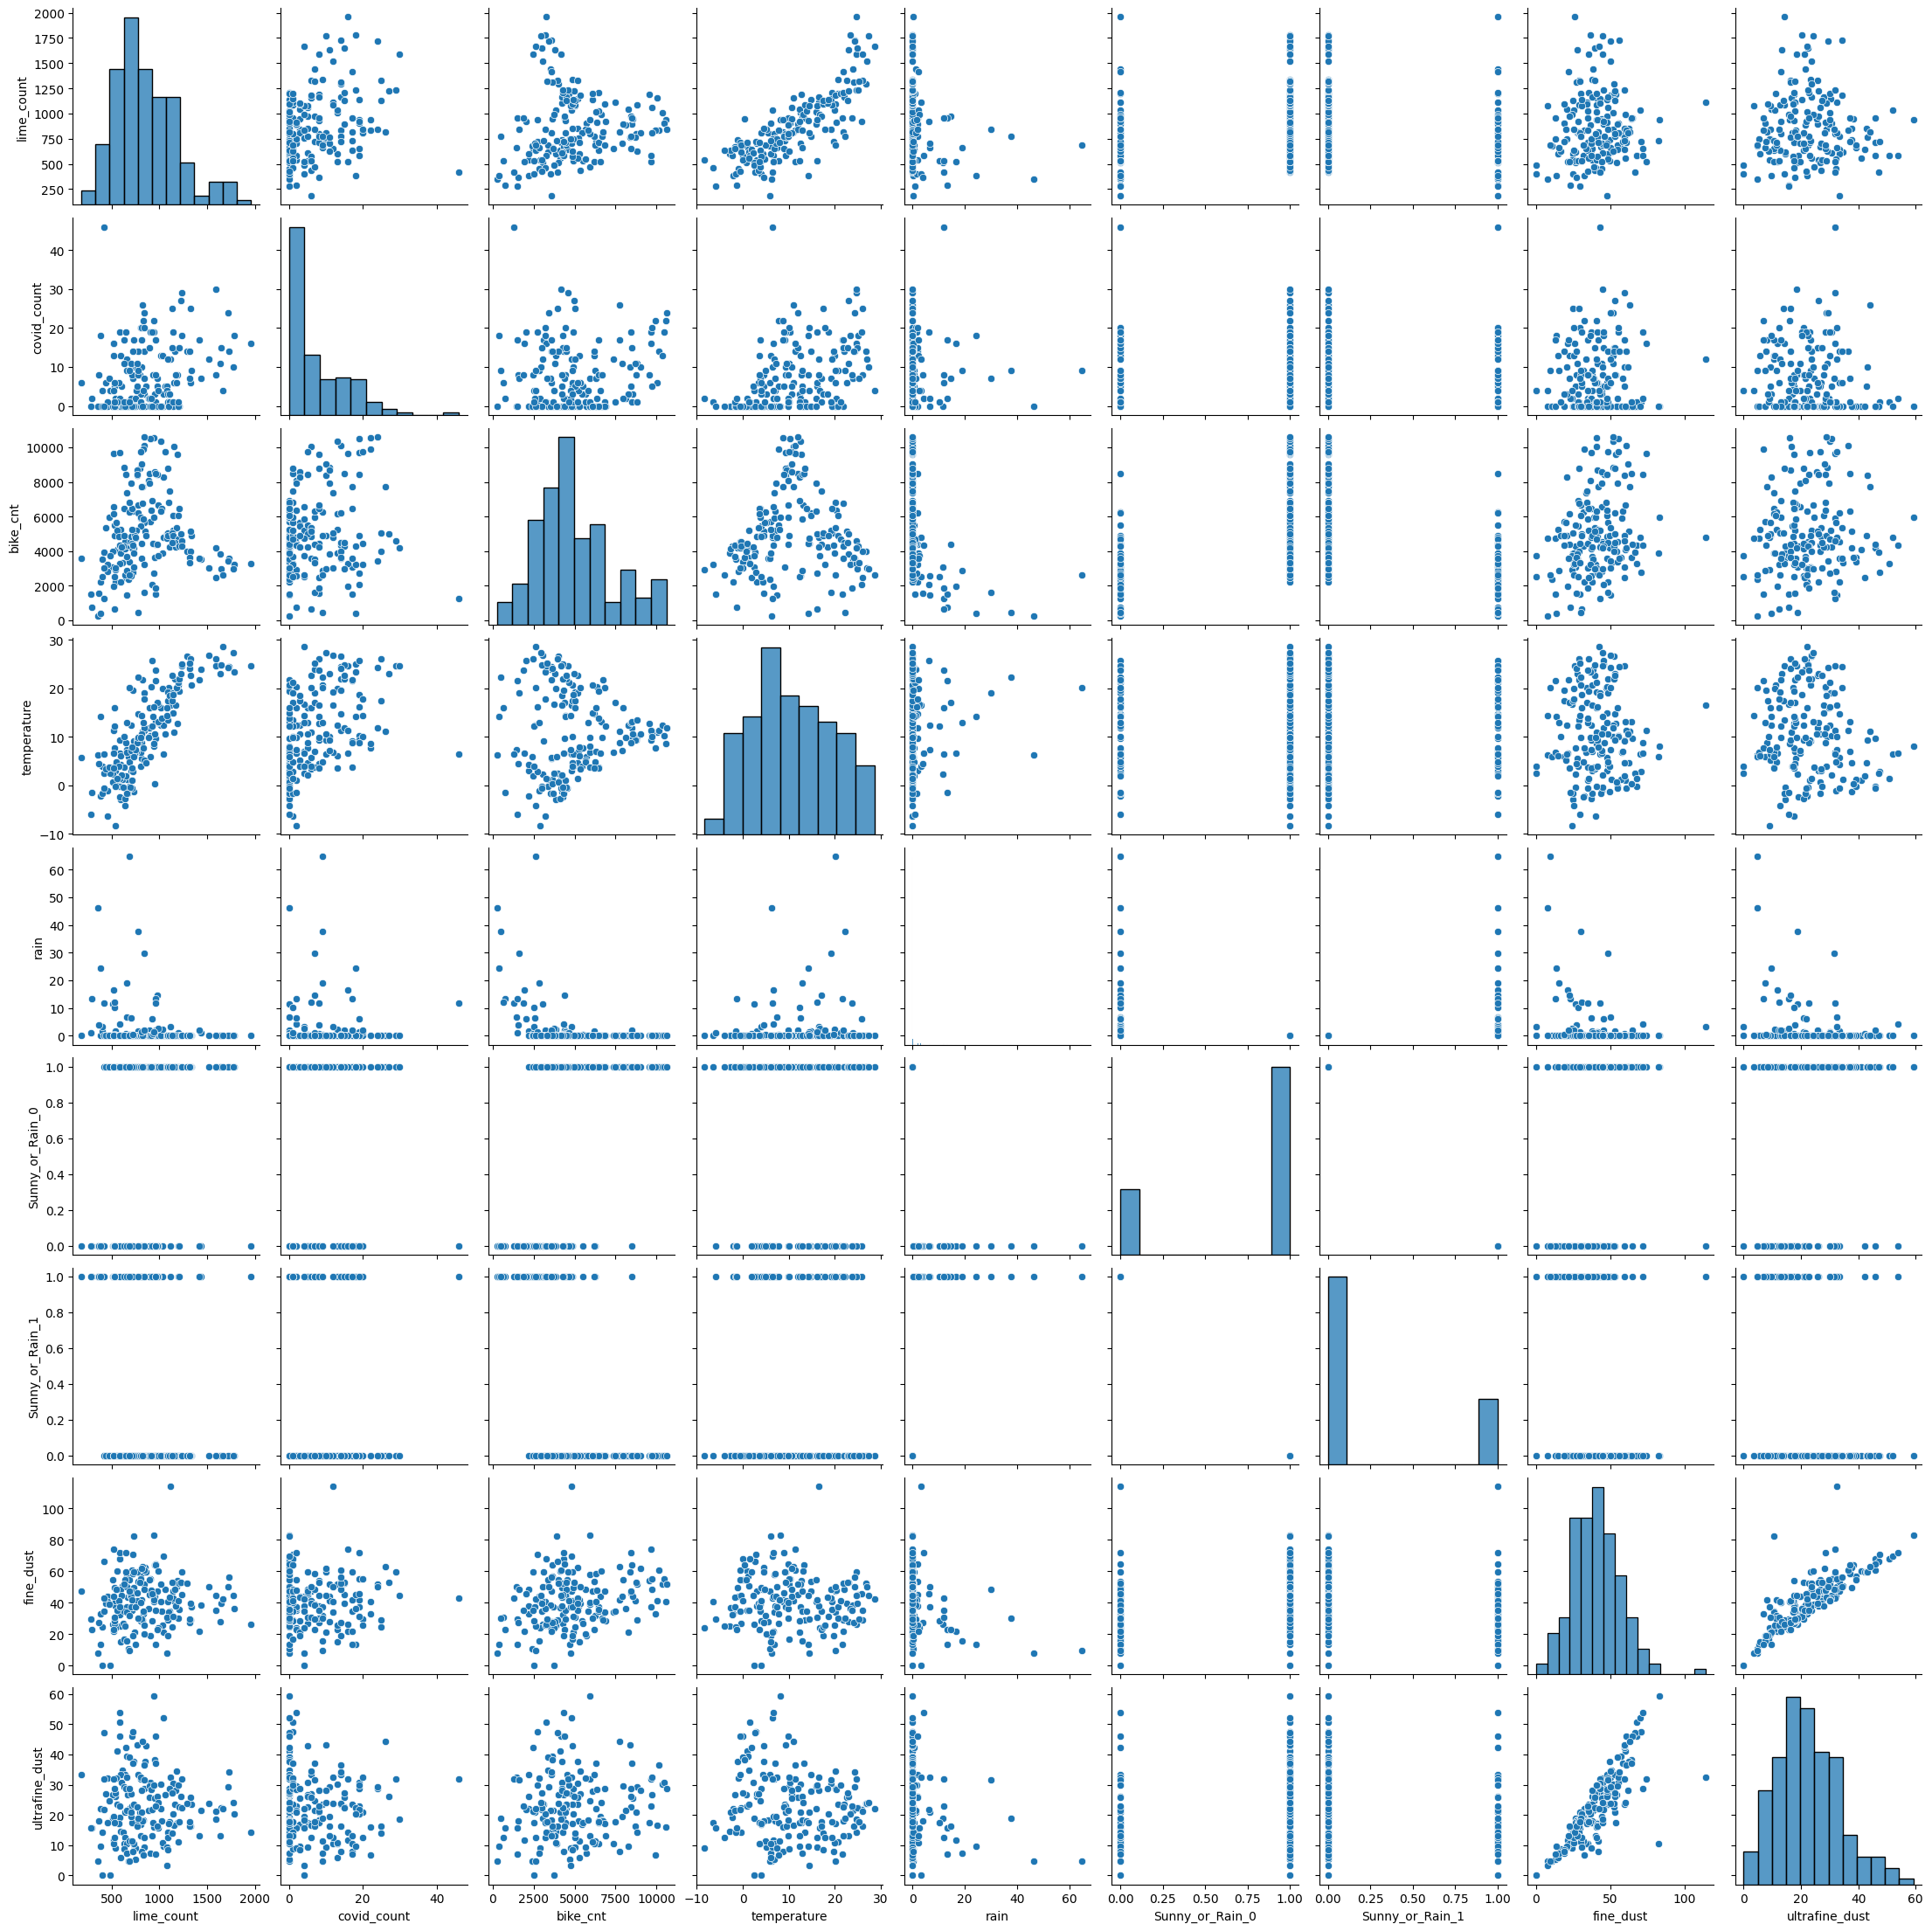

In [192]:
df_pairplot = df_all_count_tmp[['lime_count', 'covid_count', 'bike_cnt', 'temperature',
                                'rain', 'Sunny_or_Rain_0', 'Sunny_or_Rain_1','fine_dust','ultrafine_dust']]

sns.pairplot(df_pairplot)
plt.show()

# 다중선형회귀 분석

In [193]:
df_all_count = df_all_count_tmp.fillna(0)
df_all_count


date  lime_count  covid_count  covid_count_scaled  \
0    2020-01-01         381          0.0           -0.897422   
1    2020-01-02         555          0.0           -0.897422   
2    2020-01-03         584          0.0           -0.897422   
3    2020-01-04         661          0.0           -0.897422   
4    2020-01-05         615          0.0           -0.897422   
..          ...         ...          ...                 ...   
177  2020-06-26        1418         17.0            1.202899   
178  2020-06-27        1314         14.0            0.832254   
179  2020-06-28        1318          7.0           -0.032584   
180  2020-06-29         959          8.0            0.090964   
181  2020-06-30         687          9.0            0.214512   

     lime_count_scaled  bike_cnt  bike_count_scaled  temperature  rain  \
0            -1.439190      2197          -1.197608         -2.2   0.1   
1            -0.913178      4106          -0.374716          1.0   0.0   
2            -0.825510      4333          -0.276866         -0.1   0.0   
3            -0.592735      3649          -0.571710          1.2   0.0   
4            -0.731795      3347          -0.701890          1.3   0.0   
..                 ...       ...                ...          ...   ...   
177           1.695718      3557          -0.611368         21.8   2.1   
178           1.381320      3655          -0.569124         24.1   0.0   
179           1.393412      3329          -0.709649         25.2   0.0   
180           0.308136      1869          -1.338996         23.8  11.9   
181          -0.514135      2616          -1.016994         20.1  64.7   

     Sunny_or_Rain_0  Sunny_or_Rain_1  fine_dust  ultrafine_dust  
0                  0                1  32.666667       22.000000  
1                  1                0  60.333333       41.000000  
2                  1                0  67.666667       46.000000  
3                  1                0  57.000000       39.333333  
4                  1                0  50.666667       34.666667  
..               ...              ...        ...             ...  
177                0                1  21.800000       13.000000  
178                1                0  27.400000       16.200000  
179                1                0  29.400000       17.800000  
180                0                1  35.000000       22.800000  
181                0                1   9.400000        4.600000  

[182 rows x 13 columns]

In [194]:
df_reg = df_all_count[['lime_count', 'covid_count', 'bike_cnt', 'temperature',
                                'rain', 'Sunny_or_Rain_1','fine_dust','ultrafine_dust']]

In [195]:
df_reg

lime_count  covid_count  bike_cnt  temperature  rain  Sunny_or_Rain_1  \
0           381          0.0      2197         -2.2   0.1                1   
1           555          0.0      4106          1.0   0.0                0   
2           584          0.0      4333         -0.1   0.0                0   
3           661          0.0      3649          1.2   0.0                0   
4           615          0.0      3347          1.3   0.0                0   
..          ...          ...       ...          ...   ...              ...   
177        1418         17.0      3557         21.8   2.1                1   
178        1314         14.0      3655         24.1   0.0                0   
179        1318          7.0      3329         25.2   0.0                0   
180         959          8.0      1869         23.8  11.9                1   
181         687          9.0      2616         20.1  64.7                1   

     fine_dust  ultrafine_dust  
0    32.666667       22.000000  
1    60.333333       41.000000  
2    67.666667       46.000000  
3    57.000000       39.333333  
4    50.666667       34.666667  
..         ...             ...  
177  21.800000       13.000000  
178  27.400000       16.200000  
179  29.400000       17.800000  
180  35.000000       22.800000  
181   9.400000        4.600000  

[182 rows x 8 columns]

In [196]:
df_kc_reg = sm.add_constant(df_reg, has_constant='add')
feature_columns = list(df_kc_reg.columns.difference(['lime_count']))

X = df_kc_reg[feature_columns]
y = df_kc_reg.lime_count

# 회귀 모델
multi_linear_model = sm.OLS(y, X)
result_model = multi_linear_model.fit()
result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lime_count   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     75.32
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           2.41e-49
Time:                        12:03:07   Log-Likelihood:                -1187.3
No. Observations:                 182   AIC:                             2391.
Df Residuals:                     174   BIC:                             2416.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Sunny_or_Rain_1  -164.4697     35.689     -4.608      0.000    -234.910     -94.030
bike_cnt           -0.0158      0.007     -2.400      0.017      -0.029      -0.003
const             626.5583     50.847     12.322      0.000     526.202     726.914
covid_count        -1.2423      1.782     -0.697      0.487      -4.759       2.274
fine_dust           0.3542      1.432      0.247      0.805      -2.472       3.180
rain               -9.1616      1.964     -4.666      0.000     -13.037      -5.286
temperature        33.1703      1.649     20.113      0.000      29.915      36.425
ultrafine_dust      0.2950      2.037      0.145      0.885      -3.724       4.315
==============================================================================
Omnibus:                       14.984   Durbin-Watson:                   0.975
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               36.624
Skew:                           0.267   Prob(JB):                     1.11e-08
Kurtosis:                       5.132   Cond. No.                     2.37e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [197]:
result_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                  Results: Ordinary least squares
====================================================================
Model:                OLS              Adj. R-squared:     0.742    
Dependent Variable:   lime_count       AIC:                2390.5702
Date:                 2020-12-21 12:22 BIC:                2416.2023
No. Observations:     182              Log-Likelihood:     -1187.3  
Df Model:             7                F-statistic:        75.32    
Df Residuals:         174              Prob (F-statistic): 2.41e-49 
R-squared:            0.752            Scale:              28401.   
--------------------------------------------------------------------
                  Coef.   Std.Err.    t    P>|t|    [0.025   0.975] 
--------------------------------------------------------------------
Sunny_or_Rain_1 -164.4697  35.6894 -4.6084 0.0000 -234.9096 -94.0299
bike_cnt          -0.0158   0.0066 -2.3995 0.0175   -0.0288  -0.0028
const            626.5583  50.8468 12.3225 0.0000  526.2024 726.9141
covid_count       -1.2423   1.7817 -0.6973 0.4866   -4.7589   2.2742
fine_dust          0.3542   1.4317  0.2474 0.8049   -2.4715   3.1800
rain              -9.1616   1.9635 -4.6659 0.0000  -13.0371  -5.2862
temperature       33.1703   1.6492 20.1130 0.0000   29.9153  36.4253
ultrafine_dust     0.2950   2.0365  0.1449 0.8850   -3.7245   4.3145
--------------------------------------------------------------------
Omnibus:               14.984        Durbin-Watson:           0.975 
Prob(Omnibus):         0.001         Jarque-Bera (JB):        36.624
Skew:                  0.267         Prob(JB):                0.000 
Kurtosis:              5.132         Condition No.:           23706 
====================================================================
* The condition number is large (2e+04). This might indicate
strong multicollinearity or other numerical problems.
"""

In [198]:
# ultra_dust 뺴고 다시
df_reg = df_all_count[['lime_count', 'covid_count', 'bike_cnt', 'temperature',
                                'rain', 'Sunny_or_Rain_1','fine_dust']]

df_kc_reg = sm.add_constant(df_reg, has_constant='add')
feature_columns = list(df_kc_reg.columns.difference(['lime_count']))

X = df_kc_reg[feature_columns]
y = df_kc_reg.lime_count

# 회귀 모델
multi_linear_model = sm.OLS(y, X)
result_model = multi_linear_model.fit()
result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lime_count   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     88.36
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           2.48e-50
Time:                        12:36:57   Log-Likelihood:                -1187.3
No. Observations:                 182   AIC:                             2389.
Df Residuals:                     175   BIC:                             2411.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Sunny_or_Rain_1  -164.3649     35.582     -4.619      0.000    -234.590     -94.140
bike_cnt           -0.0160      0.006     -2.481      0.014      -0.029      -0.003
const             627.5754     50.219     12.497      0.000     528.463     726.687
covid_count        -1.2670      1.769     -0.716      0.475      -4.757       2.224
fine_dust           0.5256      0.804      0.654      0.514      -1.061       2.113
rain               -9.1636      1.958     -4.680      0.000     -13.028      -5.299
temperature        33.1480      1.637     20.244      0.000      29.916      36.380
==============================================================================
Omnibus:                       14.979   Durbin-Watson:                   0.974
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               36.487
Skew:                           0.268   Prob(JB):                     1.19e-08
Kurtosis:                       5.127   Cond. No.                     2.36e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.36e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [201]:
# fine_dust 뺴고 다시
df_reg = df_all_count[['lime_count', 'bike_cnt', 'temperature', 
                                'rain', 'Sunny_or_Rain_1','covid_count']]

df_kc_reg = sm.add_constant(df_reg, has_constant='add')
feature_columns = list(df_kc_reg.columns.difference(['lime_count']))

X = df_kc_reg[feature_columns]
y = df_kc_reg.lime_count

# 회귀 모델
multi_linear_model = sm.OLS(y, X)
result_model = multi_linear_model.fit()
result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lime_count   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     106.3
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           2.81e-51
Time:                        12:37:38   Log-Likelihood:                -1187.5
No. Observations:                 182   AIC:                             2387.
Df Residuals:                     176   BIC:                             2406.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Sunny_or_Rain_1  -166.4251     35.385     -4.703      0.000    -236.258     -96.593
bike_cnt           -0.0154      0.006     -2.421      0.016      -0.028      -0.003
const             647.4903     39.855     16.246      0.000     568.835     726.146
covid_count        -1.2337      1.765     -0.699      0.485      -4.717       2.250
rain               -9.3653      1.930     -4.851      0.000     -13.175      -5.556
temperature        33.1178      1.634     20.267      0.000      29.893      36.343
==============================================================================
Omnibus:                       14.506   Durbin-Watson:                   0.964
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               34.024
Skew:                           0.270   Prob(JB):                     4.09e-08
Kurtosis:                       5.048   Cond. No.                     2.01e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [211]:
# covid_count 뺴고 다시
df_reg = df_all_count[['lime_count', 'bike_cnt', 'temperature',
                                'rain', 'Sunny_or_Rain_1']]

df_kc_reg = sm.add_constant(df_reg, has_constant='add')
feature_columns = list(df_kc_reg.columns.difference(['lime_count']))

X = df_kc_reg[feature_columns]
y = df_kc_reg.lime_count

# 회귀 모델
multi_linear_model = sm.OLS(y, X)
result_model = multi_linear_model.fit()
result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lime_count   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     133.1
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           2.91e-52
Time:                        12:43:52   Log-Likelihood:                -1187.8
No. Observations:                 182   AIC:                             2386.
Df Residuals:                     177   BIC:                             2402.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Sunny_or_Rain_1  -169.7234     35.018     -4.847      0.000    -238.829    -100.617
bike_cnt           -0.0163      0.006     -2.604      0.010      -0.029      -0.004
const             649.1323     39.728     16.339      0.000     570.730     727.535
rain               -9.3832      1.927     -4.868      0.000     -13.187      -5.580
temperature        32.6080      1.460     22.331      0.000      29.726      35.490
==============================================================================
Omnibus:                       13.372   Durbin-Watson:                   0.972
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               29.083
Skew:                           0.265   Prob(JB):                     4.84e-07
Kurtosis:                       4.885   Cond. No.                     2.00e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [204]:
# result_model.es

# 시각화

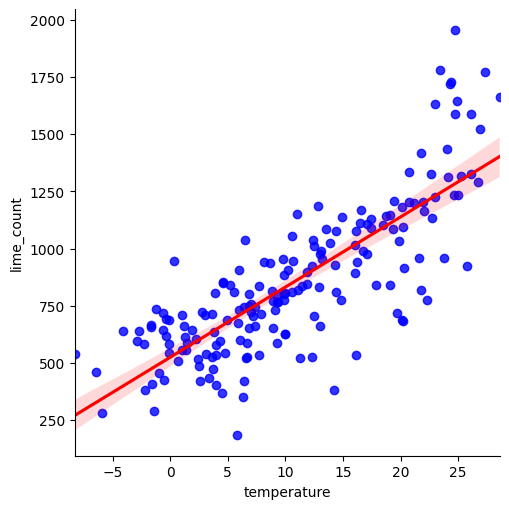

In [205]:
# 음영 부분: 선형회귀 직선의 95% 신뢰구간

sns.lmplot( x='temperature', y='lime_count', data=df_reg,
          scatter_kws = {"color": "blue"},
          line_kws = {"color": "red"})

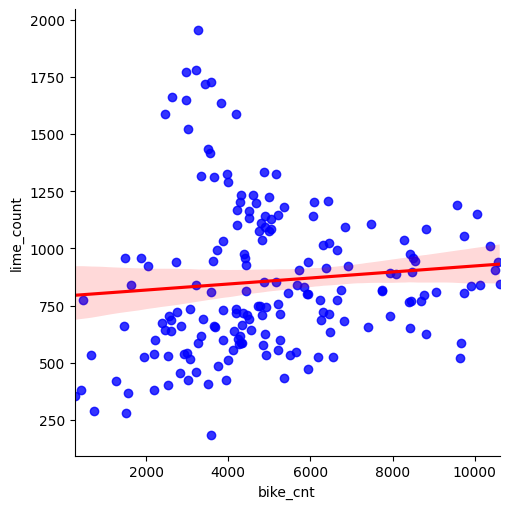

In [206]:
# 음영 부분: 선형회귀 직선의 95% 신뢰구간

sns.lmplot( x='bike_cnt', y='lime_count', data=df_reg,
          scatter_kws = {"color": "blue"},
          line_kws = {"color": "red"})

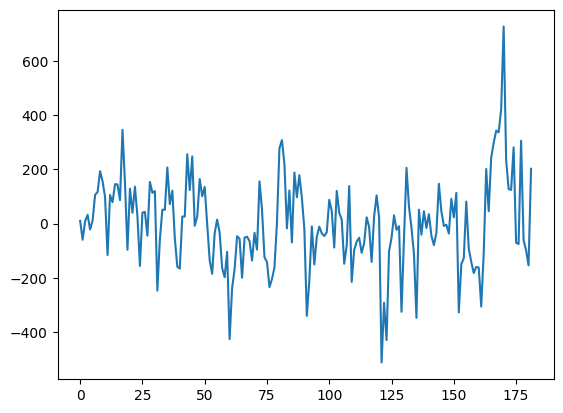

In [207]:
# 잔차 확인
result_model.resid.plot()
plt.show()

In [213]:
df_reg

lime_count  bike_cnt  temperature  rain  Sunny_or_Rain_1
0           381      2197         -2.2   0.1                1
1           555      4106          1.0   0.0                0
2           584      4333         -0.1   0.0                0
3           661      3649          1.2   0.0                0
4           615      3347          1.3   0.0                0
..          ...       ...          ...   ...              ...
177        1418      3557         21.8   2.1                1
178        1314      3655         24.1   0.0                0
179        1318      3329         25.2   0.0                0
180         959      1869         23.8  11.9                1
181         687      2616         20.1  64.7                1

[182 rows x 5 columns]

## 다중공선성(VIF) 확인

In [214]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

df_vif = pd.DataFrame()
df_vif["VIF"] = np.round([variance_inflation_factor(X .values, i) for i in range(X .shape[1])], 2)
df_vif["features"] = X .columns
df_vif.sort_values(by='VIF', ascending=False)

VIF         features
2  10.23            const
0   1.52  Sunny_or_Rain_1
3   1.38             rain
1   1.36         bike_cnt
4   1.02      temperature

## 정규성 검정
### Q-Q 플롯

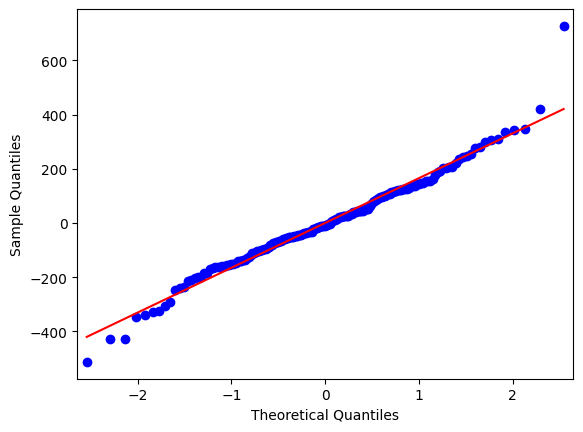

In [190]:
# Q-Q 플롯
qqplot = sm.qqplot(result_model.resid, line = "s")

### 잔차 패턴 확인

Text(0, 0.5, 'Residual')

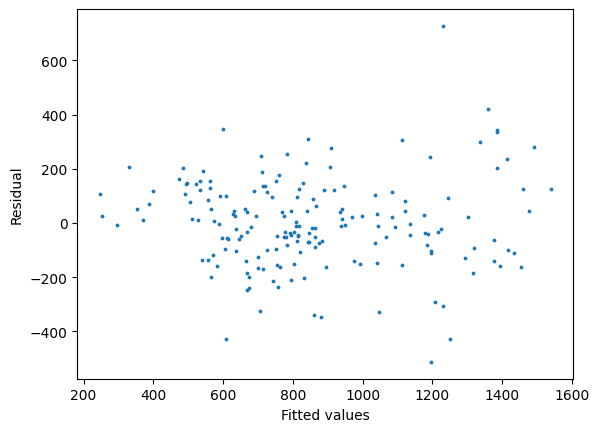

In [191]:
fitted = result_model.predict()

resid = result_model.resid
pred = result_model.predict(X)
fig = plt.scatter(pred, resid, s=3)

# plt.xlim(2)
# plt.xlim(20, 140)
# plt.xlim(0.5)
plt.xlabel('Fitted values')
plt.ylabel('Residual')

### 샤피로-윌크 검정(Shapiro-Will test)

In [192]:
result_shapiro = stats.shapiro(result_model.resid)
print(f'F-Value : {result_shapiro[0]:.4f} / P-value : {result_shapiro[1]:.4f}')

if result_shapiro[1] < 0.05:
    print("P-value < 0.05 입니다.")

F-Value : 0.9791 / P-value : 0.0078
P-value < 0.05 입니다.


## 독립성 검정
### 잔차그래프

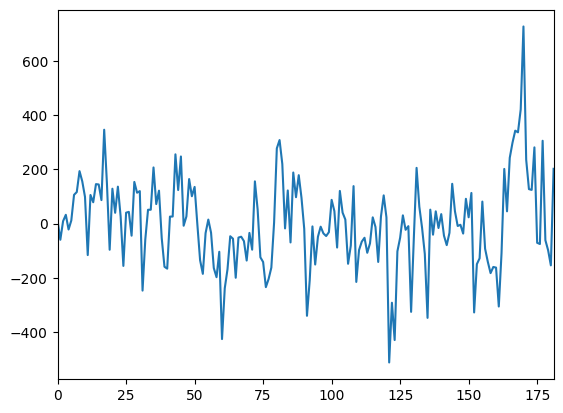

In [193]:
# 잔차 그래프
result_model.resid.plot()
plt.show()

### ACF(Auto-Correlation Function)

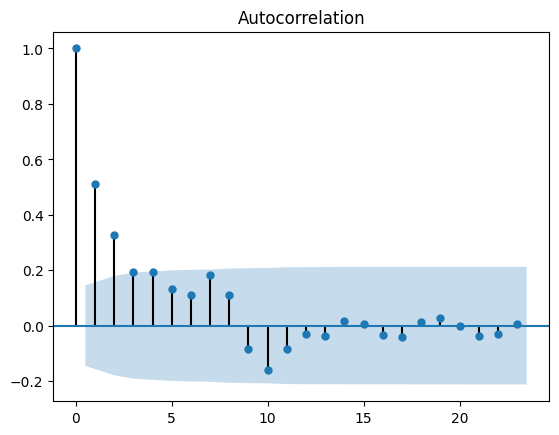

In [194]:
sm.graphics.tsa.plot_acf(result_model.resid)
plt.show()

## 등분산성
### 잔차그래프

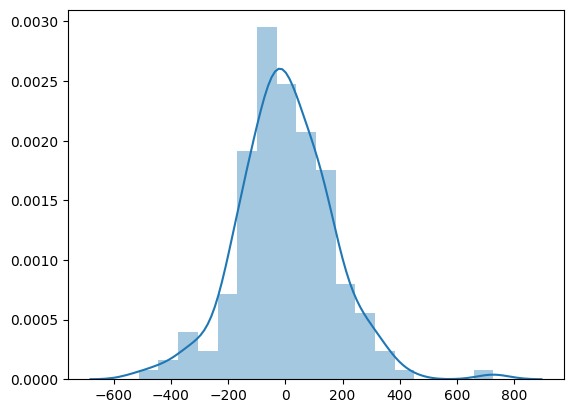

In [195]:
sns.distplot(result_model.resid)
plt.show()

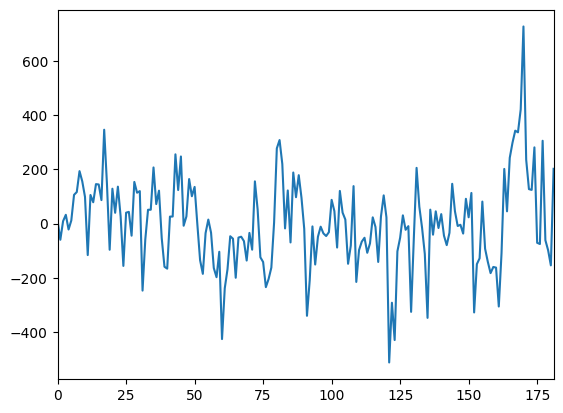

In [196]:
result_model.resid.plot()
plt.show()

# 여기선 부터는 ML 을 위한 부분 데이터 나누고

In [254]:
df_all_count

date  lime_count  covid_count  covid_count_scaled  \
0    2020-01-01         381          0.0           -0.897422   
1    2020-01-02         555          0.0           -0.897422   
2    2020-01-03         584          0.0           -0.897422   
3    2020-01-04         661          0.0           -0.897422   
4    2020-01-05         615          0.0           -0.897422   
..          ...         ...          ...                 ...   
177  2020-06-26        1418         17.0            1.202899   
178  2020-06-27        1314         14.0            0.832254   
179  2020-06-28        1318          7.0           -0.032584   
180  2020-06-29         959          8.0            0.090964   
181  2020-06-30         687          9.0            0.214512   

     lime_count_scaled  bike_cnt  bike_count_scaled  temperature  rain  \
0            -1.439190      2197          -1.197608         -2.2   0.1   
1            -0.913178      4106          -0.374716          1.0   0.0   
2            -0.825510      4333          -0.276866         -0.1   0.0   
3            -0.592735      3649          -0.571710          1.2   0.0   
4            -0.731795      3347          -0.701890          1.3   0.0   
..                 ...       ...                ...          ...   ...   
177           1.695718      3557          -0.611368         21.8   2.1   
178           1.381320      3655          -0.569124         24.1   0.0   
179           1.393412      3329          -0.709649         25.2   0.0   
180           0.308136      1869          -1.338996         23.8  11.9   
181          -0.514135      2616          -1.016994         20.1  64.7   

     Sunny_or_Rain_0  Sunny_or_Rain_1  fine_dust  ultrafine_dust  
0                  0                1  32.666667       22.000000  
1                  1                0  60.333333       41.000000  
2                  1                0  67.666667       46.000000  
3                  1                0  57.000000       39.333333  
4                  1                0  50.666667       34.666667  
..               ...              ...        ...             ...  
177                0                1  21.800000       13.000000  
178                1                0  27.400000       16.200000  
179                1                0  29.400000       17.800000  
180                0                1  35.000000       22.800000  
181                0                1   9.400000        4.600000  

[182 rows x 13 columns]

In [255]:
df_reg = df_all_count[['lime_count', 'covid_count', 'bike_cnt', 'temperature',
                                'rain', 'Sunny_or_Rain_1','fine_dust','ultrafine_dust','date']]

In [256]:
df_reg['log_cnt'] = np.log10(df_reg['lime_count'])

In [257]:
# Train data
train_df = df_reg.loc[df_reg['date'] < '2020-06-01']

# Test data
test_df = df_reg.loc[df_reg['date'] < '2020-07-01']

In [258]:
train_df.tail()

lime_count  covid_count  bike_cnt  temperature  rain  Sunny_or_Rain_1  \
147        1130         25.0      5029         17.4   0.0                0   
148        1142         19.0      4900         18.7   0.0                0   
149        1336          9.0      4871         20.7   0.0                0   
150        1325          6.0      5163         22.6   0.0                0   
151        1198          1.0      4674         21.2   1.0                1   

     fine_dust  ultrafine_dust        date   log_cnt  
147       24.6            14.0  2020-05-27  3.053078  
148       31.0            20.4  2020-05-28  3.057666  
149       37.6            23.4  2020-05-29  3.125806  
150       39.8            25.8  2020-05-30  3.122216  
151       41.0            30.0  2020-05-31  3.078457

In [259]:
test_df.tail()

lime_count  covid_count  bike_cnt  temperature  rain  Sunny_or_Rain_1  \
177        1418         17.0      3557         21.8   2.1                1   
178        1314         14.0      3655         24.1   0.0                0   
179        1318          7.0      3329         25.2   0.0                0   
180         959          8.0      1869         23.8  11.9                1   
181         687          9.0      2616         20.1  64.7                1   

     fine_dust  ultrafine_dust        date   log_cnt  
177       21.8            13.0  2020-06-26  3.151676  
178       27.4            16.2  2020-06-27  3.118595  
179       29.4            17.8  2020-06-28  3.119915  
180       35.0            22.8  2020-06-29  2.981819  
181        9.4             4.6  2020-06-30  2.836957

In [260]:
del train_df['date']
del test_df['date']

In [261]:
y_train_raw = train_df.pop('lime_count')
y_train_log = train_df.pop('log_cnt')
y_test_raw = test_df.pop('lime_count')
y_test_log = test_df.pop('log_cnt')

In [262]:
x_train = train_df.copy()
x_test = test_df.copy()

In [263]:
from sklearn.linear_model import LinearRegression

lr_reg = LinearRegression()
lr_reg.fit(x_train, y_train_log)
pred = lr_reg.predict(x_test)
pred

array([2.63852037, 2.79199683, 2.78032883, 2.79083374, 2.78758335,
       2.71483381, 2.55867141, 2.6626971 , 2.75215742, 2.76713052,
       2.76824566, 2.7460205 , 2.71346411, 2.72849518, 2.72473572,
       2.74412562, 2.76785225, 2.78252412, 2.71390267, 2.78659105,
       2.76654527, 2.82056716, 2.85423655, 2.81591885, 2.82618069,
       2.84073912, 2.75127628, 2.85901145, 2.85549837, 2.83614295,
       2.8191942 , 2.81818997, 2.79579883, 2.75483623, 2.64403816,
       2.62295835, 2.66505494, 2.73560822, 2.75972449, 2.75064091,
       2.83700798, 2.88974871, 2.76347974, 2.88275656, 2.92000525,
       2.84036612, 2.57995791, 2.57508087, 2.68972981, 2.77575433,
       2.83771659, 2.78216204, 2.69547006, 2.77155032, 2.86932566,
       2.66353512, 2.83505202, 2.82183248, 2.70033087, 2.78876072,
       2.76002749, 2.80969573, 2.84861108, 2.79084893, 2.78788655,
       2.81490599, 2.87745277, 2.914798  , 2.90375707, 2.61507904,
       2.79653783, 2.85761323, 2.74627547, 2.81438575, 2.82012

In [264]:
test_df['pred_log']= pred
test_df['pred_reverse'] = 10**pred
test_df['real_log'] = y_test_log
test_df['real_raw'] = y_test_raw

In [267]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


def evaluation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    score = pd.DataFrame([mape, mae, mse], index=['mape', 'mae', 'mse'], columns=['score']).T
    return score

In [268]:
evaluation(test_df['real_raw'], test_df['pred_reverse'])

mape         mae           mse
score  16.05204  126.465059  32461.163153

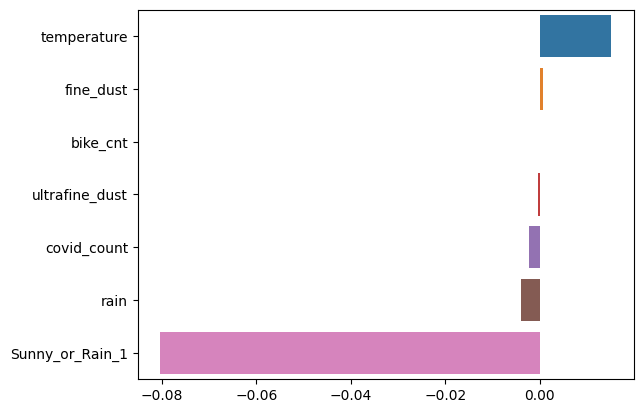

In [269]:
coef = pd.Series(lr_reg.coef_ , index=x_train.columns)
coef_sort = coef.sort_values(ascending=False)[:10]
sns.barplot(x=coef_sort.values , y=coef_sort.index);

## Xgboost Regressor

In [417]:
from sacred import Experiment
from sacred.observers import FileStorageObserver
from xgboost import XGBRegressor
import os

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

In [418]:
ex = Experiment('nyc-demand-prediction', interactive=True)


# experiment_dir가 없으면 폴더 생성하고 FileStorageObserver로 저장
experiment_dir = os.path.join('./', 'experiments')
if not os.path.isdir(experiment_dir): 
    os.makedirs(experiment_dir)
ex.observers.append(FileStorageObserver.create(experiment_dir))

In [419]:
@ex.config
def config():
    max_depth=5
    learning_rate=0.1
    n_estimators=100
    n_jobs=-1

In [420]:
@ex.capture
def get_model(max_depth, learning_rate, n_estimators, n_jobs):
    return XGBRegressor(max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators, n_jobs=n_jobs)

In [421]:
@ex.main
def run(_log, _run):
    global xgb_reg, xgb_pred
    xgb_reg = get_model()
    xgb_reg.fit(x_train, y_train_raw)
    xgb_pred = xgb_reg.predict(x_test)
    score = evaluation(y_test_raw, xgb_pred)
    
    _run.log_scalar('model_name', xgb_reg.__class__.__name__)    
    _run.log_scalar('metrics', score)
    
    return score.to_dict()


In [422]:
experiment_result = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "35"
INFO - nyc-demand-prediction - Result: {'mape': {'score': 4.478342996300431}, 'mae': {'score': 54.96693361722506}, 'mse': {'score': 23189.52326976886}}
INFO - nyc-demand-prediction - Completed after 0:00:00


In [423]:
experiment_result.config

{'max_depth': 5,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'n_jobs': -1,
 'seed': 725915236}

In [424]:
def parsing_output(ex_id):
    with open(f'./experiments/{ex_id}/metrics.json') as json_file:
        json_data = json.load(json_file)
    with open(f'./experiments/{ex_id}/config.json') as config_file:
        config_data = json.load(config_file)
    
    output_df = pd.DataFrame(json_data['model_name']['values'], columns=['model_name'], index=['score'])
    output_df['experiment_num'] = ex_id
    output_df['config'] = str(config_data)
    
#     output_df['mae'] = 
    
    d = json_data['metrics']['values'][0]['values']
    
#     dic_ = json.loads(d)
#     print(dic_)
    
    print(d)
    
#     print(json_data['metrics']['values'][0]['values'])
#     print(dic_.values)
    
    
#     metric_df = pd.DataFrame(d)
#     print(metric_df)
#     output_df = pd.concat([output_df, metric_df], axis=1)
#     return output_df

In [425]:
parsing_output(35)

mape,mae,mse
4.478342996300431,54.96693361722506,23189.52326976886



<AxesSubplot:>

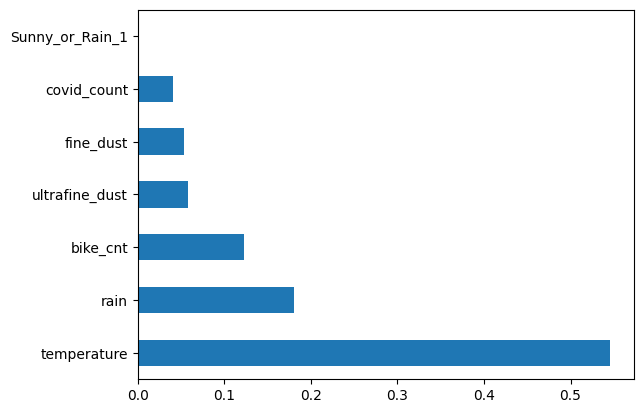

In [306]:
feat_importances = pd.Series(xgb_reg.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

## Lightgbm

In [426]:
@ex.config
def config():
    num_leaves=31
    max_depth=-1
    learning_rate=0.1
    n_estimators=100

In [427]:
@ex.capture
def get_model(num_leaves, max_depth, learning_rate, n_estimators):
    return LGBMRegressor(num_leaves=num_leaves, max_depth=max_depth, learning_rate=learning_rate, n_estimators=n_estimators)

In [428]:
@ex.main
def run(_log, _run):
    global lgbm_reg, lgbm_pred
    lgbm_reg = get_model()
    lgbm_reg.fit(x_train, y_train_raw)
    lgbm_pred = lgbm_reg.predict(x_test)
    score = evaluation(y_test_raw, lgbm_pred)
    
    _run.log_scalar('model_name', lgbm_reg.__class__.__name__)    
    _run.log_scalar('metrics', score)
    
    return score.to_dict()


In [429]:
from lightgbm import LGBMRegressor

experiment_result = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "36"
INFO - nyc-demand-prediction - Result: {'mape': {'score': 12.475861082930692}, 'mae': {'score': 112.1833578616377}, 'mse': {'score': 39929.44705126402}}
INFO - nyc-demand-prediction - Completed after 0:00:00


In [430]:
experiment_result.config

{'max_depth': -1,
 'learning_rate': 0.1,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'seed': 532023852}

In [431]:
def parsing_output(ex_id):
    with open(f'./experiments/{ex_id}/metrics.json') as json_file:
        json_data = json.load(json_file)
    with open(f'./experiments/{ex_id}/config.json') as config_file:
        config_data = json.load(config_file)
    
    output_df = pd.DataFrame(json_data['model_name']['values'], columns=['model_name'], index=['score'])
    output_df['experiment_num'] = ex_id
#     output_df['config'] = str(config_data)
    print(json_data['metrics']['values'][0]['values'])
#     metric_df = pd.DataFrame(json_data['metrics']['values'][0]['values'])
    
#     output_df = pd.concat([output_df, metric_df], axis=1)
    return output_df

In [432]:
parsing_output(36)

mape,mae,mse
12.475861082930692,112.1833578616377,39929.44705126402



model_name  experiment_num
score  LGBMRegressor              36

<AxesSubplot:>

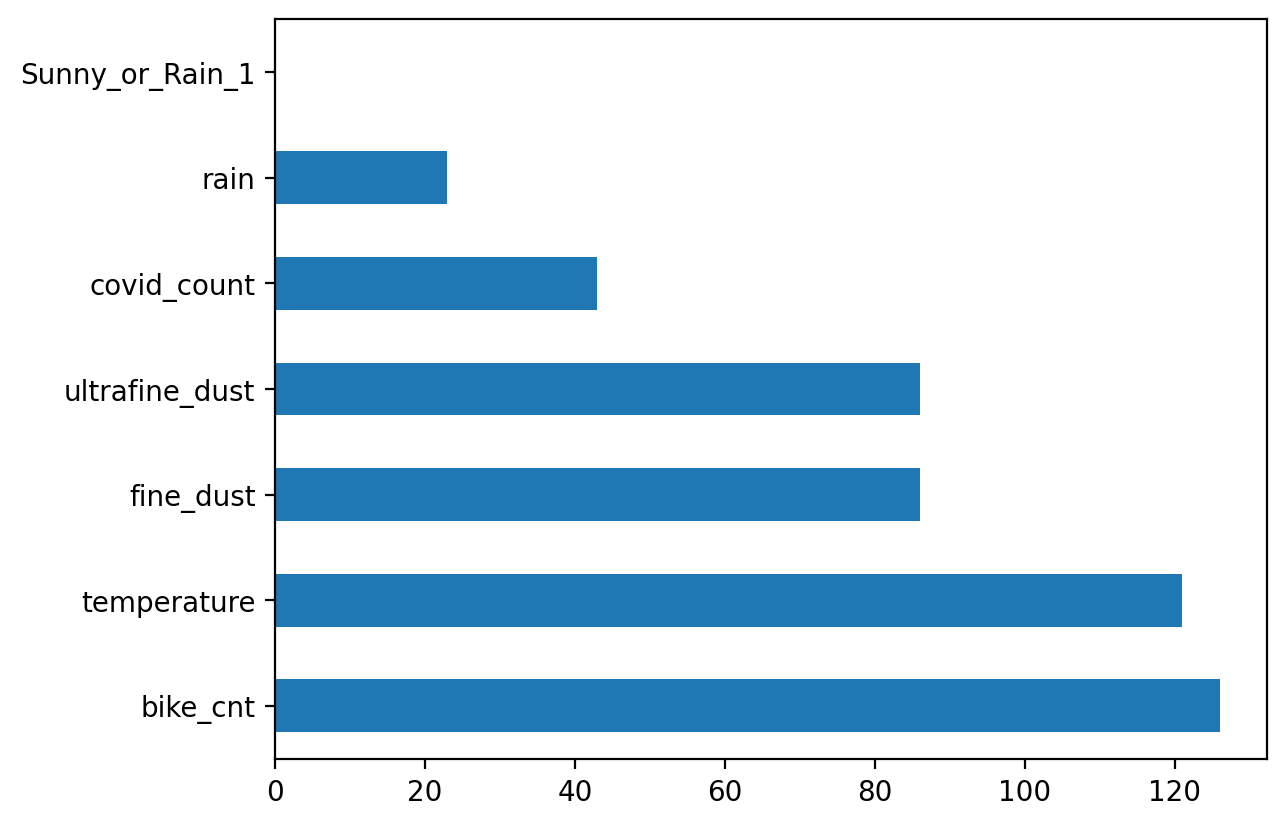

In [405]:
feat_importances = pd.Series(lgbm_reg.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')

## 랜덤포레스트

In [433]:
@ex.config
def config():
    n_estimators=10
    n_jobs=-1

In [434]:
@ex.capture
def get_model(n_estimators, n_jobs):
    return RandomForestRegressor(n_estimators=n_estimators, n_jobs=n_jobs)


In [435]:
@ex.main
def run(_log, _run):
    global rf_reg, rf_pred
    rf_reg = get_model()
    rf_reg.fit(x_train, y_train_raw)
    rf_pred = rf_reg.predict(x_test)
    score = evaluation(y_test_raw, rf_pred)
    
    _run.log_scalar('model_name', rf_reg.__class__.__name__)    
    _run.log_scalar('metrics', score)
    
    return score.to_dict()


In [436]:
from sklearn.ensemble import RandomForestRegressor

experiment_result = ex.run()

INFO - nyc-demand-prediction - Running command 'run'
INFO - nyc-demand-prediction - Started run with ID "37"
INFO - nyc-demand-prediction - Result: {'mape': {'score': 9.003179755888691}, 'mae': {'score': 85.87582417582418}, 'mse': {'score': 25363.16802197803}}
INFO - nyc-demand-prediction - Completed after 0:00:00


In [437]:
experiment_result.config

{'max_depth': -1,
 'learning_rate': 0.1,
 'n_estimators': 10,
 'n_jobs': -1,
 'num_leaves': 31,
 'seed': 404843419}

<AxesSubplot:>

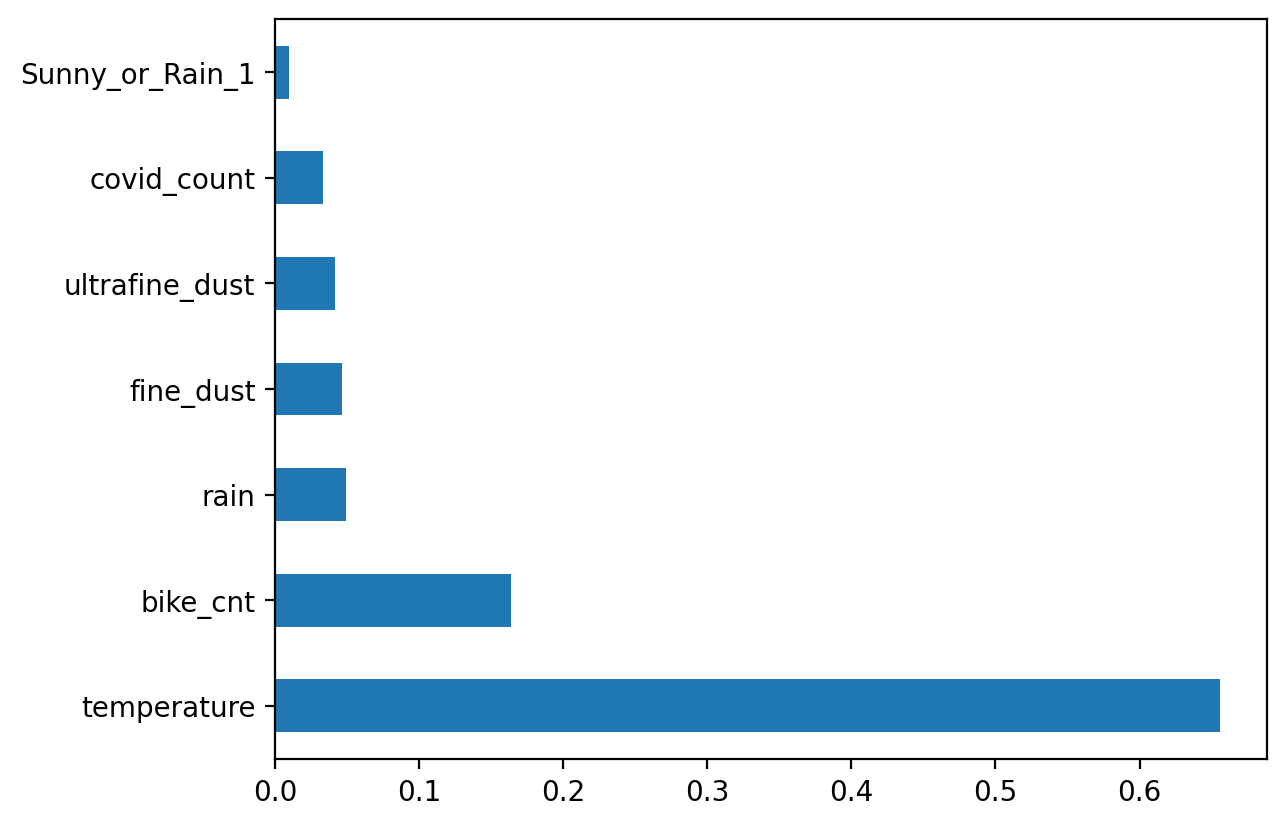

In [412]:
feat_importances = pd.Series(rf_reg.feature_importances_, index=x_train.columns)
feat_importances.nlargest(15).plot(kind='barh')